In [103]:
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

<h1 style="text-align:center">🏰 Data Modelling</h1> 

<h3 style="text-align:center">Predict BTC prices</h3> 

# 🎖 1. Get newest data points

## ➡️ Define symbol and time interval

In [104]:
symbol = "BTCUSDT"
PERIOD = "15m"

In [105]:
!jupyter nbconvert --to python ../obtain/get_newest_price.ipynb
!python ../obtain/get_newest_price.py

[NbConvertApp] Converting notebook ../obtain/get_newest_price.ipynb to python
[NbConvertApp] Writing 1547 bytes to ../obtain/get_newest_price.py


In [106]:
#pd_df = pd.read_csv(f"../../datastore/price/{symbol}_{PERIOD}.csv")
#pd_df = pd_df.iloc[-1800:]
pd_df = pd.read_csv('../Data/data.csv')
try:
    pd_df.drop(columns=['Unnamed: 0','base','quote','Unused field, ignore'],inplace=True)
except:
    pass
pd_df = pd_df[pd_df.Symbol == symbol].drop(columns='Symbol',inplace=True)
pd_df

,Kline open time,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
170672,1671573600000,16877.21,16911.06,16852.86,16900.58,1586.93507,1671574499999,2.678284e+07,38824,851.87301,1.437756e+07
170673,1671574500000,16900.58,16903.11,16847.19,16878.86,1648.36306,1671575399999,2.781734e+07,37043,732.52556,1.236224e+07
170674,1671575400000,16878.28,16894.00,16861.97,16877.78,1510.88610,1671576299999,2.550624e+07,35480,706.45813,1.192587e+07
170675,1671576300000,16877.09,16905.64,16863.14,16869.24,1639.75775,1671577199999,2.768237e+07,33276,722.18561,1.219045e+07
170676,1671577200000,16869.00,16911.00,16867.88,16897.29,2035.02987,1671578099999,3.438204e+07,47846,1030.37407,1.740837e+07
...,...,...,...,...,...,...,...,...,...,...,...
172467,1673189100000,16942.41,16954.30,16942.00,16952.44,1708.36199,1673189999999,2.895507e+07,52045,869.10627,1.473063e+07
172468,1673190000000,16952.44,16959.00,16938.00,16944.01,1555.98505,1673190899999,2.636761e+07,46116,751.28979,1.273145e+07
172469,1673190900000,16944.32,16945.71,16940.93,16941.39,142.29306,1673191799999,2.410904e+06,4579,62.65071,1.061517e+06
172470,1673191800000,16950.27,16958.70,16945.02,16954.84,1518.80865,1673192699999,2.574450e+07,46724,808.97731,1.371258e+07


## ➡️ Select features

### 📌 Using Open time as index to visualize later

In [107]:
pd_df["Open price"] = pd_df["Open price"].apply(lambda price: float(price))
pd_df = pd_df.set_index("Kline open time").sort_index() 
pd_df.index = pd.to_datetime(pd_df.index, unit='ms') + pd.Timedelta('07:00:00')
pd_df

Open price  High price  Low price  Close price  \
Kline open time                                                       
2022-12-21 05:00:00    16877.21    16911.06   16852.86     16900.58   
2022-12-21 05:15:00    16900.58    16903.11   16847.19     16878.86   
2022-12-21 05:30:00    16878.28    16894.00   16861.97     16877.78   
2022-12-21 05:45:00    16877.09    16905.64   16863.14     16869.24   
2022-12-21 06:00:00    16869.00    16911.00   16867.88     16897.29   
...                         ...         ...        ...          ...   
2023-01-08 21:45:00    16942.41    16954.30   16942.00     16952.44   
2023-01-08 22:00:00    16952.44    16959.00   16938.00     16944.01   
2023-01-08 22:15:00    16944.32    16945.71   16940.93     16941.39   
2023-01-08 22:30:00    16950.27    16958.70   16945.02     16954.84   
2023-01-08 22:45:00    16955.23    17001.25   16954.07     17000.13   

                         Volume  Kline Close time  Quote asset volume  \
Kline open time                                                         
2022-12-21 05:00:00  1586.93507     1671574499999        2.678284e+07   
2022-12-21 05:15:00  1648.36306     1671575399999        2.781734e+07   
2022-12-21 05:30:00  1510.88610     1671576299999        2.550624e+07   
2022-12-21 05:45:00  1639.75775     1671577199999        2.768237e+07   
2022-12-21 06:00:00  2035.02987     1671578099999        3.438204e+07   
...                         ...               ...                 ...   
2023-01-08 21:45:00  1708.36199     1673189999999        2.895507e+07   
2023-01-08 22:00:00  1555.98505     1673190899999        2.636761e+07   
2023-01-08 22:15:00   142.29306     1673191799999        2.410904e+06   
2023-01-08 22:30:00  1518.80865     1673192699999        2.574450e+07   
2023-01-08 22:45:00  2027.72768     1673193599999        3.441961e+07   

                     Number of trades  Taker buy base asset volume  \
Kline open time                                                      
2022-12-21 05:00:00             38824                    851.87301   
2022-12-21 05:15:00             37043                    732.52556   
2022-12-21 05:30:00             35480                    706.45813   
2022-12-21 05:45:00             33276                    722.18561   
2022-12-21 06:00:00             47846                   1030.37407   
...                               ...                          ...   
2023-01-08 21:45:00             52045                    869.10627   
2023-01-08 22:00:00             46116                    751.28979   
2023-01-08 22:15:00              4579                     62.65071   
2023-01-08 22:30:00             46724                    808.97731   
2023-01-08 22:45:00             38292                   1157.23443   

                     Taker buy base asset volume  \
Kline open time                                    
2022-12-21 05:00:00                  1.437756e+07  
2022-12-21 05:15:00                  1.236224e+07  
2022-12-21 05:30:00                  1.192587e+07  
2022-12-21 05:45:00                  1.219045e+07  
2022-12-21 06:00:00                  1.740837e+07  
...                                           ...  
2023-01-08 21:45:00                  1.473063e+07  
2023-01-08 22:00:00                  1.273145e+07  
2023-01-08 22:15:00                  1.061517e+06  
2023-01-08 22:30:00                  1.371258e+07  
2023-01-08 22:45:00                  1.964580e+07  

                     Taker buy quote asset volume  Unused field, ignore  
Kline open time                                                          
2022-11-26 00:00:00                  2.842171e+07                     0  
2022-11-26 00:30:00                  3.399223e+07                     0  
2022-11-26 01:00:00                  2.058911e+07                     0  
2022-11-26 01:30:00                  1.930727e+07                     0  
2022-11-26 02:00:00                  2.585432e+07                     0  
...                                      

### 📌 Visualize prices as candle stick

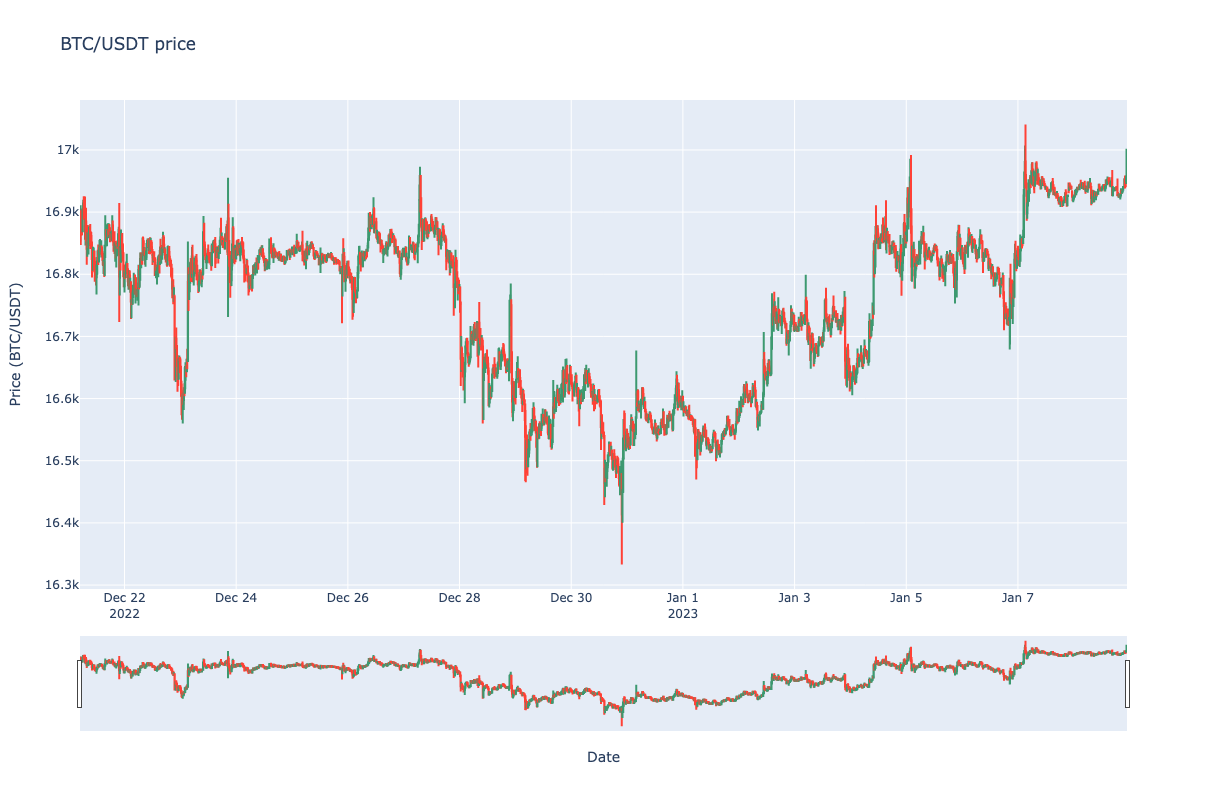

In [108]:
fig = go.Figure(data=[go.Candlestick(x=pd_df.index,
                open=pd_df['Open price'],
                high=pd_df['High price'],
                low=pd_df['Low price'],
                close=pd_df['Close price'])])
# set new height and width
fig.update_layout(
    height=800,
    width=1000,
    title_text="BTC/USDT price",
    yaxis_title="Price (BTC/USDT)",
    xaxis_title="Date",
    xaxis_rangeslider_visible=True
)

fig.show()

### 📌 Using open price as feature and target as well

In [109]:
dataset = pd_df.filter(["Open price"]).values
dataset[:5]

array([[16877.21],
       [16900.58],
       [16878.28],
       [16877.09],
       [16869.  ]])

# 🎖 2. Prepare train-test set

✅ Train-Test ratio: `80%` train, `20%` test <br>
✅ Train-Valid ratio: `70%` train, `30%` valid

In [110]:
TRAIN_TEST_LENGTH = int(len(dataset) * 0.8)
TRAIN_VALID_LENGTH = int(TRAIN_TEST_LENGTH * 0.7)

## ➡️ Scale data

In [111]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data[:5]

array([[0.81627149],
       [0.85747025],
       [0.81815778],
       [0.81605994],
       [0.80179815]])

## ➡️ Prepare time series data

In [112]:
X = []
Y = []
for i in range(60,len(scaled_data)):
    X.append(scaled_data[i-60:i,:])
    Y.append(scaled_data[i,:])

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

(1740, 60, 1) (1740, 1)


## ➡️ Split train-test set

In [113]:
X_origin_train = X[:TRAIN_TEST_LENGTH]
Y_origin_train = Y[:TRAIN_TEST_LENGTH]

X_test = X[TRAIN_TEST_LENGTH:]
Y_test = Y[TRAIN_TEST_LENGTH:]

print(X_origin_train.shape, Y_origin_train.shape)
print(X_test.shape, Y_test.shape)

(1440, 60, 1) (1440, 1)
(300, 60, 1) (300, 1)


## ➡️ Split train-valid set

In [114]:
X_valid = X_origin_train[TRAIN_VALID_LENGTH:]
Y_valid = Y_origin_train[TRAIN_VALID_LENGTH:]

X_train = X_origin_train[:TRAIN_VALID_LENGTH]
Y_train = Y_origin_train[:TRAIN_VALID_LENGTH]

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(1007, 60, 1) (1007, 1)
(433, 60, 1) (433, 1)


# 🎖 3. Training

## ➡️ Declare functions

In [115]:
def visualize_prediction(preds):
    data = pd_df[["Open price"]]
    train = data[:TRAIN_VALID_LENGTH]
    valid = data[TRAIN_VALID_LENGTH:TRAIN_TEST_LENGTH].reset_index()
    valid["Predict"] = predictions[:, 0]
    valid = valid.set_index("Kline open time")
    valid["Predict"]= valid["Predict"].apply(lambda price: float(price))

    concat_df = pd.concat([train, valid], axis=0)
    fig = px.line(concat_df[["Open price","Predict"]].dropna(), title="BTC/USDT price" , width=1000, height=800)
    fig.show()

## ➡️ Linear Regression

### 📌 Build model and train

## ➡️ Linear Regression

### 📌 Build model and train

In [130]:
from sklearn.linear_model import LinearRegression

In [131]:
model = LinearRegression()
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), Y_train)

LinearRegression()

### 📌 Predict and transform to the original scale

In [132]:
predictions = model.predict(X_valid.reshape(X_valid.shape[0], X_valid.shape[1]))
predictions = scaler.inverse_transform(np.array(predictions))
predictions.shape

(433, 1)

### 📌 Visualize the prediction

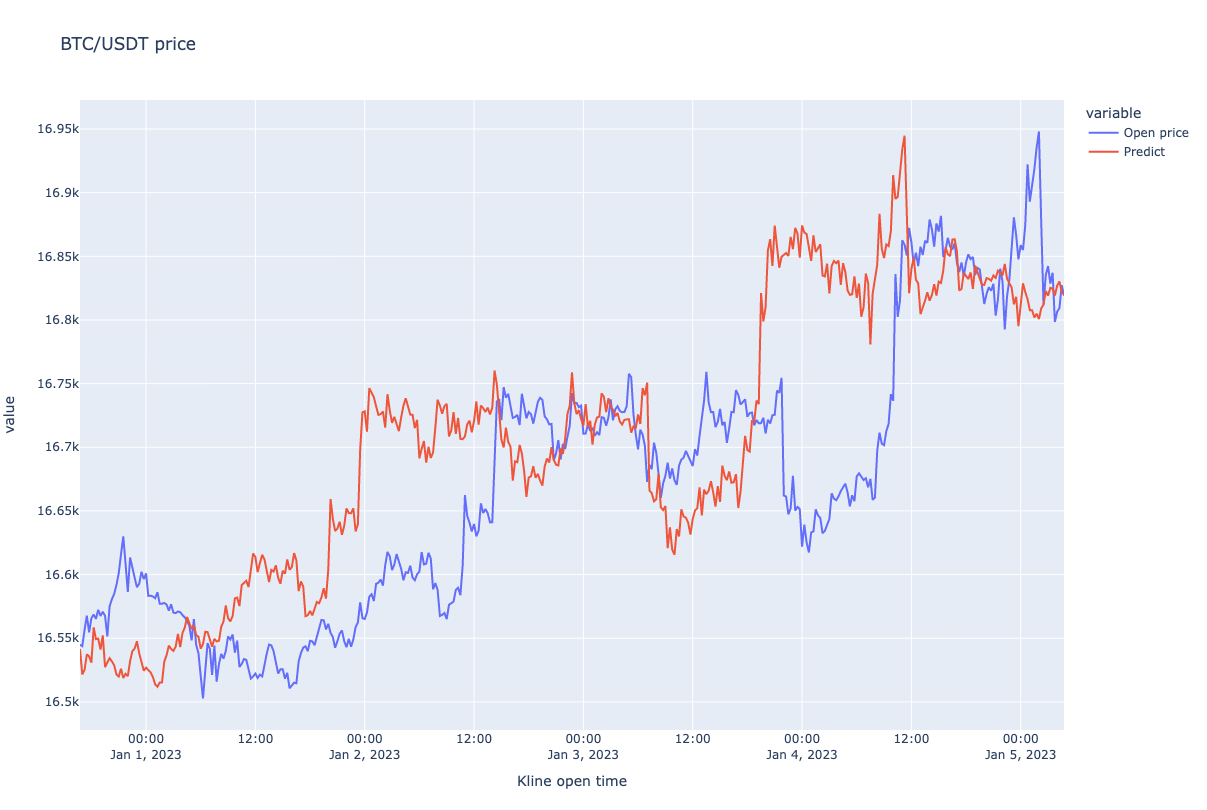

In [133]:
visualize_prediction(predictions)

## ➡️ Gated Recurrent Unit (GRU)

### 📌 Build model and train

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU 

In [135]:
model = Sequential()
model.add(GRU(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 22ms/step - loss: 0.0453
Epoch 2/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0036
Epoch 3/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 5/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 6/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 7/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0012
Epoch 8/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 9/10
32/32 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 10/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0011


### 📌 Predict and transform to the original scale

In [136]:
predictions = model.predict(X_valid)
predictions = scaler.inverse_transform(predictions)
predictions.shape

14/14 [==============================] - 0s 7ms/step


(433, 1)

### 📌 Visualize the prediction

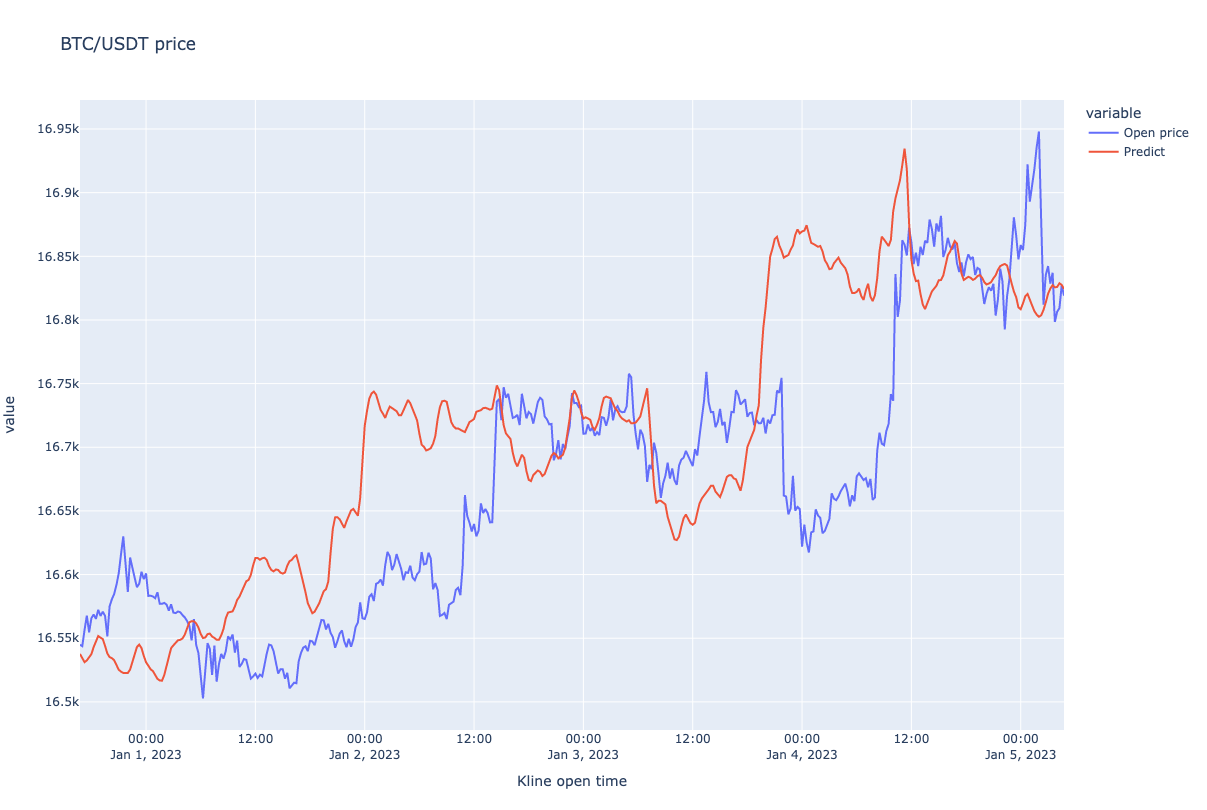

In [137]:
visualize_prediction(predictions)

## ➡️ Seasonal Auto Regressive Integrated Moving Average (SARIMAX)

In [120]:
from statsmodels.tsa.api import SARIMAX

### 📌 Prepare train-valid set again 

In [121]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
SARIMAX_train, SARIMAX_test = scaled_data[:TRAIN_VALID_LENGTH], scaled_data[TRAIN_VALID_LENGTH:TRAIN_TEST_LENGTH]
print(SARIMAX_train.shape,SARIMAX_test.shape)

(1007, 1) (433, 1)


### 📌 Build model and train

In [ ]:
predictions = list()
history = SARIMAX_train.tolist()
for t in range(SARIMAX_test.shape[0]):
    model = SARIMAX(history)
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    history.append(SARIMAX_test[t])

### 📌 Predict and transform to the original scale

In [123]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
predictions.shape

(433, 1)

### 📌 Visualize the prediction

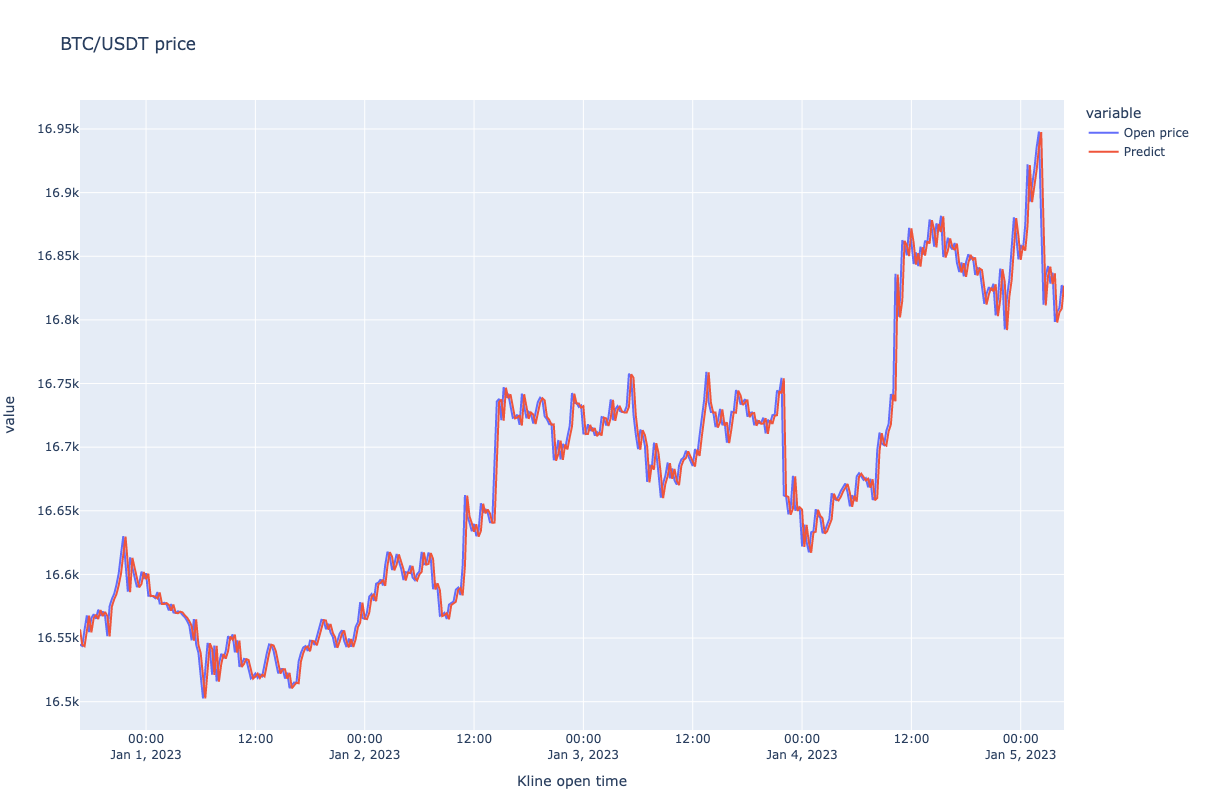

In [124]:
visualize_prediction(predictions)        

# 🎖 4. Model selection and evaluation

## ➡️ Naive cross validation to select model

In [139]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from estimator import LSTMEstimator, SarimaxEstimator, LinearRegressionEstimator

# cross vadiation strategy
tscv = TimeSeriesSplit(n_splits=3)

# mean squared error metric
metric = make_scorer(r2_score)

# models
estimators = [
    SarimaxEstimator(), 
    LinearRegressionEstimator(),
    LSTMEstimator(), 
]

scores_dict = {}

for estimator in estimators:
    scores = cross_val_score(estimator, X_origin_train, Y_origin_train, scoring=metric, cv=tscv, n_jobs=-1)
    print(estimator.__class__.__name__, scores.mean())
    scores_dict[estimator.__class__.__name__] = scores
    
scores_df = pd.DataFrame(scores_dict)
scores_df.index = scores_df.index.map(lambda x: f'fold_{x+1}')
scores_df.loc['mean'] = scores_df.mean()

2023-01-08 22:55:34.706055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 22:55:34.706590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 22:55:34.706592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, reb

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23668D+00    |proj g|=  4.41790D+00
RUNNING THE L-BFGS-B CODE

RUNNING THE L-BFGS-B CODE
           * * *


           * * *

Machine precision = 2.220D-16
 N =            8     M =           10
Machine precision = 2.220D-16

 N =            8     M =           10
At X0         0 variables are exactly at the bounds

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19307D+00    |proj g|=  1.80333D+01

At iterate    0    f= -2.26041D+00    |proj g|=  1.10428D+01

At iterate    5    f= -1.26057D+00    |proj g|=  2.94678D-01

At iterate    5    f= -2.23194D+00    |proj g|=  2.64033D-01

At iterate   10    f= -1.28691D+00    |proj g|=  2.54123D+00

At iterate    5    f= -2.26983D+00    |proj g|=  1.19612D+00

At iterate   10    f= -2.25381D+00    |proj g|=  1.30211D+01

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.28655D+00    |proj g|=  9.37543D-01

At iterate   45    f= -1.31814D+00    |proj g|=  1.08231D-01

At iterate   50    f= -1.31898D+00    |proj g|=  7.07063D-02


           * * *

At iterate   40    f= -2.28664D+00    |proj g|=  1.25179D-01
Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   7.071D-02  -1.319D+00
  F =  -1.3189836202190164     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -2.30975D+00    |proj g|=  1.38629D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.27769D+00    |proj g|=  4.44107D-01

At iterate   30    f= -1.29632D+00    |proj g|=  5.34346D-02

At iterate   15    f= -2.27869D+00    |proj g|=  2.42303D+00

At iterate   35    f= -1.30412D+00    |proj g|=  2.35801D-01

At iterate   20    f= -2.29322D+00    |proj g|=  4.72539D-01

At iterate   25    f= -2.29406D+00    |proj g|=  1.07906D+00

At iterate   40    f= -1.31543D+00    |proj g|=  1.31837D-01

At iterate   30    f= -2.29575D+00    |proj g|=  6.71662D-02

At iterate   45    f= -1.32280D+00    |proj g|=  1.66586D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48    128   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.07207D+00    |proj g|=  1.04971D+00

At iterate   10    f= -2.24984D+00    |proj g|=  1.94043D+00

At iterate   10    f= -1.16844D+00    |proj g|=  2.20252D+00

At iterate   45    f= -2.29604D+00    |proj g|=  7.57950D-01

At iterate   15    f= -2.26460D+00    |proj g|=  3.39743D-01

At iterate   15    f= -1.22073D+00    |proj g|=  3.42083D+00

At iterate   50    f= -2.29616D+00    |proj g|=  2.25682D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   2.257D-01  -2.296D+00
  F =  -2.2961553351462372     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f= -2.28024D+00    |proj g|=  7.63121D+00

At iterate   35    f= -1.26443D+00    |proj g|=  3.65846D-02

At iterate   40    f= -2.30277D+00    |proj g|=  4.82708D-01

At iterate   20    f= -2.29959D+00    |proj g|=  3.41920D-01

At iterate   45    f= -2.30470D+00    |proj g|=  6.14832D-01

At iterate   40    f= -1.26444D+00    |proj g|=  7.54068D-03

At iterate   25    f= -2.30024D+00    |proj g|=  3.40349D-01

At iterate   50    f= -2.30819D+00    |proj g|=  3.35670D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75      1     0     0   3.357D-01  -2.308D+00
  F =  -2.30818510323

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.32614D+00    |proj g|=  1.41740D+00

At iterate   40    f= -2.30261D+00    |proj g|=  1.88767D-01
  ys=-2.032E-07  -gs= 6.990E-07 BFGS update SKIPPED

At iterate   15    f= -1.32974D+00    |proj g|=  4.34129D-02

At iterate   20    f= -2.21821D+00    |proj g|=  2.18984D-01

At iterate   20    f= -1.33067D+00    |proj g|=  6.72257D-02

At iterate   25    f= -2.22148D+00    |proj g|=  3.46126D-01

At iterate   25    f= -1.33089D+00    |proj g|=  3.72266D-02
  ys=-7.867E-06  -gs= 3.673E-06 BFGS update SKIPPED

At iterate   30    f= -1.33240D+00    |proj g|=  2.60221D-01

At iterate   30    f= -2.22151D+00    |proj g|=  1.63351D-01

At iterate   35    f= -1.33269D+00    |proj g|=  1.85927D-01
  ys=-2.859E-10  -gs= 2.274E-09 BFGS update SKIPPED

At iterate   40    f= -1.33527D+00    |proj g|=  8.47756D-02

At iterate   35    f= -2.22483D+00    |proj g|=  2.81943D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f= -1.33698D+00    |proj g|=  5.88984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43    106      2     2     0   1.497D-02  -2.303D+00
  F =  -2.3026160172073946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   40    f= -2.22859D+00    |proj g|=  4.52788D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22008D+00    |proj g|=  1.49341D+01

At iterate    5    f= -2.24332D+00    |proj g|=  1.32246D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.32904D+00    |proj g|=  5.76270D-01

At iterate   10    f= -2.20859D+00    |proj g|=  1.01723D+01

At iterate   30    f= -2.29506D+00    |proj g|=  7.59440D-01

At iterate   15    f= -1.33541D+00    |proj g|=  1.27828D-02

At iterate   15    f= -2.21845D+00    |proj g|=  4.28530D-02

At iterate   35    f= -2.29724D+00    |proj g|=  7.99700D-01

At iterate   20    f= -1.33576D+00    |proj g|=  3.60282D-01

At iterate   40    f= -2.29779D+00    |proj g|=  5.20223D-01

At iterate   20    f= -2.22374D+00    |proj g|=  9.87894D-02

At iterate   25    f= -1.33599D+00    |proj g|=  4.59348D-02

At iterate   30    f= -1.33678D+00    |proj g|=  1.32259D-01

At iterate   45    f= -2.29800D+00    |proj g|=  1.44997D-01

At iterate   25    f= -2.22380D+00    |proj g|=  6.16967D-01

At iterate   35    f= -1.33894D+00    |proj g|=  7.05957D-02

At iterate   50    f= -2.29847D+00    |proj g|=  2.62503D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.33386D+00    |proj g|=  3.14859D-02

At iterate   50    f= -2.22599D+00    |proj g|=  3.48723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     97      1     0     0   3.487D-02  -2.226D+00
  F =  -2.2259929676803312     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -2.30274D+00    |proj g|=  1.24498D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17456D+00    |proj g|=  6.92273D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.21800D+00    |proj g|=  1.61033D+01

At iterate   45    f= -1.33945D+00    |proj g|=  2.87014D-02

At iterate   25    f= -2.21946D+00    |proj g|=  2.09325D+00

At iterate    5    f= -2.24542D+00    |proj g|=  1.64107D-01

At iterate   10    f= -2.24711D+00    |proj g|=  5.54051D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     74      1     0     0   5.839D-02  -1.340D+00
  F =  -1.3400756026645233     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.29264D+00    |proj g|=  1.67851D+00

At iterate   20    f= -1.32880D+00    |proj g|=  3.16644D-03

At iterate   45    f= -2.22487D+00    |proj g|=  2.15883D-01

At iterate   35    f= -2.29510D+00    |proj g|=  4.89453D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     35      1     0     0   4.993D-03  -1.329D+00
  F =  -1.3288000732501131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f= -2.22516D+00    |proj g|=  4.63640D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.19766D+00    |proj g|=  9.33909D-01

At iterate   25    f= -1.30229D+00    |proj g|=  1.86191D-01

At iterate    5    f= -2.27000D+00    |proj g|=  5.62225D+00

At iterate   25    f= -2.19911D+00    |proj g|=  3.13047D-01

At iterate   30    f= -1.30302D+00    |proj g|=  2.07775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7     26      1     0     0   1.141D-01  -2.272D+00
  F =  -2.2722446412463828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   35    f= -1.30516D+00    |proj g|=  7.41895D-03
  ys=-3.012E-09  -gs= 9.995E-09 BFGS update SKIPPED

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -2.26578D+00    |proj g|=  7.51150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     63      1     1     0   2.323D-01  -2.199D+00
  F =  -2.1992828933074282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -2.26714D+00    |proj g|=  1.15821D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15180D+00    |proj g|=  3.19522D+00

At iterate   25    f= -2.26950D+00    |proj g|=  1.92232D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.29543D+00    |proj g|=  1.82691D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12234D+00    |proj g|=  1.89366D+00

At iterate   15    f= -2.19297D+00    |proj g|=  5.19724D-01

At iterate   20    f= -2.19627D+00    |proj g|=  4.33744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     33      1     0     0   4.337D-02  -2.196D+00
  F =  -2.1962720012282544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.17058D+00    |proj g|=  7.82282D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26572D+00    |proj g|=  1.80773D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16815D+00    |proj g|=  3.37371D+00

At iterate   15    f= -1.21628D+00    |proj g|=  1.63754D+00

At iterate    5    f= -2.29616D+00    |proj g|=  1.26344D-01

At iterate    5    f= -2.16919D+00    |proj g|=  1.27181D+00

At iterate   20    f= -1.22447D+00    |proj g|=  2.76502D-01

At iterate   10    f= -2.30218D+00    |proj g|=  8.26776D+00

At iterate   10    f= -2.20121D+00    |proj g|=  9.10714D+00

At iterate   25    f= -1.23222D+00    |proj g|=  1.95663D-01

At iterate   15    f= -2.31203D+00    |proj g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.23083D+00    |proj g|=  3.38414D-01

At iterate   15    f= -2.16340D+00    |proj g|=  1.39049D-01

At iterate   50    f= -2.31798D+00    |proj g|=  1.20477D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     96      1     0     0   1.205D+00  -2.318D+00
  F =  -2.3179759401921811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.24402D+00    |proj g|=  1.08629D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.32457D+00    |proj g|=  2.18292D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12925D+00    |proj g|=  3.35675D+00

At iterate   20    f= -1.25115D+00    |proj g|=  8.98763D-02

At iterate   30    f= -2.33244D+00    |proj g|=  1.36067D-01

At iterate    5    f= -2.13035D+00    |proj g|=  8.36599D-01

At iterate   25    f= -1.25213D+00    |proj g|=  4.88377D-03

At iterate   10    f= -2.14508D+00    |proj g|=  1.22645D+01

At iterate   30    f= -1.25215D+00    |proj g|=  1.11655D-03

At iterate   15    f= -2.16279D+00    |proj g|=  2.04674D-01

At iterate   35    f= -2.33251D+00    |proj g|=  5.27858D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.24892D+00    |proj g|=  1.64932D-02

At iterate   35    f= -2.18009D+00    |proj g|=  5.71989D-02

At iterate   50    f= -2.33371D+00    |proj g|=  7.75835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   7.758D-02  -2.334D+00
  F =  -2.3337110390337483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.25149D+00    |proj g|=  1.46856D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.32887D+00    |proj g|=  2.51404D-01

At iterate    5    f= -2.13525D+00    |proj g|=  1.39474D+00

At iterate   10    f= -2.15320D+00    |proj g|=  8.05714D+00

At iterate   50    f= -1.25225D+00    |proj g|=  3.02049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   3.020D-03  -1.252D+00
  F =  -1.2522523831789760     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -2.32954D+00    |proj g|=  6.05305D-01

At iterate   15    f= -2.15800D+00    |proj g|=  7.53713D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.18905D+00    |proj g|=  1.01198D+00
  ys=-2.415E-08  -gs= 2.904E-06 BFGS update SKIPPED

At iterate    5    f= -1.23064D+00    |proj g|=  4.74909D-01

At iterate   30    f= -2.19115D+00    |proj g|=  1.55443D-01

At iterate   10    f= -1.23979D+00    |proj g|=  1.29603D-01

At iterate   15    f= -1.24039D+00    |proj g|=  1.28601D-01

At iterate   15    f= -2.35665D+00    |proj g|=  4.73506D-02

At iterate   35    f= -2.19118D+00    |proj g|=  1.82944D-01

At iterate   20    f= -2.35950D+00    |proj g|=  1.95601D+00

At iterate   20    f= -1.24113D+00    |proj g|=  1.82134D-02

At iterate   40    f= -2.19135D+00    |proj g|=  3.73863D-01

At iterate   25    f= -2.36144D+00    |proj g|=  3.67337D-02

At iterate   25    f= -1.24198D+00    |proj g|=  1.20763D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -2.19146D+00    |proj g|=  3.52270D-02

At iterate   30    f= -2.36269D+00    |proj g|=  2.25260D-02

At iterate   35    f= -2.36280D+00    |proj g|=  4.97203D-02

At iterate   30    f= -1.24402D+00    |proj g|=  2.34201D-01

At iterate   35    f= -1.24661D+00    |proj g|=  1.11999D-01

At iterate   40    f= -2.36284D+00    |proj g|=  4.53637D-02

At iterate   40    f= -1.24664D+00    |proj g|=  7.94877D-02

At iterate   45    f= -1.24666D+00    |proj g|=  9.40039D-03

At iterate   50    f= -1.24667D+00    |proj g|=  1.84271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23056D+00    |proj g|=  1.67258D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28955D+00    |proj g|=  1.69407D+01

At iterate    5    f= -1.23357D+00    |proj g|=  3.64341D-01

At iterate    5    f= -2.31423D+00    |proj g|=  1.57688D-01

At iterate   10    f= -2.31653D+00    |proj g|=  5.19039D+00

At iterate   10    f= -1.24414D+00    |proj g|=  6.20809D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.04929D+00    |proj g|=  7.31266D+00

At iterate   10    f= -2.32590D+00    |proj g|=  6.11247D+00

At iterate   40    f= -1.25008D+00    |proj g|=  1.16342D-01

At iterate   15    f= -2.36289D+00    |proj g|=  3.02849D+00

At iterate   40    f= -2.09216D+00    |proj g|=  5.34351D-01

At iterate   20    f= -2.36381D+00    |proj g|=  1.52263D-01

At iterate   45    f= -2.10168D+00    |proj g|=  2.82047D+00

At iterate   45    f= -1.25011D+00    |proj g|=  3.00806D-03

At iterate   25    f= -2.36391D+00    |proj g|=  3.61757D-01

At iterate   50    f= -2.10676D+00    |proj g|=  1.14909D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -2.20450D+00    |proj g|=  4.32916D-01

At iterate   20    f= -1.24532D+00    |proj g|=  5.32120D-02

At iterate   50    f= -2.20473D+00    |proj g|=  1.64653D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   1.647D-01  -2.205D+00
  F =  -2.2047285757052104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.24544D+00    |proj g|=  8.45088D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -2.32599D+00    |proj g|=  6.46260D+00

At iterate   20    f= -2.17268D+00    |proj g|=  3.71835D+00

At iterate   15    f= -2.37451D+00    |proj g|=  2.45236D+00

At iterate   25    f= -2.17708D+00    |proj g|=  5.01415D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     74      1     0     0   1.160D-02  -1.248D+00
  F =  -1.2482262091482865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   30    f= -2.17752D+00    |proj g|=  1.97193D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -2.18648D+00    |proj g|=  1.08975D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      1     1     0   1.090D-01  -2.186D+00
  F =  -2.1864798859479735     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.25248D+00    |proj g|=  3.88605D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06343D+00    |proj g|=  1.42991D+01

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f= -1.25443D+00    |proj g|=  7.19108D-03

At iterate   30    f= -2.19389D+00    |proj g|=  5.26136D-01

At iterate   50    f= -1.25445D+00    |proj g|=  4.69961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     81      2     0     0   4.700D-03  -1.254D+00
  F =  -1.2544464807971931     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27801D+00    |proj g|=  7.42812D-01

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -2.10605D+00    |proj g|=  5.74771D+00

At iterate    5    f= -1.28415D+00    |proj g|=  4.96370D-02

At iterate   40    f= -2.36921D+00    |proj g|=  1.96564D-01

At iterate   15    f= -2.12009D+00    |proj g|=  1.40426D-01

At iterate   10    f= -1.28482D+00    |proj g|=  1.60585D-02

At iterate   20    f= -2.15359D+00    |proj g|=  3.27590D+00

At iterate   15    f= -1.28491D+00    |proj g|=  8.77927D-02

At iterate   45    f= -2.36936D+00    |proj g|=  7.67492D-01

At iterate   25    f= -2.15591D+00    |proj g|=  3.48053D-01

At iterate   20    f= -1.28494D+00    |proj g|=  4.98429D-02

At iterate   30    f= -2.16322D+00    |proj g|=  2.35705D-01

At iterate   25    f= -1.28504D+00    |proj g|=  4.38354D-02

At iterate   50    f= -2.36953D+00    |proj g|=  3.83141D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.35056D+00    |proj g|=  8.06877D-01

At iterate   45    f= -2.18316D+00    |proj g|=  1.02470D+00

At iterate   40    f= -1.28514D+00    |proj g|=  1.64897D-02

At iterate   10    f= -2.36020D+00    |proj g|=  9.82487D+00

At iterate   50    f= -2.18566D+00    |proj g|=  1.51490D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   1.515D+00  -2.186D+00
  F =  -2.1856552450969997     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -1.28516D+00    |proj g|=  2.47872D-02

At iterate   15    f= -2.37490D+00    |proj g|=  7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.98559D+00    |proj g|=  7.90593D+00

At iterate   20    f= -1.28554D+00    |proj g|=  3.00363D-02

At iterate   20    f= -2.37540D+00    |proj g|=  2.53190D+00

At iterate   25    f= -2.02374D+00    |proj g|=  3.78956D+00

At iterate   25    f= -2.38013D+00    |proj g|=  1.19193D-01

At iterate   25    f= -1.28557D+00    |proj g|=  1.06456D-02

At iterate   30    f= -1.28560D+00    |proj g|=  2.91438D-02

At iterate   30    f= -2.04292D+00    |proj g|=  3.88987D-01
  ys=-1.220E-10  -gs= 1.056E-09 BFGS update SKIPPED

At iterate   35    f= -2.04361D+00    |proj g|=  1.03268D+00

At iterate   35    f= -1.28563D+00    |proj g|=  5.91868D-03

At iterate   40    f= -2.04702D+00    |proj g|=  2.98246D-01

At iterate   40    f= -1.28571D+00    |proj g|=  2.43796D-02

At iterate   45    f= -1.28576D+00    |proj g|=  8.87752D-03

At iterate   45    f= -2.05457D+00    |proj g|=  7.38153D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.07830D+00    |proj g|=  1.54457D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   1.545D+00  -2.078D+00
  F =  -2.0783028950232025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35519D+00    |proj g|=  1.00292D+01

At iterate   30    f= -1.38717D+00    |proj g|=  1.05456D-01

At iterate   30    f= -2.19878D+00    |proj g|=  9.17372D-01

At iterate   35    f= -1.39160D+00    |proj g|=  9.82626D-02

At iterate   40    f= -1.39189D+00    |proj g|=  2.56960D-01

At iterate   35    f= -2.20094D+00    |proj g|=  1.45075D+00

At iterate    5    f= -2.36085D+00    |proj g|=  3.20076D-01

At iterate   45    f= -1.39202D+00    |proj g|=  5.72054D-02

At iterate   10    f= -2.36383D+00    |proj g|=  9.61147D+00

At iterate   40    f= -2.21021D+00    |proj g|=  2.30945D-01

At iterate   50    f= -1.39209D+00    |proj g|=  7.50529D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   45    f= -1.39659D+00    |proj g|=  3.72288D-02

At iterate   35    f= -2.18080D+00    |proj g|=  2.10989D+00
  ys=-5.682E-05  -gs= 1.094E-04 BFGS update SKIPPED

At iterate   50    f= -1.39673D+00    |proj g|=  1.57157D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.572D-01  -1.397D+00
  F =  -1.3967344795977510     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -2.38769D+00    |proj g|=  1.08403D+00

At iterate   40    f= -2.19285D+00    |proj g|=  9.05942D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.45030D+00    |proj g|=  1.84140D-01

At iterate   15    f= -2.11950D+00    |proj g|=  8.56718D-02

At iterate   35    f= -1.45128D+00    |proj g|=  3.45774D-02

At iterate   20    f= -2.14576D+00    |proj g|=  7.62985D+00

At iterate   40    f= -1.45362D+00    |proj g|=  4.71651D-01

At iterate   25    f= -2.15150D+00    |proj g|=  2.94119D-01

At iterate   30    f= -2.15596D+00    |proj g|=  9.89822D-01

At iterate   45    f= -1.45383D+00    |proj g|=  5.06622D-02

At iterate   35    f= -2.16483D+00    |proj g|=  1.28353D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44    154   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.33071D+00    |proj g|=  3.48376D+00

At iterate   10    f= -2.37113D+00    |proj g|=  2.22780D+00

At iterate   45    f= -2.16572D+00    |proj g|=  2.21408D-01

At iterate    5    f= -1.41295D+00    |proj g|=  5.59048D-01

At iterate   15    f= -2.37157D+00    |proj g|=  8.00220D-01

At iterate   50    f= -2.16599D+00    |proj g|=  3.78675D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   3.787D-01  -2.166D+00
  F =  -2.1659930631586501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f= -2.08314D+00    |proj g|=  1.68101D+00

At iterate   30    f= -1.45323D+00    |proj g|=  6.11099D-01

At iterate   25    f= -2.11335D+00    |proj g|=  6.73668D-02

At iterate   35    f= -1.45820D+00    |proj g|=  2.71167D-02

At iterate   30    f= -2.37418D+00    |proj g|=  1.74096D-01

At iterate   40    f= -1.45961D+00    |proj g|=  3.23915D-01

At iterate   30    f= -2.11792D+00    |proj g|=  1.27583D+00

At iterate   35    f= -2.37643D+00    |proj g|=  3.00944D+00

At iterate   45    f= -1.46029D+00    |proj g|=  8.88565D-02

At iterate   35    f= -2.12281D+00    |proj g|=  7.20483D-01

At iterate   40    f= -2.37800D+00    |proj g|=  2.21029D+00

At iterate   50    f= -1.46067D+00    |proj g|=  1.20794D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.47980D+00    |proj g|=  1.02197D-01

At iterate   45    f= -2.37960D+00    |proj g|=  5.94108D-01

At iterate   10    f= -1.48435D+00    |proj g|=  2.50078D+00

At iterate   15    f= -1.49192D+00    |proj g|=  1.93877D-01

At iterate   45    f= -2.12308D+00    |proj g|=  1.59848D-01

At iterate   20    f= -1.49851D+00    |proj g|=  1.39620D-01

At iterate   25    f= -1.50436D+00    |proj g|=  3.47896D-02

At iterate   30    f= -1.50989D+00    |proj g|=  2.29412D-02

At iterate   50    f= -2.12335D+00    |proj g|=  1.19156D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -2.08283D+00    |proj g|=  2.30028D+00

At iterate   45    f= -1.51082D+00    |proj g|=  7.71059D-02

At iterate    5    f= -2.32444D+00    |proj g|=  1.94085D+00

At iterate   15    f= -2.08416D+00    |proj g|=  2.83774D+00

At iterate   50    f= -1.51086D+00    |proj g|=  8.13083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   8.131D-02  -1.511D+00
  F =  -1.5108586777893616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -2.37466D+00    |proj g|=  1.76609D+00

At iterate   20    f= -2.10619D+00    |proj g|=  4

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.48570D+00    |proj g|=  2.89431D+00

At iterate   15    f= -1.49683D+00    |proj g|=  6.04834D-01

At iterate   45    f= -2.12051D+00    |proj g|=  8.96050D-01

At iterate   20    f= -1.49942D+00    |proj g|=  8.10491D-01

At iterate   50    f= -2.12111D+00    |proj g|=  1.23888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    122      3     1     0   1.239D-02  -2.121D+00
  F =  -2.1211056962103223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.51045D+00    |proj g|=  2.76512D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00530D+00    |proj g|=  3.14182D+00

At iterate    5    f= -1.48510D+00    |proj g|=  9.54866D-02

At iterate   45    f= -2.46634D+00    |proj g|=  8.55720D-01

At iterate   10    f= -1.48967D+00    |proj g|=  2.66613D+00

At iterate    5    f= -2.00690D+00    |proj g|=  1.51594D+00

At iterate   15    f= -1.50152D+00    |proj g|=  3.81826D-02

At iterate   50    f= -2.46672D+00    |proj g|=  9.82919D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.96207D+00    |proj g|=  1.34344D+00

At iterate    5    f= -2.41141D+00    |proj g|=  2.70740D+00

At iterate   15    f= -1.41779D+00    |proj g|=  2.07545D-01

At iterate   20    f= -1.44099D+00    |proj g|=  4.70343D-01

At iterate   25    f= -1.44282D+00    |proj g|=  6.79007D-01

At iterate    5    f= -1.99076D+00    |proj g|=  1.16527D+01

At iterate   10    f= -2.44052D+00    |proj g|=  2.25420D+00

At iterate   10    f= -2.02264D+00    |proj g|=  1.74922D-01

At iterate   30    f= -1.45573D+00    |proj g|=  1.10999D-01

At iterate   15    f= -2.44083D+00    |proj g|=  1.28102D+00

At iterate   15    f= -2.02581D+00    |proj g|=  3.71607D+00

At iterate   35    f= -1.50112D+00    |proj g|=  3.91504D+00

At iterate   20    f= -2.03879D+00    |proj g|=  5.99306D-01

At iterate   40    f= -1.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.45667D+00    |proj g|=  1.99374D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75      1     0     0   1.994D-01  -2.457D+00
  F =  -2.4566731491328797     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -2.00065D+00    |proj g|=  3.48627D+00

At iterate   30    f= -1.53279D+00    |proj g|=  1.97147D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38716D+00    |proj g|=  8.22685D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.51911D+00    |proj g|=  1.78775D-01

At iterate   50    f= -2.05861D+00    |proj g|=  6.80519D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   6.805D-01  -2.059D+00
  F =  -2.0586085021431275     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -2.47214D+00    |proj g|=  8.31296D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.01305D+00    |proj g|=  3.71531D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.48608D+00    |proj g|=  3.16055D+00

At iterate   25    f= -2.48635D+00    |proj g|=  8.72923D-01

At iterate   15    f= -1.49342D+00    |proj g|=  7.64519D-01

At iterate   20    f= -1.49966D+00    |proj g|=  1.39941D-01

At iterate   30    f= -2.04469D+00    |proj g|=  6.17239D-01

At iterate   25    f= -1.50495D+00    |proj g|=  2.29262D-01

At iterate   35    f= -2.04595D+00    |proj g|=  1.69751D+00

At iterate   30    f= -1.51615D+00    |proj g|=  2.89773D-01

At iterate   40    f= -2.04771D+00    |proj g|=  1.73321D-01

At iterate   35    f= -1.52131D+00    |proj g|=  2.01512D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.52366D+00    |proj g|=  1.42100D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.421D-01  -1.524D+00
  F =  -1.5236634173309971     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -2.42452D+00    |proj g|=  1.44394D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37828D+00    |proj g|=  1.93257D+00

At iterate    5    f= -2.03244D+00    |proj g|=  3.75401D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.45794D+00    |proj g|=  2.02435D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     83      1     0     0   3.805D-01  -2.061D+00
  F =  -2.0609177044187073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   40    f= -1.48667D+00    |proj g|=  4.56051D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03363D+00    |proj g|=  4.64936D+00

At iterate   10    f= -2.47056D+00    |proj g|=  7.11649D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.05988D+00    |proj g|=  2.65463D+00

At iterate   45    f= -1.47694D+00    |proj g|=  2.98920D-02

At iterate   25    f= -2.06740D+00    |proj g|=  4.06119D-01

At iterate   50    f= -1.47695D+00    |proj g|=  7.34908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     77      1     0     0   7.349D-02  -1.477D+00
  F =  -1.4769504735411916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -2.51144D+00    |proj g|=  5.45284D-02
  ys=-8.664E-11  -gs= 4.669E-10 BFGS update SKIPPED

At iterate   30    f= -2.06886D+00    |proj g|=  2.85377D-01

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   20    f= -1.47027D+00    |proj g|=  3.44024D-02

At iterate   50    f= -2.08755D+00    |proj g|=  2.18862D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   2.189D-01  -2.088D+00
  F =  -2.0875535431248782     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -2.51208D+00    |proj g|=  1.63484D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03758D+00    |proj g|=  1.74564D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.46932D+00    |proj g|=  3.22621D-02

At iterate   15    f= -2.50566D+00    |proj g|=  2.53204D-01

At iterate   35    f= -2.08067D+00    |proj g|=  8.92413D-01

At iterate   20    f= -1.48039D+00    |proj g|=  4.13594D-02

At iterate   40    f= -2.08166D+00    |proj g|=  1.15597D-01

At iterate   20    f= -2.50752D+00    |proj g|=  5.45122D-01

At iterate   45    f= -2.08170D+00    |proj g|=  1.07332D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     65      1     0     0   1.073D-01  -2.082D+00
  F =  -2.0816980213937977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.48117D+00    |proj g|=  3.17703D-01

At iterate   30    f= -1.48266D+00    |proj g|=  3.20130D-02

At iterate   30    f= -2.50947D+00    |proj g|=  7.34015D+00

At iterate   35    f= -1.48268D+00    |proj g|=  1.20668D-02

At iterate   35    f= -2.51741D+00    |proj g|=  5.35530D-02

At iterate   15    f= -2.05675D+00    |proj g|=  4.09749D-01

At iterate   20    f= -2.05901D+00    |proj g|=  3.26400D-01

At iterate   40    f= -2.51744D+00    |proj g|=  9.88176D-02

At iterate   25    f= -2.06763D+00    |proj g|=  2.08482D+00

At iterate   30    f= -2.07431D+00    |proj g|=  1.11584D-01

At iterate   45    f= -2.51749D+00    |proj g|=  7.30491D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.08151D+00    |proj g|=  6.44283D-01

At iterate   40    f= -1.48269D+00    |proj g|=  2.89194D-02

At iterate   50    f= -2.51791D+00    |proj g|=  1.70069D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    103      2     0     0   1.701D+00  -2.518D+00
  F =  -2.5179107044431004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.50532D+00    |proj g|=  1.80771D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.00763D+00    |proj g|=  2.24174D+00

At iterate   25    f= -1.47938D+00    |proj g|=  2.91636D-02

At iterate   15    f= -2.56284D+00    |proj g|=  4.89282D+00

At iterate   10    f= -2.03477D+00    |proj g|=  3.06270D+00

At iterate   20    f= -2.57131D+00    |proj g|=  1.85277D+00

At iterate   30    f= -1.48281D+00    |proj g|=  4.82445D-01

At iterate   15    f= -2.03986D+00    |proj g|=  2.46010D+00

At iterate   35    f= -1.48477D+00    |proj g|=  3.65967D-02

At iterate   25    f= -2.57395D+00    |proj g|=  4.89000D-01

At iterate   20    f= -2.04088D+00    |proj g|=  9.57969D-02

At iterate   40    f= -1.48554D+00    |proj g|=  1.55260D-01

At iterate   25    f= -2.04480D+00    |proj g|=  3.99687D-02

At iterate   30    f= -2.57405D+00    |proj g|=  1.74497D-01

At iterate   45    f= -1.48564D+00    |proj g|=  1.01720D-01

At iterate   35    f= -2.57828D+00    |proj g|=  6.07774D-02

At iterate   30    f= -2.04538D+00    |proj g|=  7.39211D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -2.04662D+00    |proj g|=  1.26795D+00

At iterate    5    f= -1.43990D+00    |proj g|=  1.13036D+00

At iterate   40    f= -2.05185D+00    |proj g|=  5.83301D-01

At iterate   10    f= -1.47261D+00    |proj g|=  2.01129D-01

At iterate   45    f= -2.58250D+00    |proj g|=  1.15505D+00

At iterate   15    f= -1.47874D+00    |proj g|=  7.62541D-01

At iterate   50    f= -2.58379D+00    |proj g|=  1.20850D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     90      1     0     0   1.209D+00  -2.584D+00
  F =  -2.5837867557481613     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   45    f= -2.40089D+00    |proj g|=  6.89027D-01

At iterate   30    f= -1.86401D+00    |proj g|=  3.30026D-02

At iterate   50    f= -2.40125D+00    |proj g|=  4.86985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   4.870D-02  -2.401D+00
  F =  -2.4012512560022072     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.48759D+00    |proj g|=  7.43945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = num

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.40130D+00    |proj g|=  1.66454D+00

At iterate   25    f= -1.48492D+00    |proj g|=  4.92599D-02

At iterate    5    f= -1.80861D+00    |proj g|=  3.12115D+00

At iterate   30    f= -1.48751D+00    |proj g|=  4.19945D-01

At iterate   25    f= -2.40285D+00    |proj g|=  3.06333D-01

At iterate   10    f= -1.86235D+00    |proj g|=  1.95309D+00

At iterate   35    f= -1.48835D+00    |proj g|=  4.56528D-01

At iterate   30    f= -2.40963D+00    |proj g|=  6.34520D-02

At iterate   15    f= -1.86805D+00    |proj g|=  1.29549D-01

At iterate   40    f= -1.48880D+00    |proj g|=  2.40460D-02

At iterate   35    f= -2.41173D+00    |proj g|=  9.53122D-02

At iterate   20    f= -1.86868D+00    |proj g|=  7.39281D-02

At iterate   45    f= -1.48880D+00    |proj g|=  1.80513D-02

At iterate   40    f= -2.41654D+00    |proj g|=  1.62173D-01

At iterate   25    f= -1.86937D+00    |proj g|=  2.03866D-02

At iterate   45    f= -2.41723D+00    |proj g|=  1.55859D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.81138D+00    |proj g|=  2.84543D-01

At iterate   10    f= -1.82911D+00    |proj g|=  9.75711D+00

At iterate   15    f= -1.86718D+00    |proj g|=  1.35427D+00

At iterate   20    f= -1.86827D+00    |proj g|=  2.24012D-02

At iterate   25    f= -1.86851D+00    |proj g|=  1.59116D-01

At iterate   30    f= -1.86936D+00    |proj g|=  1.34934D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   35    f= -1.86946D+00    |proj g|=  6.05662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49    143      3     1     0   1.240D-02  -1.489D+00
  F =  -1.4888044642316316     

ABNORMAL_TERMINATION_IN_LNSRCH                              

At iterate   30    f= -2.41223D+00    |proj g|=  1.25084D-01

At iterate   40    f= -1.86952D+00    |proj g|=  2.82277D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41645D+00    |proj g|=  3.17301D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -1.51852D+00    |proj g|=  2.31398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     78      1     0     0   2.314D-02  -1.519D+00
  F =  -1.5185154958203533     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43190D+00    |proj g|=  3.01560D+00

At iterate   20    f= -2.36198D+00    |proj g|=  5.78000D-01

At iterate   25    f= -1.84545D+00    |proj g|=  4.22778D-01

At iter

 This problem is unconstrained.



At iterate   40    f= -2.36617D+00    |proj g|=  1.29397D-01

At iterate   35    f= -1.53566D+00    |proj g|=  3.35351D-01

At iterate   45    f= -1.84638D+00    |proj g|=  5.43128D-02

At iterate   40    f= -1.53585D+00    |proj g|=  6.20360D-02

At iterate   45    f= -2.36756D+00    |proj g|=  4.45601D-01

At iterate   50    f= -1.84649D+00    |proj g|=  7.96892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   7.969D-02  -1.846D+00
  F =  -1.8464898744850706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ys=-1.272E-05  -gs= 1.313E-05 BFGS update SKIPPED

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.84730D+00    |proj g|=  2.93201D-02

At iterate   15    f= -1.52955D+00    |proj g|=  5.18536D-01

At iterate   30    f= -1.84856D+00    |proj g|=  5.96104D-02

At iterate    5    f= -2.15954D+00    |proj g|=  2.57773D-01

At iterate   20    f= -1.53081D+00    |proj g|=  1.78505D-01

At iterate   10    f= -2.16276D+00    |proj g|=  8.72077D+00

At iterate   35    f= -1.84862D+00    |proj g|=  1.80206D-01

At iterate   15    f= -2.17720D+00    |proj g|=  9.11818D-01

At iterate   25    f= -1.53158D+00    |proj g|=  7.35940D-02

At iterate   40    f= -1.84873D+00    |proj g|=  6.37826D-02

At iterate   20    f= -2.18707D+00    |proj g|=  1.37544D+00

At iterate   45    f= -1.84874D+00    |proj g|=  8.30311D-02

At iterate   25    f= -2.27394D+00    |proj g|=  5.11972D-01

At iterate   30    f= -1.53159D+00    |proj g|=  7.13349D-03

At iterate   50    f= -1.84885D+00    |proj g|=  2.94091D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.79494D+00    |proj g|=  6.56689D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47163D+00    |proj g|=  3.40624D+00

At iterate   10    f= -1.81562D+00    |proj g|=  6.71306D+00

At iterate   40    f= -2.28048D+00    |proj g|=  6.97995D-02

At iterate   15    f= -1.82424D+00    |proj g|=  2.36116D-01

At iterate    5    f= -1.47835D+00    |proj g|=  1.17835D+00

At iterate   10    f= -1.52089D+00    |proj g|=  1.18116D+00

At iterate   20    f= -1.82642D+00    |proj g|=  2.63533D+00

At iterate   15    f= -1.52923D+00    |proj g|=  7.45301D-01

At iterate   25    f= -1.82949D+00    |proj g|=  2.67268D-02

At iterate   20    f= -1.54634D+00    |proj g|=  5.56718D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.83061D+00    |proj g|=  6.93156D-02

At iterate   35    f= -1.55543D+00    |proj g|=  1.64679D-01

At iterate   10    f= -2.29669D+00    |proj g|=  1.22819D+01

At iterate   40    f= -1.55553D+00    |proj g|=  6.70491D-02

At iterate   45    f= -1.55573D+00    |proj g|=  3.89177D-02

At iterate   15    f= -2.30287D+00    |proj g|=  1.31432D+00

At iterate   50    f= -1.55575D+00    |proj g|=  9.11836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   9.118D-02  -1.556D+00
  F =  -1.5557506681900795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.67506D+00    |proj g|=  7.56850D-01

At iterate   25    f= -1.80768D+00    |proj g|=  1.23063D-01

At iterate    5    f= -2.28287D+00    |proj g|=  3.43898D+00

At iterate   10    f= -2.29359D+00    |proj g|=  2.88059D-01

At iterate   20    f= -1.68431D+00    |proj g|=  4.69591D-02

At iterate   30    f= -1.80807D+00    |proj g|=  1.84815D-01

At iterate   25    f= -1.68746D+00    |proj g|=  9.46573D-02

At iterate   15    f= -2.29368D+00    |proj g|=  7.47089D-01

At iterate   35    f= -1.80819D+00    |proj g|=  2.34233D-01

At iterate   30    f= -1.69822D+00    |proj g|=  1.82258D-01

At iterate   20    f= -2.30630D+00    |proj g|=  1.23961D+00

At iterate   40    f= -1.81432D+00    |proj g|=  1.96833D-01

At iterate   35    f= -1.69867D+00    |proj g|=  6.62202D-02

At iterate   45    f= -1.81870D+00    |proj g|=  1.59882D-01

At iterate   50    f= -1.82445D+00    |proj g|=  5.48209D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.61196D+00    |proj g|=  3.69750D+00

At iterate   40    f= -1.69868D+00    |proj g|=  1.03882D-01

At iterate    5    f= -2.30565D+00    |proj g|=  3.05508D+00

At iterate   10    f= -1.73739D+00    |proj g|=  3.02402D+00

At iterate   10    f= -2.30948D+00    |proj g|=  4.71050D-02

At iterate   45    f= -1.69931D+00    |proj g|=  5.20188D-02

At iterate   15    f= -1.74013D+00    |proj g|=  1.33173D+00

At iterate   15    f= -2.31646D+00    |proj g|=  3.52799D-01

At iterate   20    f= -1.75575D+00    |proj g|=  5.34535D-01

At iterate   20    f= -2.31699D+00    |proj g|=  2.12656D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.76915D+00    |proj g|=  5.37182D+00

At iterate   45    f= -1.73901D+00    |proj g|=  2.22491D-01

At iterate   10    f= -2.26412D+00    |proj g|=  1.84016D-01

At iterate   10    f= -1.79382D+00    |proj g|=  3.77514D-02

At iterate   50    f= -1.73930D+00    |proj g|=  2.70222D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   2.702D-01  -1.739D+00
  F =  -1.7392969029667851     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -2.28086D+00    |proj g|=  3.92148D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.27063D+00    |proj g|=  1.95752D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64508D+00    |proj g|=  5.66076D+00

At iterate   25    f= -1.79247D+00    |proj g|=  8.25229D-02

At iterate   10    f= -2.29286D+00    |proj g|=  6.11329D+00

At iterate    5    f= -1.65691D+00    |proj g|=  8.40504D-01

At iterate   10    f= -1.68786D+00    |proj g|=  6.25616D+00

At iterate   15    f= -1.70644D+00    |proj g|=  6.04345D-01

At iterate   30    f= -1.79249D+00    |proj g|=  1.48038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.73045D+00    |proj g|=  6.50250D-01

At iterate   25    f= -2.29902D+00    |proj g|=  6.38539D-02

At iterate   15    f= -1.77410D+00    |proj g|=  1.68828D-01

At iterate   40    f= -1.73107D+00    |proj g|=  7.47163D-02

At iterate   30    f= -2.30002D+00    |proj g|=  8.50974D-01

At iterate   20    f= -1.77492D+00    |proj g|=  6.06951D-01

At iterate   45    f= -1.73164D+00    |proj g|=  2.02727D-01

At iterate   25    f= -1.77833D+00    |proj g|=  8.71227D-02

At iterate   35    f= -2.30061D+00    |proj g|=  2.15968D-01

At iterate   50    f= -1.73209D+00    |proj g|=  1.76640D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.73676D+00    |proj g|=  1.59214D-01

At iterate   50    f= -1.78783D+00    |proj g|=  4.62457D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   4.625D-02  -1.788D+00
  F =  -1.7878256313004337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -2.28411D+00    |proj g|=  3.72245D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69123D+00    |proj g|=  9.11870D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.72014D+00    |proj g|=  9.04170D-01

At iterate   50    f= -1.78816D+00    |proj g|=  1.65048D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.650D-01  -1.788D+00
  F =  -1.7881561946553231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.72293D+00    |proj g|=  1.02935D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53992D+00    |proj g|=  7.28944D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.60509D+00    |proj g|=  7.97816D-02

At iterate   45    f= -1.72634D+00    |proj g|=  5.55830D-02

At iterate   30    f= -1.60645D+00    |proj g|=  1.43167D-01

At iterate    5    f= -2.27480D+00    |proj g|=  3.82911D-01

At iterate   10    f= -2.27894D+00    |proj g|=  5.51219D+00

At iterate   35    f= -1.60669D+00    |proj g|=  5.49157D-02

At iterate   15    f= -2.28368D+00    |proj g|=  7.44670D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     53      1     0     0   5.536D-02  -1.607D+00
  F =  -1.6066862130929673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.61357D+00    |proj g|=  5.68514D-01

At iterate    5    f= -2.11750D+00    |proj g|=  3.36756D+00

At iterate   40    f= -1.72580D+00    |proj g|=  5.54976D-01

At iterate   50    f= -1.61480D+00    |proj g|=  1.59077D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.591D-01  -1.615D+00
  F =  -1.6148046437933745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -2.21626D+00    |proj g|=  1.20009D+01

At iterate   45    f= -1.72775D+00    |proj g|=  2.63048D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.98716D+00    |proj g|=  5.89477D-01

At iterate   25    f= -2.00037D+00    |proj g|=  4.21601D-01

At iterate   10    f= -1.52548D+00    |proj g|=  7.67806D-02

At iterate   15    f= -1.54615D+00    |proj g|=  3.85854D-01

At iterate   30    f= -2.01837D+00    |proj g|=  1.48406D+00

At iterate   20    f= -1.55999D+00    |proj g|=  4.00482D-01

At iterate   35    f= -2.08827D+00    |proj g|=  3.75493D+00

At iterate   30    f= -1.73255D+00    |proj g|=  2.02668D+00

At iterate   25    f= -1.56100D+00    |proj g|=  4.06671D-01

At iterate   40    f= -2.12843D+00    |proj g|=  7.58739D-01

At iterate   35    f= -1.73354D+00    |proj g|=  3.75690D-02

At iterate   45    f= -2.13069D+00    |proj g|=  2.08129D-01

At iterate   40    f= -1.73476D+00    |proj g|=  7.90955D-01

At iterate   30    f= -1.56332D+00    |proj g|=  5.80597D-02

At iterate   45    f= -1.73587D+00    |proj g|=  8.96271D-02

At iterate   50    f= -2.13074D+00    |proj g|=  4.27088D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.23207D+00    |proj g|=  7.33076D-01

At iterate   30    f= -1.71308D+00    |proj g|=  3.61625D-02

At iterate   50    f= -1.56686D+00    |proj g|=  2.94955D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   2.950D-01  -1.567D+00
  F =  -1.5668621862235397     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52377D+00    |proj g|=  6.16927D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.21650D+00    |proj g|=  6.82929D+00

At iterate   30    f= -1.59811D+00    |proj g|=  8.26287D-02

At iterate   15    f= -2.22037D+00    |proj g|=  1.25475D+00

At iterate    5    f= -1.66898D+00    |proj g|=  9.95718D-01

At iterate   35    f= -1.60010D+00    |proj g|=  1.30438D-01

At iterate   20    f= -2.22620D+00    |proj g|=  3.06397D+00

At iterate   10    f= -1.68500D+00    |proj g|=  2.28752D-01

At iterate   40    f= -1.60491D+00    |proj g|=  3.03748D-01

At iterate   25    f= -2.22804D+00    |proj g|=  8.81068D-02

At iterate   45    f= -1.60609D+00    |proj g|=  4.84027D-02

At iterate   15    f= -1.68538D+00    |proj g|=  8.99049D-02

At iterate   30    f= -2.22836D+00    |proj g|=  1.00731D+00

At iterate   20    f= -1.69006D+00    |proj g|=  2.41513D-01

At iterate   50    f= -1.60729D+00    |proj g|=  5.26385D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.38954D+00    |proj g|=  4.44094D+00

At iterate   35    f= -1.69366D+00    |proj g|=  5.56594D-01

At iterate   45    f= -2.23290D+00    |proj g|=  7.42446D-02

At iterate   15    f= -1.47412D+00    |proj g|=  3.07478D+00

At iterate   40    f= -1.69741D+00    |proj g|=  1.56295D+00

At iterate   20    f= -1.52129D+00    |proj g|=  6.68226D-01

At iterate   45    f= -1.70031D+00    |proj g|=  2.18147D-01

At iterate   25    f= -1.54838D+00    |proj g|=  7.94104D-01
  ys=-2.231E-09  -gs= 1.245E-09 BFGS update SKIPPED

At iterate   50    f= -1.70179D+00    |proj g|=  5.13958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f= -1.69425D+00    |proj g|=  1.47003D-02

At iterate   45    f= -1.55055D+00    |proj g|=  2.49332D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47    113      2     1     0   7.649D-02  -2.233D+00
  F =  -2.2328971652003693     

ABNORMAL_TERMINATION_IN_LNSRCH                              

At iterate   20    f= -1.69430D+00    |proj g|=  1.53316D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94226D+00    |proj g|=  1.81408D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.68610D+00    |proj g|=  9.84824D-01

At iterate   50    f= -1.61364D+00    |proj g|=  6.63010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   6.630D-02  -1.614D+00
  F =  -1.6136443378498271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.43817D+00    |proj g|=  1.99457D-01

At iterate   20    f= -1.69008D+00    |proj g|=  1.52202D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.10010D+00    |proj g|=  3.53730D-01

At iterate    5    f= -1.41879D+00    |proj g|=  1.63593D+00

At iterate   20    f= -2.10524D+00    |proj g|=  1.03907D+00

At iterate   10    f= -1.46185D+00    |proj g|=  5.76027D-01

At iterate   30    f= -1.67942D+00    |proj g|=  1.98567D-02

At iterate   15    f= -1.48517D+00    |proj g|=  3.58770D+00

At iterate   20    f= -1.50062D+00    |proj g|=  9.03697D-01

At iterate   25    f= -2.10746D+00    |proj g|=  8.94422D-02

At iterate   25    f= -1.53929D+00    |proj g|=  1.07308D+00

At iterate   35    f= -1.67942D+00    |proj g|=  6.08223D-03

At iterate   30    f= -2.11307D+00    |proj g|=  4.91554D-01

At iterate   30    f= -1.54558D+00    |proj g|=  2.02657D+00

At iterate   35    f= -2.11396D+00    |proj g|=  2.05101D-01

At iterate   35    f= -1.54768D+00    |proj g|=  2.06049D-02

At iterate   40    f= -1.54812D+00    |proj g|=  3.67685D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.10476D+00    |proj g|=  4.25428D-02

At iterate   10    f= -1.58176D+00    |proj g|=  3.73941D-02

At iterate   45    f= -1.67942D+00    |proj g|=  1.62941D-02

At iterate   30    f= -2.10916D+00    |proj g|=  1.10677D+00

At iterate   15    f= -1.58552D+00    |proj g|=  1.81795D-01

At iterate   35    f= -2.10935D+00    |proj g|=  5.38704D-01

At iterate   20    f= -1.58979D+00    |proj g|=  4.55209D-01

At iterate   25    f= -1.59756D+00    |proj g|=  9.80735D-01
  ys=-6.831E-12  -gs= 1.174E-10 BFGS update SKIPPED

At iterate   40    f= -2.10971D+00    |proj g|=  5.13932D-01

At iterate   45    f= -2.10993D+00    |proj g|=  1.03655D-01

At iterate   30    f= -1.60114D+00    |proj g|=  1.45398D-01

At iterate   50    f= -2.11015D+00    |proj g|=  4.69772D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
N

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.60238D+00    |proj g|=  4.89533D-02

At iterate    5    f= -1.96090D+00    |proj g|=  1.19063D+00

At iterate   45    f= -1.60250D+00    |proj g|=  2.76801D-02

At iterate   10    f= -1.99232D+00    |proj g|=  9.89117D+00

At iterate   15    f= -2.04406D+00    |proj g|=  1.27682D-01

At iterate   50    f= -1.60252D+00    |proj g|=  4.22254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   4.223D-02  -1.603D+00
  F =  -1.6025213427875229     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -2.05893D+00    |proj g|=  1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.05602D+00    |proj g|=  4.97992D-01

At iterate   35    f= -1.68102D+00    |proj g|=  7.76879D-02

At iterate   20    f= -2.05868D+00    |proj g|=  9.91581D-01

At iterate   35    f= -1.61403D+00    |proj g|=  1.47407D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     53      1     0     0   3.011D-02  -1.681D+00
  F =  -1.6810328775345331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   25    f= -2.05890D+00    |proj g|=  2.37059D-01

At iterate   40    f= -1.61504D+00    |proj g|=  6.97404D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.06399D+00    |proj g|=  1.11585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.116D-01  -2.064D+00
  F =  -2.0639928986187130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.55117D+00    |proj g|=  4.82709D-01

At iterate   20    f= -1.66140D+00    |proj g|=  1.53929D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67256D+00    |proj g|=  1.22561D+01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f= -1.99258D+00    |proj g|=  7.49908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   7.499D-01  -1.993D+00
  F =  -1.9925814726986986     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -1.61189D+00    |proj g|=  1.00946D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02802D+00    |proj g|=  1.08728D+01

At iterate   30    f= -1.66378D+00    |proj g|=  2.40100D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.57055D+00    |proj g|=  1.25656D+00

At iterate   20    f= -1.57649D+00    |proj g|=  1.19305D+00

At iterate   10    f= -1.63907D+00    |proj g|=  5.32719D+00

At iterate   25    f= -1.57970D+00    |proj g|=  1.25704D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     60      1     0     0   2.104D-01  -2.051D+00
  F =  -2.0508033146285909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.64846D+00    |proj g|=  3.24108D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.67075D+00    |proj g|=  2.10715D-01

At iterate    5    f= -2.00229D+00    |proj g|=  1.51690D-01

At iterate   25    f= -1.54939D+00    |proj g|=  8.48641D-02

At iterate   25    f= -1.67100D+00    |proj g|=  1.27563D-01

At iterate   10    f= -2.00718D+00    |proj g|=  7.12022D+00

At iterate   30    f= -1.56299D+00    |proj g|=  1.95701D-01

At iterate   30    f= -1.67266D+00    |proj g|=  1.28037D-01

At iterate   15    f= -2.02965D+00    |proj g|=  1.02998D-01

At iterate   35    f= -1.56606D+00    |proj g|=  2.33834D-02

At iterate   35    f= -1.67287D+00    |proj g|=  1.49172D-01

At iterate   20    f= -2.02971D+00    |proj g|=  3.95775D-02

At iterate   25    f= -2.03095D+00    |proj g|=  5.83955D-01

At iterate   40    f= -1.56787D+00    |proj g|=  2.02543D-01

At iterate   40    f= -1.67405D+00    |proj g|=  3.07593D-01

At iterate   45    f= -1.67622D+00    |proj g|=  3.64601D-01

At iterate   45    f= -1.56834D+00    |proj g|=  2.87745D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -2.03155D+00    |proj g|=  1.04519D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50712D+00    |proj g|=  5.08030D+00

At iterate    5    f= -1.65983D+00    |proj g|=  3.85385D-01

At iterate    5    f= -1.52256D+00    |proj g|=  3.02942D-01

At iterate   10    f= -1.66249D+00    |proj g|=  1.36028D+00

At iterate   10    f= -1.53402D+00    |proj g|=  3.33454D+00

At iterate   15    f= -1.66670D+00    |proj g|=  2.27132D-01

At iterate   15    f= -1.53874D+00    |proj g|=  1.31277D-01

At iterate   40    f= -2.03155D+00    |proj g|=  8.69959D-02

At iterate   20    f= -1.67251D+00    |proj g|=  2.15886D-01

At iterate   25    f= -1.67478D+00    |proj g|=  4.50758D-01

At iterate   20    f= -1.54640D+00    |proj g|=  3.63974D-01

At iterate   45    f= -2.03175D+00    |proj g|=  1.31496D-01

At iterate   30    f= -1.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63834D+00    |proj g|=  8.48403D-01

At iterate    5    f= -1.52053D+00    |proj g|=  2.86088D-01

At iterate   35    f= -1.99649D+00    |proj g|=  3.17965D-01

At iterate   10    f= -1.53063D+00    |proj g|=  3.04077D+00

At iterate   40    f= -1.99690D+00    |proj g|=  2.04764D-02

At iterate    5    f= -1.67403D+00    |proj g|=  1.62855D-01

At iterate   15    f= -1.53474D+00    |proj g|=  2.86640D-01

At iterate   10    f= -1.67670D+00    |proj g|=  3.54816D-02

At iterate   20    f= -1.54028D+00    |proj g|=  6.41714D-02

At iterate   15    f= -1.68035D+00    |proj g|=  4.13188D-01

At iterate   25    f= -1.54628D+00    |proj g|=  2.55868D-01

At iterate   20    f= -1.68248D+00    |proj g|=  5.63392D-01

At iterate   30    f= -1.55512D+00    |proj g|=  7.52483D-01

At iterate   45    f= -1.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.53349D+00    |proj g|=  1.16953D-01

At iterate   10    f= -1.75106D+00    |proj g|=  1.88869D+00

At iterate   30    f= -1.91644D+00    |proj g|=  1.93436D-02

At iterate   30    f= -1.54597D+00    |proj g|=  1.25433D-01

At iterate   15    f= -1.75195D+00    |proj g|=  3.18720D-01

At iterate   35    f= -1.91661D+00    |proj g|=  8.79493D-01

At iterate   35    f= -1.55389D+00    |proj g|=  6.64933D-01

At iterate   20    f= -1.76088D+00    |proj g|=  8.40887D-02

At iterate   40    f= -1.91685D+00    |proj g|=  1.67283D-02

At iterate   25    f= -1.76118D+00    |proj g|=  5.15815D-01

At iterate   40    f= -1.55524D+00    |proj g|=  3.24919D-02

At iterate   45    f= -1.91707D+00    |proj g|=  1.44390D-02

At iterate   30    f= -1.76649D+00    |proj g|=  1.11730D-01

At iterate   45    f= -1.55712D+00    |proj g|=  3.90586D-01

At iterate   35    f= -1.77374D+00    |proj g|=  1.06431D-01

At iterate   50    f= -1.55813D+00    |proj g|=  2.31413D-02

       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.51267D+00    |proj g|=  5.69143D-01

At iterate   45    f= -1.77711D+00    |proj g|=  2.89999D-02

At iterate   10    f= -1.53298D+00    |proj g|=  1.31031D+00

At iterate   15    f= -1.53384D+00    |proj g|=  6.50985D-01

At iterate   50    f= -1.77827D+00    |proj g|=  4.04494D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   4.045D-01  -1.778D+00
  F =  -1.7782659655997188     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.91713D+00    |proj g|=  1.20991D-02

           * * *

Tit   = total number of iteratio

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.78215D+00    |proj g|=  2.32894D-01

At iterate   20    f= -1.53593D+00    |proj g|=  2.24148D-01

At iterate   25    f= -1.78893D+00    |proj g|=  2.12885D-01

At iterate    5    f= -1.83445D+00    |proj g|=  6.64729D-01

At iterate   25    f= -1.53666D+00    |proj g|=  8.95743D-01

At iterate   10    f= -1.84717D+00    |proj g|=  5.00674D+00

At iterate   30    f= -1.78908D+00    |proj g|=  5.41381D-02

At iterate   30    f= -1.55117D+00    |proj g|=  7.75428D-02

At iterate   15    f= -1.85431D+00    |proj g|=  1.30515D-01

At iterate   35    f= -1.79078D+00    |proj g|=  3.62426D-01

At iterate   35    f= -1.56248D+00    |proj g|=  1.22416D-01

At iterate   20    f= -1.86145D+00    |proj g|=  1.12293D+00

At iterate   40    f= -1.79384D+00    |proj g|=  1.31415D+00

At iterate   25    f= -1.86351D+00    |proj g|=  8.20619D-02

At iterate   40    f= -1.56310D+00    |proj g|=  2.13536D-01

At iterate   45    f= -1.79426D+00    |proj g|=  2.27120D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.75152D+00    |proj g|=  7.95070D-01

At iterate   30    f= -1.54981D+00    |proj g|=  7.42542D-01

At iterate   50    f= -1.87518D+00    |proj g|=  1.22562D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.226D-01  -1.875D+00
  F =  -1.8751814359366785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.76177D+00    |proj g|=  4.09732D+00

At iterate   35    f= -1.56069D+00    |proj g|=  5.61830D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.86114D+00    |proj g|=  3.94846D-02

At iterate    5    f= -1.52566D+00    |proj g|=  7.24923D-02

At iterate   10    f= -1.73474D+00    |proj g|=  1.14572D+00

At iterate   20    f= -1.86540D+00    |proj g|=  9.14781D-01

At iterate   10    f= -1.52956D+00    |proj g|=  2.64676D+00

At iterate   15    f= -1.73521D+00    |proj g|=  5.13103D-01

At iterate   25    f= -1.86619D+00    |proj g|=  2.58531D-02

At iterate   15    f= -1.53711D+00    |proj g|=  6.11644D-02

At iterate   20    f= -1.74711D+00    |proj g|=  4.85862D+00

At iterate   20    f= -1.54464D+00    |proj g|=  5.21718D-01

At iterate   30    f= -1.86672D+00    |proj g|=  2.39249D-01

At iterate   25    f= -1.75503D+00    |proj g|=  7.58736D-01

At iterate   25    f= -1.55544D+00    |proj g|=  2.13997D-01

At iterate   35    f= -1.86681D+00    |proj g|=  3.00973D-01

At iterate   30    f= -1.78916D+00    |proj g|=  5.85850D-01

At iterate   40    f= -1.86851D+00    |proj g|=  5.65346D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.74426D+00    |proj g|=  5.25540D-01

At iterate    5    f= -1.52428D+00    |proj g|=  2.05540D-01

At iterate   30    f= -1.87860D+00    |proj g|=  2.15370D-01

At iterate   10    f= -1.53480D+00    |proj g|=  4.03999D+00

At iterate   20    f= -1.76632D+00    |proj g|=  6.95516D-01

At iterate   35    f= -1.88018D+00    |proj g|=  9.15387D-02

At iterate   15    f= -1.54640D+00    |proj g|=  1.42673D-01

At iterate   25    f= -1.79365D+00    |proj g|=  6.65616D-02

At iterate   20    f= -1.54842D+00    |proj g|=  1.90820D+00

At iterate   25    f= -1.56273D+00    |proj g|=  1.39341D-01

At iterate   40    f= -1.88119D+00    |proj g|=  5.77673D-02

At iterate   30    f= -1.79503D+00    |proj g|=  1.03378D+00

At iterate   30    f= -1.56984D+00    |proj g|=  1.04167D-01

At iterate   35    f= -1.79859D+00    |proj g|=  2.05123D-01

At iterate   35    f= -1.57320D+00    |proj g|=  4.07396D-01

At iterate   45    f= -1.88142D+00    |proj g|=  1.75146D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.81766D+00    |proj g|=  5.28319D+00

At iterate   15    f= -1.82796D+00    |proj g|=  1.11780D-01

At iterate   20    f= -1.83096D+00    |proj g|=  1.66452D+00

At iterate    5    f= -1.49745D+00    |proj g|=  9.99141D-01

At iterate    5    f= -1.68992D+00    |proj g|=  2.99742D+00

At iterate   10    f= -1.52620D+00    |proj g|=  4.65707D-01

At iterate   10    f= -1.72235D+00    |proj g|=  2.25929D-01

At iterate   25    f= -1.83175D+00    |proj g|=  1.98147D-01

At iterate   15    f= -1.72652D+00    |proj g|=  2.89438D+00

At iterate   15    f= -1.52918D+00    |proj g|=  7.86789D-02

At iterate   30    f= -1.83960D+00    |proj g|=  2.25012D+00

At iterate   20    f= -1.74032D+00    |proj g|=  7.44729D-01

At iterate   20    f= -1.53557D+00    |proj g|=  6.10701D-01

At iterate   35    f= -1.86136D+00    |proj g|=  6.88639D-02

At iterate   25    f= -1.76292D+00    |proj g|=  5.29564D+00

At iterate   40    f= -1.86553D+00    |proj g|=  1.26532D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.86407D+00    |proj g|=  5.32460D-01

At iterate    5    f= -1.35169D+00    |proj g|=  1.70362D+00

At iterate   15    f= -1.73073D+00    |proj g|=  1.42373D+00

At iterate   10    f= -1.43469D+00    |proj g|=  3.77031D+00

At iterate   35    f= -1.86680D+00    |proj g|=  6.81207D-01

At iterate   20    f= -1.77386D+00    |proj g|=  1.03496D+00

At iterate   15    f= -1.45234D+00    |proj g|=  3.32364D+00

At iterate   40    f= -1.86935D+00    |proj g|=  2.84016D-02

At iterate   25    f= -1.77874D+00    |proj g|=  1.35331D+00

At iterate   20    f= -1.48556D+00    |proj g|=  4.31912D-01

At iterate   30    f= -1.78835D+00    |proj g|=  4.97178D-01

At iterate   25    f= -1.48808D+00    |proj g|=  1.33333D+00

At iterate   45    f= -1.86941D+00    |proj g|=  7.27368D-02

At iterate   30    f= -1.49507D+00    |proj g|=  1.67315D-01

At iterate   35    f= -1.78876D+00    |proj g|=  7.10205D-02

At iterate   50    f= -1.86946D+00    |proj g|=  2.25457D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.78917D+00    |proj g|=  2.06681D-01

At iterate    5    f= -1.80407D+00    |proj g|=  1.12986D-01

At iterate   40    f= -1.49568D+00    |proj g|=  4.06645D-02

At iterate   10    f= -1.80946D+00    |proj g|=  5.11726D+00

At iterate   15    f= -1.82451D+00    |proj g|=  8.20805D-02

At iterate   45    f= -1.79349D+00    |proj g|=  3.41321D-01

At iterate   45    f= -1.49591D+00    |proj g|=  2.15425D-01

At iterate   20    f= -1.82567D+00    |proj g|=  1.18384D+00

At iterate   50    f= -1.79395D+00    |proj g|=  5.23489D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.



At iterate   30    f= -1.84498D+00    |proj g|=  1.20279D-01

At iterate   50    f= -1.75946D+00    |proj g|=  1.94532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.945D-02  -1.759D+00
  F =  -1.7594600242791252     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.84966D+00    |proj g|=  3.32323D-02

At iterate   45    f= -1.56624D+00    |proj g|=  1.78549D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.53650D+00    |proj g|=  7.01561D-01

At iterate   15    f= -1.54452D+00    |proj g|=  3.14957D+00

At iterate    5    f= -1.79881D+00    |proj g|=  1.36597D-01

At iterate   25    f= -1.60899D+00    |proj g|=  3.04691D+00

At iterate   20    f= -1.55293D+00    |proj g|=  1.19839D+00

At iterate   10    f= -1.80367D+00    |proj g|=  5.15661D+00

At iterate   25    f= -1.56358D+00    |proj g|=  2.15592D-01

At iterate   30    f= -1.63097D+00    |proj g|=  2.38565D-01

At iterate   15    f= -1.82221D+00    |proj g|=  7.51056D-02

At iterate   30    f= -1.56916D+00    |proj g|=  3.26553D-01

At iterate   35    f= -1.63353D+00    |proj g|=  1.94588D+00

At iterate   35    f= -1.57060D+00    |proj g|=  1.71870D-02

At iterate   20    f= -1.83566D+00    |proj g|=  1.70027D+00

At iterate   40    f= -1.57085D+00    |proj g|=  5.17168D-02

At iterate   40    f= -1.67672D+00    |proj g|=  2.79352D+00

At iterate   25    f= -1.84714D+00    |proj g|=  1.11102D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.86263D+00    |proj g|=  4.71861D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   4.719D-02  -1.863D+00
  F =  -1.8626297489359951     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77734D+00    |proj g|=  7.24693D+00

At iterate   10    f= -1.59181D+00    |proj g|=  6.16852D+00

At iterate    5    f= -1.45354D+00    |proj g|=  1.03689D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.71037D+00    |proj g|=  7.93079D-02

At iterate   45    f= -1.55706D+00    |proj g|=  7.56261D-02

At iterate   15    f= -1.73441D+00    |proj g|=  2.05898D+00

At iterate   20    f= -1.60346D+00    |proj g|=  1.35397D+00

At iterate   20    f= -1.73859D+00    |proj g|=  2.32824D+00

At iterate   25    f= -1.60650D+00    |proj g|=  3.40568D-01

At iterate   50    f= -1.55742D+00    |proj g|=  4.33489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     97      2     1     0   4.335D-02  -1.557D+00
  F =  -1.5574246655842015     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.51097D+00    |proj g|=  8.22146D-01

At iterate   45    f= -1.77271D+00    |proj g|=  1.22974D+00

At iterate   45    f= -1.61465D+00    |proj g|=  1.15700D-01

At iterate   20    f= -1.52444D+00    |proj g|=  1.48521D-01

At iterate   50    f= -1.83012D+00    |proj g|=  5.08685D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   5.087D-01  -1.830D+00
  F =  -1.8301183444808680     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.61476D+00    |proj g|=  5.17801D-03

           * * *

Tit   = total number of iteratio

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use


At iterate   35    f= -1.54521D+00    |proj g|=  1.79904D+00

At iterate    5    f= -1.64580D+00    |proj g|=  1.75691D+00

At iterate   20    f= -1.81227D+00    |proj g|=  7.07579D-01

At iterate   40    f= -1.55374D+00    |proj g|=  3.95530D-01

At iterate   25    f= -1.82262D+00    |proj g|=  3.92165D-01

At iterate   10    f= -1.67409D+00    |proj g|=  1.45797D+00

At iterate   45    f= -1.55400D+00    |proj g|=  2.49297D-02

At iterate   30    f= -1.82348D+00    |proj g|=  3.97386D-01

At iterate   15    f= -1.68708D+00    |proj g|=  2.79564D+00

At iterate   50    f= -1.55442D+00    |proj g|=  3.37568D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76823D+00    |proj g|=  1.01973D+01

At iterate   15    f= -1.53511D+00    |proj g|=  3.57040D-01

At iterate   35    f= -1.75017D+00    |proj g|=  3.53058D-01

At iterate   20    f= -1.53786D+00    |proj g|=  3.54341D-01

At iterate    5    f= -1.80379D+00    |proj g|=  2.73152D-01

At iterate   25    f= -1.54747D+00    |proj g|=  9.64587D-02

At iterate   10    f= -1.82303D+00    |proj g|=  9.01041D-01

At iterate   40    f= -1.75289D+00    |proj g|=  6.39761D-01

At iterate   15    f= -1.82332D+00    |proj g|=  1.25747D+00

At iterate   30    f= -1.55302D+00    |proj g|=  5.49716D-01

At iterate   20    f= -1.83496D+00    |proj g|=  3.07184D+00

At iterate   45    f= -1.75384D+00    |proj g|=  3.63752D-01

At iterate   35    f= -1.55382D+00    |proj g|=  2.14483D-01

At iterate   25    f= -1.8

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66350D+00    |proj g|=  1.18881D+00

At iterate   35    f= -1.86737D+00    |proj g|=  1.13974D-01

At iterate   45    f= -1.55458D+00    |proj g|=  2.65365D-01

At iterate   40    f= -1.86929D+00    |proj g|=  9.69040D-01

At iterate    5    f= -1.67985D+00    |proj g|=  5.94918D+00

At iterate   50    f= -1.55465D+00    |proj g|=  2.72393D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.82900D+00    |proj g|=  1.99038D-01

At iterate   40    f= -1.55313D+00    |proj g|=  4.26313D-01

At iterate   10    f= -1.71115D+00    |proj g|=  6.61796D-02

At iterate   40    f= -1.85739D+00    |proj g|=  1.29781D+00

At iterate   45    f= -1.55327D+00    |proj g|=  8.38820D-02

At iterate   15    f= -1.71147D+00    |proj g|=  4.19497D-01

At iterate   45    f= -1.87105D+00    |proj g|=  6.50971D-01

At iterate   20    f= -1.71715D+00    |proj g|=  9.36826D-01

At iterate   50    f= -1.55386D+00    |proj g|=  1.20702D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.72607D+00    |proj g|=  4.25046D+00

At iterate   50    f= -1.87768D+00    |proj g|=  3.04828D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   3.048D-01  -1.878D+00
  F =  -1.8776754618930140     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.73271D+00    |proj g|=  1.92019D-01

At iterate   45    f= -1.54958D+00    |proj g|=  1.12404D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.51284D+00    |proj g|=  2.58184D+00

At iterate   30    f= -1.86048D+00    |proj g|=  1.41383D+00

At iterate   15    f= -1.52356D+00    |proj g|=  1.50108D-01

At iterate   35    f= -1.86822D+00    |proj g|=  7.59160D-01

At iterate   45    f= -1.75905D+00    |proj g|=  7.78123D-02

At iterate   20    f= -1.53020D+00    |proj g|=  1.32447D+00

At iterate   40    f= -1.87613D+00    |proj g|=  6.75748D-01

At iterate   50    f= -1.75911D+00    |proj g|=  1.43053D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   1.431D-01  -1.759D+00
  F =  -1.75911038883

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.81449D+00    |proj g|=  5.96703D+00

At iterate   20    f= -1.73225D+00    |proj g|=  7.96779D-02

At iterate   15    f= -1.82613D+00    |proj g|=  6.75044D-02

At iterate   45    f= -1.55377D+00    |proj g|=  4.72975D-01

At iterate   25    f= -1.73532D+00    |proj g|=  8.04132D-01

At iterate   20    f= -1.84176D+00    |proj g|=  2.37786D-01

At iterate   30    f= -1.74686D+00    |proj g|=  9.36665D-02

At iterate   50    f= -1.55398D+00    |proj g|=  2.17144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   2.171D-02  -1.554D+00
  F =  -1.55397714519

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.55135D+00    |proj g|=  1.05788D-01

At iterate   15    f= -1.74425D+00    |proj g|=  2.50009D-01

At iterate   50    f= -1.55159D+00    |proj g|=  3.40187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   3.402D-02  -1.552D+00
  F =  -1.5515923363018027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47075D+00    |proj g|=  2.79701D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -1.76653D+00    |proj g|=  1.57932D-02

At iterate   40    f= -1.81021D+00    |proj g|=  9.34882D-02

At iterate   30    f= -1.52180D+00    |proj g|=  3.94662D-01

At iterate   45    f= -1.81076D+00    |proj g|=  1.66364D-01

At iterate   35    f= -1.53504D+00    |proj g|=  6.94315D-02

At iterate   45    f= -1.76654D+00    |proj g|=  2.67881D-03

At iterate   40    f= -1.53679D+00    |proj g|=  6.48959D-02

At iterate   45    f= -1.54097D+00    |proj g|=  2.46797D-01

At iterate   50    f= -1.81078D+00    |proj g|=  1.00912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     97   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.72346D+00    |proj g|=  4.75883D+00

At iterate   50    f= -1.76654D+00    |proj g|=  6.36407D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     93      2     0     0   6.364D-02  -1.767D+00
  F =  -1.7665364413589861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.50469D+00    |proj g|=  1.09586D+00

At iterate   15    f= -1.73084D+00    |proj g|=  2.40936D-01

At iterate   10    f= -1.53896D+00    |proj g|=  5.82296D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49904D+00    |proj g|=  4.55662D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     62      1     0     0   2.248D-02  -1.764D+00
  F =  -1.7641650750240727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -1.73200D+00    |proj g|=  2.49965D-01

At iterate    5    f= -1.53820D+00    |proj g|=  9.22272D-01

At iterate   25    f= -1.73762D+00    |proj g|=  1.90202D+00
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.51967D+00    |proj g|=  1.76186D-01

At iterate   30    f= -1.76453D+00    |proj g|=  3.74922D-01

At iterate   45    f= -1.76101D+00    |proj g|=  1.02258D-01

At iterate   10    f= -1.52502D+00    |proj g|=  2.96862D+00

At iterate   35    f= -1.77361D+00    |proj g|=  3.58131D-01

At iterate   15    f= -1.53565D+00    |proj g|=  1.28384D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     65      1     0     0   3.359D-02  -1.761D+00
  F =  -1.7610515302904943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   40    f= -1.77453D+00    |proj g|=  6

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.73710D+00    |proj g|=  5.03030D-01

At iterate   35    f= -1.56336D+00    |proj g|=  6.66747D-01

At iterate   25    f= -1.73758D+00    |proj g|=  8.68375D-01

At iterate   30    f= -1.74763D+00    |proj g|=  3.06993D+00

At iterate   40    f= -1.56357D+00    |proj g|=  3.81412D-02

At iterate   45    f= -1.77456D+00    |proj g|=  1.02061D-01

At iterate   35    f= -1.75178D+00    |proj g|=  2.83173D-01

At iterate   45    f= -1.56383D+00    |proj g|=  1.50384D-01

At iterate   50    f= -1.77506D+00    |proj g|=  2.95567D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     94   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.73193D+00    |proj g|=  5.46102D-01

At iterate   10    f= -1.50385D+00    |proj g|=  3.56500D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71036D+00    |proj g|=  2.83886D+00

At iterate   15    f= -1.51314D+00    |proj g|=  1.67953D-01

At iterate   15    f= -1.73531D+00    |proj g|=  2.14512D+00

At iterate    5    f= -1.71268D+00    |proj g|=  4.37992D-01

At iterate   20    f= -1.73707D+00    |proj g|=  1.52380D-01

At iterate   20    f= -1.51994D+00    |proj g|=  2.88851D-01

At iterate   10    f= -1.72237D+00    |proj g|=  3.96948D+00

At iterate   25    f= -1.74260D+00    |proj g|=  1.64563D+00

At iterate   25    f= -1.53584D+00    |proj g|=  4.64680D-01

At iterate   15    f= -1.73095D+00    |proj g|=  1.86292D+00

At iterate   30    f= -1.54598D+00    |proj g|=  6.97528D-02

At iterate   30    f= -1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.73075D+00    |proj g|=  1.10382D-01

At iterate   25    f= -1.73436D+00    |proj g|=  2.26839D+00

At iterate   10    f= -1.70413D+00    |proj g|=  3.82466D-01

At iterate   30    f= -1.75670D+00    |proj g|=  1.55101D-01

At iterate   15    f= -1.50202D+00    |proj g|=  5.11705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     15     30      1     0     0   5.117D-02  -1.502D+00
  F =  -1.5020227405479474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   35    f= -1.75832D+00    |proj g|=  2.04864D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70294D+00    |proj g|=  5.28675D+00

At iterate   25    f= -1.52027D+00    |proj g|=  1.55513D+00

At iterate    5    f= -1.71229D+00    |proj g|=  3.24799D-01

At iterate   30    f= -1.72221D+00    |proj g|=  2.04654D-01

At iterate   30    f= -1.55087D+00    |proj g|=  1.65892D-01

At iterate   10    f= -1.71788D+00    |proj g|=  3.18067D+00

At iterate   35    f= -1.56015D+00    |proj g|=  3.41141D-02

At iterate   15    f= -1.72472D+00    |proj g|=  4.73255D-01

At iterate   35    f= -1.72489D+00    |proj g|=  8.61209D-01

At iterate   40    f= -1.56120D+00    |proj g|=  7.46657D-02

At iterate   20    f= -1.74052D+00    |proj g|=  1.03544D+00

At iterate   45    f= -1.56126D+00    |proj g|=  1.06123D-01

At iterate   25    f= -1.74494D+00    |proj g|=  1.48294D+00

At iterate   40    f= -1.7

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.72493D+00    |proj g|=  3.03865D-01

At iterate   20    f= -1.54897D+00    |proj g|=  4.48329D-02

At iterate   30    f= -1.72754D+00    |proj g|=  1.86862D+00

At iterate   15    f= -1.72585D+00    |proj g|=  5.14918D-01

At iterate   25    f= -1.55096D+00    |proj g|=  9.49316D-02

At iterate   35    f= -1.73627D+00    |proj g|=  1.55492D-01

At iterate   20    f= -1.73447D+00    |proj g|=  4.59507D-01

At iterate   30    f= -1.55236D+00    |proj g|=  4.21253D-02

At iterate   40    f= -1.73690D+00    |proj g|=  2.64817D-01

At iterate   35    f= -1.55449D+00    |proj g|=  2.83885D-02

At iterate   25    f= -1.74467D+00    |proj g|=  3.38600D-01

At iterate   45    f= -1.73802D+00    |proj g|=  7.81581D-02

At iterate   40    f= -1.55525D+00    |proj g|=  2.42225D-01

At iterate   30    f= -1.75454D+00    |proj g|=  3.03473D-02

At iterate   50    f= -1.73818D+00    |proj g|=  1.50676D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 


At iterate   35    f= -1.76108D+00    |proj g|=  2.06164D-01

At iterate    5    f= -1.67702D+00    |proj g|=  1.39261D+00

At iterate   50    f= -1.55798D+00    |proj g|=  2.45535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   2.455D-02  -1.558D+00
  F =  -1.5579841731756103     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.68999D+00    |proj g|=  7.68231D-02

At iterate   40    f= -1.76132D+00    |proj g|=  6.68850D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.76127D+00    |proj g|=  6.13375D-02

At iterate   10    f= -1.34054D+00    |proj g|=  2.11070D-01

At iterate   25    f= -1.77092D+00    |proj g|=  2.87315D-01

At iterate   15    f= -1.34095D+00    |proj g|=  1.41130D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     68      1     0     0   1.489D-01  -1.735D+00
  F =  -1.7350381818216016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -1.35007D+00    |proj g|=  1.24782D+00

At iterate   30    f= -1.77533D+00    |proj g|=  5.33931D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.45376D+00    |proj g|=  9.77234D-02

At iterate   35    f= -1.80286D+00    |proj g|=  3.44710D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69696D+00    |proj g|=  5.36883D+00

At iterate   25    f= -1.48607D+00    |proj g|=  1.68527D-01

At iterate   40    f= -1.80642D+00    |proj g|=  1.13032D+00

At iterate   30    f= -1.49717D+00    |proj g|=  8.80354D-01

At iterate    5    f= -1.70613D+00    |proj g|=  2.84147D-01

At iterate   10    f= -1.70931D+00    |proj g|=  1.88810D+00

At iterate   45    f= -1.80695D+00    |proj g|=  5.27773D-02

At iterate   35    f= -1.50687D+00    |proj g|=  1.23787D-01

At iterate   15    f= -1.71033D+00    |proj g|=  1.96061D-01

At iterate   40    f= -1.52768D+00    |proj g|=  7.02659D-01

At iterate   50    f= -1.80778D+00    |proj g|=  4.79598D-02

           * * *

Tit   = 

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.70131D+00    |proj g|=  5.40624D-01

At iterate   50    f= -1.53965D+00    |proj g|=  2.15467D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.155D-01  -1.540D+00
  F =  -1.5396531788918459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.72238D+00    |proj g|=  9.60261D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48023D+00    |proj g|=  2.94541D+00

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.68823D+00    |proj g|=  2.74687D+00

At iterate   45    f= -1.79297D+00    |proj g|=  1.25645D+00

At iterate   10    f= -1.72034D+00    |proj g|=  4.70294D-01

At iterate   35    f= -1.54424D+00    |proj g|=  2.21446D-01

At iterate   50    f= -1.79798D+00    |proj g|=  5.42784D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   5.428D-01  -1.798D+00
  F =  -1.7979812351124131     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.72043D+00    |proj g|=  8.34459D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.77971D+00    |proj g|=  7.02445D-01

At iterate   45    f= -1.73160D+00    |proj g|=  5.36109D-02

At iterate    5    f= -1.56937D+00    |proj g|=  1.63129D+00

At iterate   30    f= -1.80487D+00    |proj g|=  3.07009D-01

At iterate   10    f= -1.60976D+00    |proj g|=  1.90506D+00

At iterate   35    f= -1.81097D+00    |proj g|=  9.77362D-01

At iterate   15    f= -1.61720D+00    |proj g|=  4.10793D+00

At iterate   50    f= -1.73164D+00    |proj g|=  1.75299D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.753D-01  -1.732D+00
  F =  -1.73164067576

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.66702D+00    |proj g|=  4.80377D-02

At iterate   20    f= -1.69466D+00    |proj g|=  6.06844D-01

At iterate   40    f= -1.66868D+00    |proj g|=  1.54958D-01

At iterate    5    f= -1.74249D+00    |proj g|=  2.03588D+00

At iterate   25    f= -1.70402D+00    |proj g|=  8.69650D-01

At iterate   10    f= -1.76652D+00    |proj g|=  3.06971D-01

At iterate   45    f= -1.66904D+00    |proj g|=  6.08983D-02

At iterate   15    f= -1.77476D+00    |proj g|=  8.36933D-02

At iterate   30    f= -1.71133D+00    |proj g|=  4.17147D-02

At iterate   50    f= -1.66922D+00    |proj g|=  5.27154D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.81632D+00    |proj g|=  1.10616D+00

At iterate   10    f= -1.65008D+00    |proj g|=  2.00912D+00

At iterate   45    f= -1.71420D+00    |proj g|=  1.36395D-01

At iterate   15    f= -1.65217D+00    |proj g|=  8.52985D-01

At iterate   40    f= -1.81821D+00    |proj g|=  1.86870D-01

At iterate   50    f= -1.71440D+00    |proj g|=  1.84406D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.844D-01  -1.714D+00
  F =  -1.7144006748174934     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.66807D+00    |proj g|=  5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.72139D+00    |proj g|=  8.37677D-01

At iterate   50    f= -1.68191D+00    |proj g|=  5.05379D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   5.054D-01  -1.682D+00
  F =  -1.6819062991504501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.71217D+00    |proj g|=  5.53550D-02

At iterate   10    f= -1.74749D+00    |proj g|=  4.30300D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.80240D+00    |proj g|=  3.09173D+00

At iterate    5    f= -1.64010D+00    |proj g|=  6.54863D-01

At iterate   20    f= -1.67340D+00    |proj g|=  3.48427D-02

At iterate   10    f= -1.66060D+00    |proj g|=  5.42970D+00

At iterate   35    f= -1.80741D+00    |proj g|=  6.95928D-01

At iterate   25    f= -1.67428D+00    |proj g|=  1.18410D-02

At iterate   15    f= -1.67319D+00    |proj g|=  1.27444D-01

At iterate   40    f= -1.81380D+00    |proj g|=  2.96569D-01

At iterate   30    f= -1.67432D+00    |proj g|=  5.43146D-02

At iterate   20    f= -1.68452D+00    |proj g|=  1.43716D-01

At iterate   35    f= -1.67433D+00    |proj g|=  2.85353D-02

At iterate   45    f= -1.81455D+00    |proj g|=  6.94091D-01

At iterate   25    f= -1.68570D+00    |proj g|=  8.65849D-01

At iterate   30    f= -1.69138D+00    |proj g|=  4.35554D-02

At iterate   40    f= -1.67434D+00    |proj g|=  3.04208D-02

At iterate   50    f= -1.81486D+00    |proj g|=  1.04058D-01

       

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.65957D+00    |proj g|=  8.34571D-02

At iterate   25    f= -1.79139D+00    |proj g|=  3.93906D-01

At iterate   40    f= -1.67173D+00    |proj g|=  1.15440D-01

At iterate   20    f= -1.62264D+00    |proj g|=  2.71281D-01

At iterate   30    f= -1.80249D+00    |proj g|=  9.44602D-01

At iterate   25    f= -1.64514D+00    |proj g|=  1.15981D+00

At iterate   45    f= -1.67272D+00    |proj g|=  2.04475D-02

At iterate   35    f= -1.80525D+00    |proj g|=  1.04425D-01

At iterate   30    f= -1.64867D+00    |proj g|=  9.65955D-02

At iterate   50    f= -1.67290D+00    |proj g|=  4.83460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.65585D+00    |proj g|=  1.21374D+00

At iterate   50    f= -1.80557D+00    |proj g|=  3.81783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   3.818D-02  -1.806D+00
  F =  -1.8055747623616354     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.65688D+00    |proj g|=  5.03715D-02

At iterate   45    f= -1.64966D+00    |proj g|=  3.70135D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.80833D+00    |proj g|=  1.64258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   1.643D-02  -1.808D+00
  F =  -1.8083276932953261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.75171D+00    |proj g|=  4.84823D+00

At iterate   25    f= -1.66779D+00    |proj g|=  3.83109D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74376D+00    |proj g|=  9.97891D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.80992D+00    |proj g|=  4.34582D-01

At iterate   35    f= -1.77611D+00    |proj g|=  8.79737D-02

At iterate    5    f= -1.61083D+00    |proj g|=  8.68261D-01

At iterate   25    f= -1.81316D+00    |proj g|=  4.32980D-01

At iterate   10    f= -1.63427D+00    |proj g|=  3.76434D+00

At iterate   40    f= -1.77626D+00    |proj g|=  1.79008D-01

At iterate   30    f= -1.81456D+00    |proj g|=  1.43155D-01

At iterate   15    f= -1.64483D+00    |proj g|=  9.47832D-02

At iterate   45    f= -1.77635D+00    |proj g|=  3.59694D-02

At iterate   20    f= -1.65736D+00    |proj g|=  1.58009D-01

At iterate   50    f= -1.77641D+00    |proj g|=  7.89378D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.80070D+00    |proj g|=  2.68257D-01

At iterate   40    f= -1.66389D+00    |proj g|=  5.77487D-02

At iterate   25    f= -1.81177D+00    |proj g|=  5.18735D-01

At iterate   40    f= -1.77543D+00    |proj g|=  7.68091D-03

At iterate   45    f= -1.77549D+00    |proj g|=  1.61825D-02

At iterate   30    f= -1.81293D+00    |proj g|=  8.81614D-01

At iterate   45    f= -1.66390D+00    |proj g|=  1.83333D-02

At iterate   50    f= -1.77560D+00    |proj g|=  6.17498D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   6.175D-02  -1.776D+00
  F =  -1.77559597274

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.40618D+00    |proj g|=  1.25494D+01

At iterate   20    f= -1.65739D+00    |proj g|=  7.13754D-02

At iterate   15    f= -1.48482D+00    |proj g|=  1.12579D-01

At iterate   20    f= -1.52503D+00    |proj g|=  4.88808D+00

At iterate   25    f= -1.65864D+00    |proj g|=  3.62046D-01

At iterate   30    f= -1.66247D+00    |proj g|=  4.32923D-01

At iterate   25    f= -1.59040D+00    |proj g|=  1.32077D+00

At iterate   35    f= -1.66283D+00    |proj g|=  5.21985D-02

At iterate   30    f= -1.60720D+00    |proj g|=  4.08348D+00

At iterate   40    f= -1.66322D+00    |proj g|=  7.59592D-02

At iterate   35    f= -1.66520D+00    |proj g|=  3.03691D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.69853D+00    |proj g|=  1.81959D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.820D+00  -1.699D+00
  F =  -1.6985315707126809     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.77492D+00    |proj g|=  8.62318D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61263D+00    |proj g|=  1.14046D+00

At iterate   10    f= -1.77801D+00    |proj g|=  3.64651D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -1.79659D+00    |proj g|=  5.62389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     78      1     0     0   5.624D-02  -1.797D+00
  F =  -1.7965865450632499     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.79331D+00    |proj g|=  4.30473D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57517D+00    |proj g|=  1.03840D+01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.78756D+00    |proj g|=  1.37091D-01

At iterate   10    f= -1.75209D+00    |proj g|=  3.18388D-01

At iterate   10    f= -1.63777D+00    |proj g|=  4.82299D+00

At iterate   15    f= -1.66611D+00    |proj g|=  5.99329D-01

At iterate   15    f= -1.75363D+00    |proj g|=  1.18986D+00

At iterate   20    f= -1.66846D+00    |proj g|=  1.34761D-01

At iterate   20    f= -1.79052D+00    |proj g|=  5.60651D-02

At iterate   25    f= -1.67132D+00    |proj g|=  2.67453D-02

At iterate   20    f= -1.77583D+00    |proj g|=  1.42356D+00

At iterate   30    f= -1.67280D+00    |proj g|=  5.88742D-01

At iterate   25    f= -1.79267D+00    |proj g|=  1.52016D-01

At iterate   35    f= -1.67427D+00    |proj g|=  8.98224D-01

At iterate   25    f= -1.78046D+00    |proj g|=  4.29720D-01

At iterate   30    f= -1.79404D+00    |proj g|=  2.13627D-02

At iterate   40    f= -1.67598D+00    |proj g|=  1.34587D-01

At iterate   30    f= -1.78321D+00    |proj g|=  7.70729D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.65362D+00    |proj g|=  3.92510D+00

At iterate   15    f= -1.66108D+00    |proj g|=  1.46883D-01

At iterate    5    f= -1.75240D+00    |proj g|=  2.79845D+00

At iterate    5    f= -1.67150D+00    |proj g|=  1.01822D+00

At iterate   20    f= -1.67145D+00    |proj g|=  2.24454D-01

At iterate   10    f= -1.78716D+00    |proj g|=  3.43942D-01

At iterate   10    f= -1.70185D+00    |proj g|=  5.36053D+00

At iterate   15    f= -1.78727D+00    |proj g|=  5.45763D-01

At iterate   15    f= -1.70670D+00    |proj g|=  2.28237D-01

At iterate   20    f= -1.78931D+00    |proj g|=  2.95243D-02

At iterate   25    f= -1.67514D+00    |proj g|=  6.95649D-02

At iterate   20    f= -1.72263D+00    |proj g|=  2.19304D+00

At iterate   25    f= -1.79209D+00    |proj g|=  6.93241D-01

At iterate   30    f= -1.67541D+00    |proj g|=  4.33441D-01

At iterate   25    f= -1.72943D+00    |proj g|=  1.23709D+00

At iterate   30    f= -1.79572D+00    |proj g|=  9.41776D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.74566D+00    |proj g|=  2.03014D+00

At iterate   10    f= -1.79078D+00    |proj g|=  5.17455D+00

At iterate    5    f= -1.73061D+00    |proj g|=  1.34355D+00

At iterate   25    f= -1.75137D+00    |proj g|=  2.03950D-01

At iterate   10    f= -1.75106D+00    |proj g|=  1.24462D+00

At iterate   30    f= -1.75323D+00    |proj g|=  8.55165D-01

At iterate   15    f= -1.80047D+00    |proj g|=  1.61264D-01

At iterate   15    f= -1.75383D+00    |proj g|=  3.83977D-01

At iterate   35    f= -1.75395D+00    |proj g|=  2.59400D-02

At iterate   40    f= -1.75475D+00    |proj g|=  5.59654D-01

At iterate   20    f= -1.76674D+00    |proj g|=  2.65467D-01

At iterate   20    f= -1.80986D+00    |proj g|=  8.63858D-01

At iterate   25    f= -1.78440D+00    |proj g|=  1.47385D-01

At iterate   45    f= -1.75619D+00    |proj g|=  6.21056D-01

At iterate   30    f= -1.78627D+00    |proj g|=  3.66451D-01

At iterate   50    f= -1.75668D+00    |proj g|=  1.59654D-01

       

 This problem is unconstrained.



At iterate   35    f= -1.84348D+00    |proj g|=  3.54091D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     80      1     0     0   2.255D-02  -1.817D+00
  F =  -1.8165559937234093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f= -1.78929D+00    |proj g|=  1.40417D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.78903D+00    |proj g|=  1.20143D-01

At iterate   25    f= -1.80655D+00    |proj g|=  2.22249D+00

At iterate    5    f= -1.79531D+00    |proj g|=  3.54333D+00

At iterate   30    f= -1.80996D+00    |proj g|=  4.55851D-01

At iterate   30    f= -1.79260D+00    |proj g|=  4.30839D-01

At iterate   35    f= -1.81019D+00    |proj g|=  3.45364D-01

At iterate   10    f= -1.80900D+00    |proj g|=  4.82033D-02

At iterate   35    f= -1.79505D+00    |proj g|=  4.53611D-01

At iterate   40    f= -1.81108D+00    |proj g|=  9.72326D-01

At iterate   45    f= -1.81557D+00    |proj g|=  2.31069D-01

At iterate   15    f= -1.81462D+00    |proj g|=  2.40696D+00

At iterate   40    f= -1.79526D+00    |proj g|=  1.72462D-01

At iterate   45    f= -1.79534D+00    |proj g|=  1.11832D-01

At iterate   20    f= -1.81597D+00    |proj g|=  4.44127D-01

At iterate   50    f= -1.81602D+00    |proj g|=  8.61161D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.80799D+00    |proj g|=  1.72829D+00

At iterate   40    f= -1.77932D+00    |proj g|=  4.89779D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     63      1     0     0   2.508D-02  -1.819D+00
  F =  -1.8192085620166751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   40    f= -1.81135D+00    |proj g|=  4.24141D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72488D+00    |proj g|=  3.52077D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f= -1.81536D+00    |proj g|=  9.07500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     83      2     0     0   9.075D-02  -1.815D+00
  F =  -1.8153626424066325     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.78239D+00    |proj g|=  4.43743D-01

At iterate   25    f= -1.80834D+00    |proj g|=  1.39671D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79477D+00    |proj g|=  4.20296D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.84147D+00    |proj g|=  5.62456D-01

At iterate   50    f= -1.79340D+00    |proj g|=  1.49783D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75      1     0     0   1.498D-01  -1.793D+00
  F =  -1.7934048632218200     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.77005D+00    |proj g|=  2.50120D+00

At iterate   30    f= -1.84613D+00    |proj g|=  1.21646D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -1.81732D+00    |proj g|=  2.54730D-02

At iterate   25    f= -1.87113D+00    |proj g|=  1.56841D+00

At iterate   50    f= -1.79484D+00    |proj g|=  1.28184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     91      2     0     0   1.282D-02  -1.795D+00
  F =  -1.7948353177136722     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.81754D+00    |proj g|=  1.10027D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.79754D+00    |proj g|=  4.81265D-01

At iterate   30    f= -1.80696D+00    |proj g|=  6.12415D-02

At iterate   45    f= -1.87900D+00    |proj g|=  1.72970D-01

At iterate    5    f= -1.77065D+00    |proj g|=  2.56734D+00

At iterate   35    f= -1.80748D+00    |proj g|=  9.00966D-02

At iterate   50    f= -1.88344D+00    |proj g|=  2.27611D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75      1     0     0   2.276D-01  -1.883D+00
  F =  -1.8834413104228944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.81101D+00    |proj g|=  3

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.80342D+00    |proj g|=  7.32288D-02

At iterate    5    f= -1.75727D+00    |proj g|=  1.96914D+00

At iterate   10    f= -1.85639D+00    |proj g|=  2.19848D+00

At iterate   25    f= -1.81294D+00    |proj g|=  1.11130D-01

At iterate   10    f= -1.78731D+00    |proj g|=  3.52102D-01

At iterate   15    f= -1.86123D+00    |proj g|=  1.46809D+00

At iterate   30    f= -1.81873D+00    |proj g|=  8.01004D-02

At iterate   15    f= -1.78865D+00    |proj g|=  7.71196D-01

At iterate   35    f= -1.81922D+00    |proj g|=  1.73185D-01

At iterate   20    f= -1.79802D+00    |proj g|=  4.68596D-02

At iterate   20    f= -1.86927D+00    |proj g|=  7.55299D-01

At iterate   25    f= -1.80262D+00    |proj g|=  5.78323D-02

At iterate   40    f= -1.82035D+00    |proj g|=  5.71065D-01

At iterate   30    f= -1.80330D+00    |proj g|=  2.90665D-01

At iterate   25    f= -1.87609D+00    |proj g|=  3.43344D+00

At iterate   35    f= -1.80384D+00    |proj g|=  4.37086D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.79685D+00    |proj g|=  9.26807D-01

At iterate    5    f= -1.76610D+00    |proj g|=  4.30763D+00

At iterate   10    f= -1.86768D+00    |proj g|=  5.48901D+00

At iterate   20    f= -1.80295D+00    |proj g|=  6.73951D-02

At iterate   10    f= -1.78886D+00    |proj g|=  4.88774D-02

At iterate   15    f= -1.87243D+00    |proj g|=  1.11388D+00

At iterate   15    f= -1.79664D+00    |proj g|=  5.41266D-01

At iterate   25    f= -1.80608D+00    |proj g|=  3.82279D-01

At iterate   20    f= -1.89887D+00    |proj g|=  9.17860D-01

At iterate   25    f= -1.91237D+00    |proj g|=  2.04898D+00

At iterate   30    f= -1.81156D+00    |proj g|=  9.34649D-02

At iterate   20    f= -1.79970D+00    |proj g|=  2.69043D-01

At iterate   35    f= -1.81411D+00    |proj g|=  2.13555D+00

At iterate   30    f= -1.91337D+00    |proj g|=  7.44970D-01

At iterate   25    f= -1.79993D+00    |proj g|=  6.78794D-01

At iterate   30    f= -1.80280D+00    |proj g|=  2.14248D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.80481D+00    |proj g|=  3.68660D-01

At iterate    5    f= -1.75667D+00    |proj g|=  1.05861D-01

At iterate   45    f= -1.92043D+00    |proj g|=  2.96025D-01

At iterate   10    f= -1.75812D+00    |proj g|=  2.42564D+00

At iterate   45    f= -1.80562D+00    |proj g|=  4.16186D-02

At iterate   50    f= -1.92084D+00    |proj g|=  5.03716D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   5.037D-02  -1.921D+00
  F =  -1.9208433091634531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.77051D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.77271D+00    |proj g|=  4.33828D-01

At iterate   50    f= -1.79764D+00    |proj g|=  6.29464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     78      1     0     0   6.295D-02  -1.798D+00
  F =  -1.7976385147244633     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.77708D+00    |proj g|=  1.71955D-01

At iterate    5    f= -1.89988D+00    |proj g|=  3.07455D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.77778D+00    |proj g|=  3.17281D-01

At iterate    5    f= -1.82447D+00    |proj g|=  5.51239D-01

At iterate    5    f= -1.83743D+00    |proj g|=  1.58699D+00

At iterate   10    f= -1.84004D+00    |proj g|=  7.57076D+00

At iterate   35    f= -1.77800D+00    |proj g|=  2.53717D-02

At iterate   10    f= -1.85270D+00    |proj g|=  1.40290D+00

At iterate   15    f= -1.84991D+00    |proj g|=  2.25259D-01

At iterate   40    f= -1.77812D+00    |proj g|=  1.88454D-01

At iterate   15    f= -1.85301D+00    |proj g|=  1.56270D-01

At iterate   20    f= -1.86001D+00    |proj g|=  4.30590D+00

At iterate   45    f= -1.77837D+00    |proj g|=  1.17285D-02

At iterate   20    f= -1.85461D+00    |proj g|=  5.88792D-01

At iterate   25    f= -1.88060D+00    |proj g|=  2.56463D-01

At iterate   25    f= -1.85473D+00    |proj g|=  1.91140D-01

At iterate   30    f= -1.88495D+00    |proj g|=  4.81418D-02

At iterate   50    f= -1.77837D+00    |proj g|=  1.70116D-02

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.85548D+00    |proj g|=  6.64093D-02

At iterate   40    f= -1.89303D+00    |proj g|=  1.50953D+00

At iterate    5    f= -1.73380D+00    |proj g|=  3.52421D+00

At iterate   45    f= -1.85602D+00    |proj g|=  5.11145D-01

At iterate   10    f= -1.74181D+00    |proj g|=  6.62941D-02

At iterate   50    f= -1.85629D+00    |proj g|=  4.29419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.294D-02  -1.856D+00
  F =  -1.8562945002034861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.74326D+00    |proj g|=  7

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.87720D+00    |proj g|=  1.88470D+00

At iterate   40    f= -1.76838D+00    |proj g|=  1.03112D-02

At iterate   25    f= -1.87892D+00    |proj g|=  6.02210D-03

At iterate    5    f= -1.83053D+00    |proj g|=  1.14246D+01

At iterate   45    f= -1.76850D+00    |proj g|=  3.79739D-01

At iterate   10    f= -1.87257D+00    |proj g|=  8.84028D-02

At iterate   30    f= -1.87896D+00    |proj g|=  2.58335D-01

At iterate   50    f= -1.76870D+00    |proj g|=  6.11697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   6.117D-02  -1.769D+00
  F =  -1.76869581844

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate    5    f= -1.85426D+00    |proj g|=  1.34500D+00

At iterate   50    f= -1.79239D+00    |proj g|=  3.89315D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   3.893D-01  -1.792D+00
  F =  -1.7923860041651518     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.87793D+00    |proj g|=  8.39526D-03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65992D+00    |proj g|=  8.20582D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.77507D+00    |proj g|=  9.97775D-01

At iterate   35    f= -1.89774D+00    |proj g|=  2.64474D-01

At iterate   20    f= -1.87583D+00    |proj g|=  2.93663D+00

At iterate   35    f= -1.78090D+00    |proj g|=  1.10049D-01

At iterate   40    f= -1.89967D+00    |proj g|=  7.55428D-01

At iterate   25    f= -1.87758D+00    |proj g|=  3.71124D-02

At iterate   40    f= -1.78160D+00    |proj g|=  4.72826D-01

At iterate   30    f= -1.87845D+00    |proj g|=  1.69136D-01

At iterate   45    f= -1.89988D+00    |proj g|=  1.06878D-01

At iterate   45    f= -1.78212D+00    |proj g|=  2.65964D-02

At iterate   35    f= -1.87846D+00    |proj g|=  1.00810D-01

At iterate   50    f= -1.89998D+00    |proj g|=  2.73719D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/User


At iterate   10    f= -1.86767D+00    |proj g|=  1.31057D+00

At iterate   35    f= -1.76917D+00    |proj g|=  2.81696D+00

At iterate   30    f= -1.89666D+00    |proj g|=  2.05154D+00

At iterate   15    f= -1.86825D+00    |proj g|=  9.65089D-02

At iterate   40    f= -1.77644D+00    |proj g|=  3.60643D-02

At iterate   35    f= -1.89903D+00    |proj g|=  1.79243D-01

At iterate   20    f= -1.87548D+00    |proj g|=  1.31251D+00

At iterate   25    f= -1.87820D+00    |proj g|=  4.89818D-01

At iterate   45    f= -1.77745D+00    |proj g|=  8.98989D-01

At iterate   40    f= -1.90042D+00    |proj g|=  5.63026D-01

At iterate   50    f= -1.77826D+00    |proj g|=  4.07084D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.65247D+00    |proj g|=  2.80174D+00

At iterate    5    f= -1.86117D+00    |proj g|=  2.66113D+00

At iterate   40    f= -1.87915D+00    |proj g|=  3.46692D-02

At iterate   20    f= -1.66236D+00    |proj g|=  1.27384D+00

At iterate   10    f= -1.87825D+00    |proj g|=  5.36965D-01

At iterate   25    f= -1.69039D+00    |proj g|=  2.49607D-01

At iterate   15    f= -1.88451D+00    |proj g|=  7.79841D-01

At iterate   45    f= -1.87917D+00    |proj g|=  5.87131D-02

At iterate   30    f= -1.69516D+00    |proj g|=  1.86347D-02

At iterate   20    f= -1.89498D+00    |proj g|=  9.12693D-01

At iterate   35    f= -1.69591D+00    |proj g|=  1.31239D-01

At iterate   50    f= -1.87917D+00    |proj g|=  9.82240D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.95248D+00    |proj g|=  1.59290D-01

At iterate   35    f= -1.90074D+00    |proj g|=  3.32587D-01

At iterate   50    f= -1.69609D+00    |proj g|=  2.42034D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   2.420D-01  -1.696D+00
  F =  -1.6960858320126662     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.95616D+00    |proj g|=  4.29933D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.94640D+00    |proj g|=  1.03244D+00

At iterate   10    f= -1.74899D+00    |proj g|=  3.89525D-02

At iterate   30    f= -1.95121D+00    |proj g|=  4.99246D-02

At iterate   15    f= -1.75494D+00    |proj g|=  8.34339D-01

At iterate   40    f= -1.69021D+00    |proj g|=  3.28392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     98      2     0     0   3.284D-03  -1.690D+00
  F =  -1.6902086737573823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   35    f= -1.95210D+00    |proj g|=  4.02943D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.97548D+00    |proj g|=  6.88566D-02

At iterate   50    f= -1.68585D+00    |proj g|=  9.65503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   9.655D-02  -1.686D+00
  F =  -1.6858507255880117     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.98665D+00    |proj g|=  3.80115D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62171D+00    |proj g|=  5.37975D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f= -1.69355D+00    |proj g|=  5.37035D-02

At iterate   45    f= -1.99190D+00    |proj g|=  3.07727D-01

At iterate    5    f= -1.74325D+00    |proj g|=  2.13689D-01

At iterate   10    f= -1.74582D+00    |proj g|=  2.81629D+00

At iterate   30    f= -1.69441D+00    |proj g|=  1.15038D-01

At iterate   50    f= -1.99458D+00    |proj g|=  2.92904D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   2.929D+00  -1.995D+00
  F =  -1.9945816142438948     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.74851D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.94297D+00    |proj g|=  3.25732D+00

At iterate   35    f= -1.77117D+00    |proj g|=  2.48517D-02

At iterate   10    f= -1.66121D+00    |proj g|=  2.44632D+00

At iterate   15    f= -1.66413D+00    |proj g|=  1.02365D-01

At iterate   40    f= -1.77119D+00    |proj g|=  7.81269D-02

At iterate   15    f= -1.94712D+00    |proj g|=  1.87964D+00

At iterate   20    f= -1.66664D+00    |proj g|=  3.10935D-02

At iterate   45    f= -1.77129D+00    |proj g|=  4.78999D-02

At iterate   20    f= -1.96276D+00    |proj g|=  3.34809D+00

At iterate   25    f= -1.66664D+00    |proj g|=  1.12642D-02

At iterate   25    f= -1.98602D+00    |proj g|=  3.71280D+00

At iterate   50    f= -1.77136D+00    |proj g|=  9.28187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.



At iterate    5    f= -1.74169D+00    |proj g|=  5.77891D-02

At iterate   35    f= -1.99356D+00    |proj g|=  1.70121D+00

At iterate   10    f= -1.74716D+00    |proj g|=  1.50296D+00

At iterate   35    f= -1.66665D+00    |proj g|=  5.91451D-03
  ys=-1.881E-09  -gs= 2.172E-08 BFGS update SKIPPED

At iterate   15    f= -1.74953D+00    |proj g|=  5.56213D-01

At iterate   40    f= -1.99864D+00    |proj g|=  6.69665D-01

At iterate   20    f= -1.75436D+00    |proj g|=  1.61400D-01

At iterate   45    f= -1.99910D+00    |proj g|=  4.39481D-01

At iterate   25    f= -1.75657D+00    |proj g|=  9.38983D-01

At iterate   30    f= -1.76676D+00    |proj g|=  8.01292D-01

At iterate   35    f= -1.76826D+00    |proj g|=  1.23608D-01

At iterate   50    f= -1.99941D+00    |proj g|=  2.27804D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
N


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75390D+00    |proj g|=  5.20475D+00

At iterate   40    f= -1.77177D+00    |proj g|=  3.17819D-01

At iterate   40    f= -1.66665D+00    |proj g|=  9.24533D-02

At iterate    5    f= -1.76025D+00    |proj g|=  2.07847D+00

At iterate   45    f= -1.77251D+00    |proj g|=  4.91173D-01

At iterate   10    f= -1.91388D+00    |proj g|=  1.83479D+01

At iterate   45    f= -1.66666D+00    |proj g|=  2.66662D-03

At iterate   50    f= -1.77377D+00    |proj g|=  1.87217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   20    f= -1.94208D+00    |proj g|=  5.20334D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55912D+00    |proj g|=  5.88042D+00

At iterate    5    f= -1.73596D+00    |proj g|=  8.03161D-02

At iterate   10    f= -1.73750D+00    |proj g|=  2.44036D+00

At iterate   25    f= -1.96419D+00    |proj g|=  2.05562D+00

At iterate   15    f= -1.74194D+00    |proj g|=  6.29064D-02

At iterate    5    f= -1.57265D+00    |proj g|=  7.34760D-01

At iterate   20    f= -1.75245D+00    |proj g|=  5.78063D-02

At iterate   10    f= -1.60722D+00    |proj g|=  7.46860D+00

At iterate   25    f= -1.75541D+00    |proj g|=  1.42369D-01

At iterate   30    f= -1.96864D+00    |proj g|=  2.11534D-01

At iterate   15    f= -1.65461D+00    |proj g|=  2.56381D-01

At iterate   30    f= -1.76683D+00    |proj g|=  7.59940D-02

At iterate   20    f= -1.6

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f= -1.74946D+00    |proj g|=  5.40729D-01

At iterate   15    f= -1.92556D+00    |proj g|=  1.93443D-01

At iterate   20    f= -1.75492D+00    |proj g|=  2.15406D+00

At iterate   20    f= -1.93817D+00    |proj g|=  1.72719D-01

At iterate   25    f= -1.75676D+00    |proj g|=  2.03350D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     88      2     0     0   1.700D-03  -1.665D+00
  F =  -1.6653481543605588     

ABNORMAL_TERMINATION_IN_LNSRCH                              

At iterate   25    f= -1.95051D+00    |proj g|=  2.25154D-01

At iterate   30    f= -1.78142D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.92953D+00    |proj g|=  7.57683D-02

At iterate   35    f= -1.79770D+00    |proj g|=  8.65688D-02

At iterate    5    f= -1.63148D+00    |proj g|=  1.93618D-01

At iterate   30    f= -1.93398D+00    |proj g|=  1.90339D-01

At iterate   10    f= -1.64095D+00    |proj g|=  6.46658D-01

At iterate   40    f= -1.79789D+00    |proj g|=  6.78739D-02

At iterate   35    f= -1.93439D+00    |proj g|=  2.67951D-01

At iterate   15    f= -1.64611D+00    |proj g|=  2.69093D-02

At iterate   45    f= -1.79810D+00    |proj g|=  1.07292D-01

At iterate   20    f= -1.64784D+00    |proj g|=  4.33618D-01

At iterate   50    f= -1.79832D+00    |proj g|=  3.54079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.75963D+00    |proj g|=  4.13645D-01

At iterate   40    f= -1.65674D+00    |proj g|=  1.24962D-01

At iterate   10    f= -1.90684D+00    |proj g|=  3.52397D+00

At iterate   20    f= -1.77034D+00    |proj g|=  2.84758D+00

At iterate   15    f= -1.90962D+00    |proj g|=  2.49573D+00

At iterate   45    f= -1.65717D+00    |proj g|=  4.53787D-02

At iterate   25    f= -1.79416D+00    |proj g|=  2.12460D-01

At iterate   20    f= -1.91868D+00    |proj g|=  4.98685D-01

At iterate   25    f= -1.91976D+00    |proj g|=  2.25007D-01

At iterate   50    f= -1.65733D+00    |proj g|=  3.93464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -1.77157D+00    |proj g|=  1.53075D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     18      1     0     0   6.435D+00  -1.677D+00
  F =  -1.6767183060717177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    5    f= -1.63555D+00    |proj g|=  1.09845D+00

At iterate   30    f= -1.81003D+00    |proj g|=  1.13364D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75012D+00    |proj g|=  7.19914D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.79941D+00    |proj g|=  3.89191D+00

At iterate   40    f= -1.65745D+00    |proj g|=  5.49156D-02

At iterate   35    f= -1.81106D+00    |proj g|=  1.61151D+00

At iterate   25    f= -1.81561D+00    |proj g|=  1.65459D-01

At iterate   45    f= -1.65749D+00    |proj g|=  9.16567D-02

At iterate   40    f= -1.83854D+00    |proj g|=  1.17063D+00

At iterate   30    f= -1.83079D+00    |proj g|=  9.78199D+00

At iterate   50    f= -1.65820D+00    |proj g|=  3.06918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   3.069D-02  -1.658D+00
  F =  -1.65820230742

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.91261D+00    |proj g|=  1.04429D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75237D+00    |proj g|=  6.51860D+00

At iterate   25    f= -1.65183D+00    |proj g|=  2.17524D-02

At iterate   15    f= -1.92401D+00    |proj g|=  1.68662D-01

At iterate   30    f= -1.65588D+00    |proj g|=  9.65375D-02

At iterate   20    f= -1.92961D+00    |proj g|=  9.05217D-01

At iterate    5    f= -1.77411D+00    |proj g|=  5.39225D+00

At iterate   25    f= -1.93830D+00    |proj g|=  1.24096D-01

At iterate   10    f= -1.80673D+00    |proj g|=  7.86191D-02

At iterate   35    f= -1.65607D+00    |proj g|=  3.58690D-02

At iterate   15    f= -1.80813D+00    |proj g|=  2.28147D+00

At iterate   30    f= -1.94544D+00    |proj g|=  1.66926D-01

At iterate   40    f= -1.65635D+00    |proj g|=  2.87104D-02

At iterate   20    f= -1.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.78781D+00    |proj g|=  1.84721D+00

At iterate   15    f= -1.80387D+00    |proj g|=  8.08595D-02

At iterate   30    f= -1.63402D+00    |proj g|=  2.58540D-01

At iterate   35    f= -1.80513D+00    |proj g|=  3.71711D-01

At iterate   20    f= -1.80797D+00    |proj g|=  3.08870D+00

At iterate   35    f= -1.63914D+00    |proj g|=  6.45393D-03

At iterate   40    f= -1.80918D+00    |proj g|=  7.75936D-01

At iterate   25    f= -1.82239D+00    |proj g|=  8.15880D-02

At iterate   45    f= -1.82895D+00    |proj g|=  6.47975D-01

At iterate   30    f= -1.84562D+00    |proj g|=  2.45449D-01

At iterate   40    f= -1.63914D+00    |proj g|=  3.50573D-02

At iterate   35    f= -1.84578D+00    |proj g|=  4.64566D-01

At iterate   50    f= -1.82995D+00    |proj g|=  6.37028D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46914D+00    |proj g|=  6.94731D-01

At iterate   10    f= -1.92536D+00    |proj g|=  3.08190D-01

At iterate   45    f= -1.85760D+00    |proj g|=  5.88372D-02

At iterate   15    f= -1.93515D+00    |proj g|=  1.58219D+00

At iterate    5    f= -1.61325D+00    |proj g|=  6.21710D+00

At iterate   20    f= -1.93710D+00    |proj g|=  1.44136D+00

At iterate   10    f= -1.63073D+00    |proj g|=  1.81136D-01

At iterate   50    f= -1.85765D+00    |proj g|=  9.12448D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.64355D+00    |proj g|=  7.20733D-01

At iterate    5    f= -1.80825D+00    |proj g|=  4.63943D+00

At iterate   25    f= -1.93983D+00    |proj g|=  7.00673D-02

At iterate   20    f= -1.64515D+00    |proj g|=  5.74778D-02

At iterate   10    f= -1.83860D+00    |proj g|=  1.64290D-01

At iterate   30    f= -1.94396D+00    |proj g|=  2.05127D-01

At iterate   15    f= -1.84016D+00    |proj g|=  2.66889D+00

At iterate   35    f= -1.94416D+00    |proj g|=  2.74096D-01

At iterate   25    f= -1.64523D+00    |proj g|=  1.78250D-01

At iterate   20    f= -1.84414D+00    |proj g|=  9.06059D-02

At iterate   30    f= -1.64669D+00    |proj g|=  2.89905D-02

At iterate   40    f= -1.95145D+00    |proj g|=  2.95022D+00

At iterate   35    f= -1.64694D+00    |proj g|=  1.51247D-01

At iterate   25    f= -1.85241D+00    |proj g|=  2.53282D-01

At iterate   30    f= -1.85545D+00    |proj g|=  2.33563D+00

At iterate   40    f= -1.64987D+00    |proj g|=  2.47003D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.53787D+00    |proj g|=  9.35802D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78895D+00    |proj g|=  7.26006D+00

At iterate   30    f= -1.92770D+00    |proj g|=  5.61021D-01

At iterate   35    f= -1.54279D+00    |proj g|=  5.40370D-02

At iterate    5    f= -1.80385D+00    |proj g|=  4.37790D-01

At iterate   35    f= -1.93528D+00    |proj g|=  1.73259D+00

At iterate   40    f= -1.54631D+00    |proj g|=  6.19179D-02

At iterate   10    f= -1.81843D+00    |proj g|=  6.05573D+00

At iterate   40    f= -1.93888D+00    |proj g|=  1.37944D+00

At iterate   45    f= -1.55276D+00    |proj g|=  1.60372D+00

At iterate   15    f= -1.82748D+00    |proj g|=  7.22137D-01

At iterate   50    f= -1.57889D+00    |proj g|=  1.71222D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.85404D+00    |proj g|=  3.83888D-01

At iterate   20    f= -1.63926D+00    |proj g|=  2.54290D-02

At iterate   40    f= -1.85689D+00    |proj g|=  4.91005D-01

At iterate   50    f= -1.93989D+00    |proj g|=  2.08384D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     83      1     0     0   2.084D-02  -1.940D+00
  F =  -1.9398900674427939     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.64105D+00    |proj g|=  3.98227D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.90004D+00    |proj g|=  1.29826D+00

At iterate    5    f= -1.73607D+00    |proj g|=  1.63649D+00

At iterate   45    f= -1.64660D+00    |proj g|=  3.33952D-01

At iterate   10    f= -1.76301D+00    |proj g|=  1.89121D+00

At iterate   25    f= -1.90772D+00    |proj g|=  1.22506D-01

At iterate   30    f= -1.91033D+00    |proj g|=  1.63809D+00

At iterate   15    f= -1.76804D+00    |proj g|=  1.46962D+00

At iterate   20    f= -1.77590D+00    |proj g|=  1.66529D-01

At iterate   35    f= -1.91708D+00    |proj g|=  9.22628D-02

At iterate   50    f= -1.64784D+00    |proj g|=  3.01901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.76685D+00    |proj g|=  9.02698D-02

At iterate   35    f= -1.92147D+00    |proj g|=  4.26854D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52781D+00    |proj g|=  9.62888D+00

At iterate   30    f= -1.77458D+00    |proj g|=  4.79916D+00

At iterate   40    f= -1.92283D+00    |proj g|=  2.97226D-01

At iterate   35    f= -1.78775D+00    |proj g|=  2.55174D-01

At iterate    5    f= -1.59281D+00    |proj g|=  5.97573D-01

At iterate   10    f= -1.60405D+00    |proj g|=  3.72909D+00

At iterate   45    f= -1.92300D+00    |proj g|=  2.29039D-02

At iterate   40    f= -1.78826D+00    |proj g|=  5.77996D-01

At iterate   15    f= -1.60791D+00    |proj g|=  3.35250D-01

At iterate   20    f= -1.61359D+00    |proj g|=  2.11438D+00

At iterate   50    f= -1.92307D+00    |proj g|=  2.16218D-02

           * * *

Tit   = 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.74832D+00    |proj g|=  9.97082D-01

At iterate   15    f= -1.84684D+00    |proj g|=  1.28120D+00

At iterate   35    f= -1.63624D+00    |proj g|=  5.04090D-02

At iterate   10    f= -1.76977D+00    |proj g|=  3.18583D+00

At iterate   40    f= -1.64202D+00    |proj g|=  1.84519D+00

At iterate   15    f= -1.77186D+00    |proj g|=  1.06954D-01

At iterate   20    f= -1.84985D+00    |proj g|=  7.24084D-01

At iterate   45    f= -1.64489D+00    |proj g|=  2.99382D-02

At iterate   20    f= -1.77449D+00    |proj g|=  1.44728D+00

At iterate   25    f= -1.86394D+00    |proj g|=  5.64351D-02

At iterate   50    f= -1.64629D+00    |proj g|=  2.96464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate   15    f= -1.60958D+00    |proj g|=  2.68650D+00

At iterate   35    f= -1.88852D+00    |proj g|=  5.50779D-02

At iterate   20    f= -1.61400D+00    |proj g|=  1.47171D-01

At iterate   40    f= -1.79413D+00    |proj g|=  6.91098D-02

At iterate   25    f= -1.62483D+00    |proj g|=  2.16789D+00

At iterate   40    f= -1.89013D+00    |proj g|=  1.22565D+00

At iterate   30    f= -1.63602D+00    |proj g|=  3.80273D-01

At iterate   45    f= -1.79521D+00    |proj g|=  5.49024D-01

At iterate   35    f= -1.64261D+00    |proj g|=  9.96677D-02

At iterate   45    f= -1.90400D+00    |proj g|=  2.12912D+00

At iterate   40    f= -1.64614D+00    |proj g|=  2.06648D-01

At iterate   50    f= -1.79700D+00    |proj g|=  4.38727D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.70537D+00    |proj g|=  7.31932D+00

At iterate    5    f= -1.85380D+00    |proj g|=  1.82405D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51637D+00    |proj g|=  9.27962D+00

At iterate   10    f= -1.86234D+00    |proj g|=  5.05060D+00

At iterate   10    f= -1.75580D+00    |proj g|=  6.96640D-02

At iterate   15    f= -1.88064D+00    |proj g|=  1.98508D-01

At iterate   15    f= -1.75680D+00    |proj g|=  1.56384D+00

At iterate    5    f= -1.57845D+00    |proj g|=  1.09655D+00

At iterate   10    f= -1.59399D+00    |proj g|=  1.25617D+00

At iterate   20    f= -1.88997D+00    |proj g|=  1.09727D+00

At iterate   20    f= -1.76180D+00    |proj g|=  1.79428D-01

At iterate   15    f= -1.59556D+00    |proj g|=  8.71789D-01

At iterate   20    f= -1.60541D+00    |proj g|=  4.82303D-02

At iterate   25    f= -1.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.82498D+00    |proj g|=  2.90615D+00

At iterate   15    f= -1.59173D+00    |proj g|=  2.69149D-01

At iterate   10    f= -1.74863D+00    |proj g|=  2.56593D+00

At iterate   10    f= -1.84564D+00    |proj g|=  4.93131D-01

At iterate   20    f= -1.59801D+00    |proj g|=  2.98512D+00

At iterate   15    f= -1.75033D+00    |proj g|=  5.60141D-01

At iterate   15    f= -1.84608D+00    |proj g|=  1.45568D+00

At iterate   25    f= -1.60370D+00    |proj g|=  9.00644D-02

At iterate   20    f= -1.85929D+00    |proj g|=  3.47491D+00

At iterate   20    f= -1.75672D+00    |proj g|=  2.51863D+00

At iterate   25    f= -1.86270D+00    |proj g|=  2.47073D-01

At iterate   30    f= -1.62771D+00    |proj g|=  1.23305D-01

At iterate   25    f= -1.75832D+00    |proj g|=  4.61203D-02

At iterate   30    f= -1.88344D+00    |proj g|=  2.73288D-01

At iterate   30    f= -1.76216D+00    |proj g|=  9.52694D-02

At iterate   35    f= -1.63677D+00    |proj g|=  2.24255D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.76507D+00    |proj g|=  2.90698D-01

At iterate   30    f= -1.76737D+00    |proj g|=  2.50965D-01

At iterate   30    f= -1.62559D+00    |proj g|=  2.64582D-01

At iterate   35    f= -1.76815D+00    |proj g|=  4.55161D-01

At iterate   50    f= -1.89945D+00    |proj g|=  2.92340D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    102      2     1     0   2.923D-02  -1.899D+00
  F =  -1.8994487849984536     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.62772D+00    |proj g|=  5.39211D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.66603D+00    |proj g|=  1.84293D+00

At iterate   25    f= -1.90017D+00    |proj g|=  2.81436D-01

At iterate   10    f= -1.74377D+00    |proj g|=  5.07447D+00

At iterate   50    f= -1.63269D+00    |proj g|=  5.97412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   5.974D-02  -1.633D+00
  F =  -1.6326949793292214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.90786D+00    |proj g|=  9.22183D-01

At iterate   15    f= -1.74982D+00    |proj g|=  5.16928D-01

At iterate   35    f= -1.91310D+00    |proj g|=  7

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.91272D+00    |proj g|=  6.50230D-01

At iterate   20    f= -1.55468D+00    |proj g|=  3.42233D+00

At iterate   45    f= -1.76475D+00    |proj g|=  1.26769D-01

At iterate   10    f= -1.92248D+00    |proj g|=  3.37032D+00

At iterate   25    f= -1.56131D+00    |proj g|=  1.35536D-01

At iterate   50    f= -1.76481D+00    |proj g|=  1.23075D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.231D-01  -1.765D+00
  F =  -1.7648060350645516     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.57165D+00    |proj g|=  2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.94863D+00    |proj g|=  3.15314D-01

At iterate    5    f= -1.58376D+00    |proj g|=  6.94985D-01

At iterate   25    f= -1.79463D+00    |proj g|=  3.96307D-02

At iterate   10    f= -1.61095D+00    |proj g|=  6.74432D+00

At iterate   20    f= -1.95199D+00    |proj g|=  1.00983D-01

At iterate   30    f= -1.79546D+00    |proj g|=  7.30232D-02

At iterate   15    f= -1.64530D+00    |proj g|=  2.87853D-01

At iterate   25    f= -1.95240D+00    |proj g|=  1.31403D-01

At iterate   35    f= -1.79602D+00    |proj g|=  2.69283D-01

At iterate   20    f= -1.64870D+00    |proj g|=  7.10151D-01

At iterate   30    f= -1.95261D+00    |proj g|=  6.28814D-01

At iterate   40    f= -1.79799D+00    |proj g|=  3.31833D-01

At iterate   35    f= -1.95286D+00    |proj g|=  9.37237D-02

At iterate   25    f= -1.66315D+00    |proj g|=  5.61082D-02

At iterate   45    f= -1.79902D+00    |proj g|=  5.37437D-01

At iterate   40    f= -1.95298D+00    |proj g|=  8.41501D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.95304D+00    |proj g|=  1.42943D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   1.429D-01  -1.953D+00
  F =  -1.9530419065169353     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.67117D+00    |proj g|=  4.19400D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91642D+00    |proj g|=  6.22330D+00

At iterate    5    f= -1.74538D+00    |proj g|=  2.35073D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90601D+00    |proj g|=  1.71682D+00

At iterate   10    f= -1.75148D+00    |proj g|=  2.49549D-01

At iterate   40    f= -1.66561D+00    |proj g|=  1.76913D-01

At iterate   15    f= -1.76202D+00    |proj g|=  8.48488D-02

At iterate    5    f= -1.94755D+00    |proj g|=  6.06602D+00

At iterate   45    f= -1.66621D+00    |proj g|=  2.32515D-01

At iterate   20    f= -1.76398D+00    |proj g|=  2.91348D-02

At iterate   10    f= -1.95305D+00    |proj g|=  2.33878D-01

At iterate   25    f= -1.76779D+00    |proj g|=  1.96922D-01

At iterate   50    f= -1.66664D+00    |proj g|=  7.67494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.96501D+00    |proj g|=  2.53780D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     84      1     0     0   2.538D-01  -1.965D+00
  F =  -1.9650125722047791     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.66286D+00    |proj g|=  1.08632D-01

At iterate   10    f= -1.74858D+00    |proj g|=  3.99504D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88714D+00    |proj g|=  2.59672D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.73964D+00    |proj g|=  2.70330D-01

At iterate   45    f= -1.67595D+00    |proj g|=  3.81669D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     63      1     0     0   3.817D-02  -1.676D+00
  F =  -1.6759498064787866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    5    f= -1.85909D+00    |proj g|=  2.92172D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53632D+00    |proj g|=  6.62822D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.96290D+00    |proj g|=  1.51451D-01

At iterate   10    f= -1.58795D+00    |proj g|=  4.67933D+00

At iterate   40    f= -1.75753D+00    |proj g|=  7.97933D-01

At iterate   20    f= -1.96930D+00    |proj g|=  1.20041D+00

At iterate   15    f= -1.61884D+00    |proj g|=  1.20709D-01

At iterate   45    f= -1.76803D+00    |proj g|=  1.03282D-01

At iterate   25    f= -1.96977D+00    |proj g|=  1.17395D+00

At iterate   20    f= -1.64707D+00    |proj g|=  1.02337D+00

At iterate   50    f= -1.76852D+00    |proj g|=  1.57740D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.97531D+00    |proj g|=  1.41169D+00

At iterate   45    f= -1.67376D+00    |proj g|=  1.55047D-02

At iterate   20    f= -1.73539D+00    |proj g|=  1.77696D+00

At iterate   50    f= -1.97745D+00    |proj g|=  2.84234D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   2.842D-01  -1.977D+00
  F =  -1.9774539106717175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.73799D+00    |proj g|=  9.91181D-01

At iterate   50    f= -1.67387D+00    |proj g|=  1.24031D-01

           * * *

Tit   = total number of iteratio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.98984D+00    |proj g|=  1.80559D-01

At iterate   25    f= -1.64600D+00    |proj g|=  1.08937D+00

At iterate   30    f= -1.66140D+00    |proj g|=  1.70506D-01

At iterate    5    f= -1.70954D+00    |proj g|=  8.16155D-01

At iterate   30    f= -1.99037D+00    |proj g|=  5.45747D-01

At iterate   10    f= -1.71624D+00    |proj g|=  9.85523D-01

At iterate   35    f= -1.99243D+00    |proj g|=  3.84060D-01

At iterate   35    f= -1.66789D+00    |proj g|=  1.15689D-01

At iterate   15    f= -1.71658D+00    |proj g|=  5.25005D-01

At iterate   40    f= -1.67264D+00    |proj g|=  3.50648D-02

At iterate   40    f= -1.99787D+00    |proj g|=  9.80664D-02

At iterate   20    f= -1.72471D+00    |proj g|=  1.14493D+00

At iterate   45    f= -1.67407D+00    |proj g|=  9.14584D-01

At iterate   25    f= -1.73279D+00    |proj g|=  1.34320D+00

At iterate   45    f= -1.99864D+00    |proj g|=  4.41910D-01

At iterate   30    f= -1.73493D+00    |proj g|=  1.04324D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.69318D+00    |proj g|=  3.99948D-01

At iterate   30    f= -1.57887D+00    |proj g|=  1.99904D-01

At iterate   45    f= -2.06873D+00    |proj g|=  1.04710D-01

At iterate   20    f= -1.70280D+00    |proj g|=  1.23165D+00

At iterate   35    f= -1.57953D+00    |proj g|=  1.57107D-01

At iterate   25    f= -1.72272D+00    |proj g|=  1.17586D-01

At iterate   40    f= -1.58059D+00    |proj g|=  1.80905D-01

At iterate   50    f= -2.06933D+00    |proj g|=  4.85142D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   4.851D-01  -2.069D+00
  F =  -2.06932860945

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -1.76363D+00    |proj g|=  1.43127D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.431D-01  -1.764D+00
  F =  -1.7636316886030519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -2.05121D+00    |proj g|=  2.90928D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68109D+00    |proj g|=  5.19076D+00

At iterate   30    f= -2.05454D+00    |proj g|=  1.37899D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.06243D+00    |proj g|=  7.85703D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   7.857D-01  -2.062D+00
  F =  -2.0624250269183237     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.75091D+00    |proj g|=  3.81009D-01

At iterate   15    f= -1.53921D+00    |proj g|=  2.67761D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00574D+00    |proj g|=  6.37378D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.61873D+00    |proj g|=  5.46962D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     41      1     0     0   9.151D-02  -2.045D+00
  F =  -2.0447414617724897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   10    f= -1.63827D+00    |proj g|=  5.72340D+00

At iterate    5    f= -1.38394D+00    |proj g|=  1.03991D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99901D+00    |proj g|=  6.11126D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.40826D+00    |proj g|=  4.87859D-01

At iterate   25    f= -1.73779D+00    |proj g|=  3.47508D-01

At iterate    5    f= -2.07829D+00    |proj g|=  4.78689D-01

At iterate   20    f= -1.41067D+00    |proj g|=  7.75230D-01

At iterate   30    f= -1.74077D+00    |proj g|=  1.96606D+00

At iterate   10    f= -2.08923D+00    |proj g|=  1.00571D+01

At iterate   25    f= -1.41394D+00    |proj g|=  2.58857D-02

At iterate   35    f= -1.74435D+00    |proj g|=  7.51610D-02

At iterate   15    f= -2.11002D+00    |proj g|=  4.13247D-01

At iterate   30    f= -1.41870D+00    |proj g|=  3.79932D-01

At iterate   40    f= -1.74662D+00    |proj g|=  3.97950D-01

At iterate   20    f= -2.11223D+00    |proj g|=  4.84128D+00

At iterate   35    f= -1.41921D+00    |proj g|=  2.76024D-02

At iterate   25    f= -2.11486D+00    |proj g|=  2.06002D-01

At iterate   45    f= -1.75115D+00    |proj g|=  1.07980D-01

At iterate   40    f= -1.42041D+00    |proj g|=  7.74588D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34650D+00    |proj g|=  3.43924D+00

At iterate    5    f= -1.35797D+00    |proj g|=  7.89930D-01

At iterate    5    f= -1.49810D+00    |proj g|=  3.34468D+00

At iterate   35    f= -2.11608D+00    |proj g|=  1.02768D-01

At iterate   10    f= -1.39820D+00    |proj g|=  1.19517D+00

At iterate   10    f= -1.55174D+00    |proj g|=  3.06394D+00

At iterate   40    f= -2.11684D+00    |proj g|=  1.36446D+00

At iterate   15    f= -1.40869D+00    |proj g|=  7.01405D-01

At iterate   15    f= -1.61404D+00    |proj g|=  1.66945D-01

At iterate   20    f= -1.41315D+00    |proj g|=  5.36948D-01

At iterate   20    f= -1.62283D+00    |proj g|=  2.32439D+00

At iterate   45    f= -2.11725D+00    |proj g|=  4.11243D-02

At iterate   25    f= -1.41395D+00    |proj g|=  4.84824D-02

At iterate   25    f= -1.6

 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


At iterate    5    f= -1.38690D+00    |proj g|=  1.49273D-01

At iterate   30    f= -2.11506D+00    |proj g|=  1.02424D-01

At iterate    5    f= -1.60853D+00    |proj g|=  4.71994D-01

At iterate   10    f= -1.40683D+00    |proj g|=  3.79087D+00

At iterate   15    f= -1.41540D+00    |proj g|=  2.12515D-01

At iterate   10    f= -1.62550D+00    |proj g|=  5.31838D+00

At iterate   20    f= -1.41823D+00    |proj g|=  1.25502D+00

At iterate   15    f= -1.63940D+00    |proj g|=  1.55716D-01

At iterate   25    f= -1.41928D+00    |proj g|=  1.00219D-01

At iterate   20    f= -1.66211D+00    |proj g|=  2.09729D+00

At iterate   30    f= -1.42728D+00    |proj g|=  3.01210D-02

At iterate   25    f= -1.67172D+00    |proj g|=  6.51349D-01
  ys=-2.871E-08  -gs= 1.073E-08 BFGS update SKIPPED

At iterate   35    f= -1.42811D+00    |proj g|=  2.93624D-02

At iterate   30    f= -1.68316D+00    |proj g|=  1.48058D+00

At iterate   35    f= -1.68582D+00    |proj g|=  1.94712D-01

At iterate   40  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -2.08756D+00    |proj g|=  2.94100D-01

At iterate   15    f= -1.42435D+00    |proj g|=  2.91238D-01

At iterate   10    f= -1.64957D+00    |proj g|=  3.45071D-01

At iterate   10    f= -2.10878D+00    |proj g|=  6.47568D+00

At iterate   15    f= -1.65570D+00    |proj g|=  4.18094D+00

At iterate   20    f= -1.42648D+00    |proj g|=  4.29459D-02

At iterate   15    f= -2.12029D+00    |proj g|=  2.19289D-01

At iterate   20    f= -2.12329D+00    |proj g|=  2.74651D-01

At iterate   25    f= -1.42803D+00    |proj g|=  1.04087D-01

At iterate   20    f= -1.67344D+00    |proj g|=  7.68581D-01

At iterate   25    f= -2.12578D+00    |proj g|=  4.64092D-01

At iterate   30    f= -1.42933D+00    |proj g|=  3.74419D-02

At iterate   25    f= -1.68228D+00    |proj g|=  2.58751D+00

At iterate   30    f= -1.69046D+00    |proj g|=  4.64996D-01

At iterate   35    f= -1.43244D+00    |proj g|=  5.21523D-01

At iterate   30    f= -2.12621D+00    |proj g|=  9.79672D-01

At iter

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   25    f= -1.43145D+00    |proj g|=  3.12456D-01

At iterate   15    f= -1.66168D+00    |proj g|=  3.94790D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     97      2     0     0   3.055D-02  -2.127D+00
  F =  -2.1273361393610606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   30    f= -1.43407D+00    |proj g|=  2.62892D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06655D+00    |proj g|=  1.29761D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.42695D+00    |proj g|=  1.62511D-01

At iterate   25    f= -1.71963D+00    |proj g|=  2.82759D-02

At iterate   30    f= -1.42735D+00    |proj g|=  2.72089D-01

At iterate   30    f= -1.72375D+00    |proj g|=  1.35895D-01

At iterate   35    f= -1.42755D+00    |proj g|=  5.50756D-02

At iterate   35    f= -1.73103D+00    |proj g|=  5.02011D-01

At iterate   40    f= -1.42774D+00    |proj g|=  4.39949D-02

At iterate   40    f= -1.75713D+00    |proj g|=  1.73634D+00

At iterate   45    f= -1.42820D+00    |proj g|=  5.31239D-02

At iterate   45    f= -1.76003D+00    |proj g|=  4.03367D-01

At iterate   50    f= -1.42855D+00    |proj g|=  1.22054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.13485D+00    |proj g|=  1.53820D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    114      2     0     0   1.538D-01  -2.135D+00
  F =  -2.1348462845789595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.40672D+00    |proj g|=  2.10807D+00

At iterate   10    f= -1.65085D+00    |proj g|=  1.03797D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05671D+00    |proj g|=  1.15447D+01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f= -1.41165D+00    |proj g|=  3.65718D-01

At iterate   15    f= -1.70673D+00    |proj g|=  6.74909D-01

At iterate   50    f= -2.13257D+00    |proj g|=  1.13239D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     93      2     0     0   1.132D+00  -2.133D+00
  F =  -2.1325697770730625     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.41738D+00    |proj g|=  3.64244D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f= -2.12353D+00    |proj g|=  3.61461D-01

At iterate   45    f= -1.75576D+00    |proj g|=  5.72150D-01

At iterate   45    f= -1.42574D+00    |proj g|=  7.94597D-03

At iterate   50    f= -1.75818D+00    |proj g|=  6.91071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   6.911D-02  -1.758D+00
  F =  -1.7581841735391230     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -2.12473D+00    |proj g|=  5.54317D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.40902D+00    |proj g|=  2.74489D-01

At iterate   25    f= -1.75151D+00    |proj g|=  1.44671D-01

At iterate   50    f= -2.12887D+00    |proj g|=  1.65015D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   1.650D-01  -2.129D+00
  F =  -2.1288682931054779     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.41320D+00    |proj g|=  5.84853D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -2.14053D+00    |proj g|=  7.88098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   7.881D-01  -2.141D+00
  F =  -2.1405336301260771     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.42078D+00    |proj g|=  4.04776D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06163D+00    |proj g|=  9.19780D+00

At iterate   35    f= -1.78246D+00    |proj g|=  1.75574D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.74163D+00    |proj g|=  2.48846D-01

At iterate   10    f= -1.39866D+00    |proj g|=  5.04859D-02

At iterate   35    f= -2.14313D+00    |proj g|=  2.14021D+00

At iterate   10    f= -1.74855D+00    |proj g|=  1.07755D+00

At iterate   15    f= -1.40186D+00    |proj g|=  2.04917D+00

At iterate   40    f= -2.14994D+00    |proj g|=  4.51923D-01

At iterate   20    f= -1.41195D+00    |proj g|=  5.46461D-02

At iterate   15    f= -1.75069D+00    |proj g|=  1.63294D-01

At iterate   25    f= -1.42223D+00    |proj g|=  9.86106D-02

At iterate   45    f= -2.15003D+00    |proj g|=  3.82342D-01

At iterate   20    f= -1.75623D+00    |proj g|=  1.21315D-01

At iterate   30    f= -1.42782D+00    |proj g|=  2.10782D-01

At iterate   50    f= -2.15115D+00    |proj g|=  3.31229D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.12382D+00    |proj g|=  1.96577D-01

At iterate   50    f= -1.43238D+00    |proj g|=  1.76177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.762D-02  -1.432D+00
  F =  -1.4323788791135381     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22533D+00    |proj g|=  1.38730D+00

At iterate   40    f= -1.78008D+00    |proj g|=  3.10682D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.14819D+00    |proj g|=  2.89369D-02

At iterate   25    f= -1.42607D+00    |proj g|=  7.51496D-01

At iterate   10    f= -1.75256D+00    |proj g|=  1.38646D+00

At iterate   50    f= -2.14921D+00    |proj g|=  2.93918D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   2.939D-01  -2.149D+00
  F =  -2.1492126352776642     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.42859D+00    |proj g|=  2.02222D-01

At iterate   15    f= -1.75404D+00    |proj g|=  9.78975D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76705D+00    |proj g|=  1.64080D+00

At iterate   35    f= -1.36009D+00    |proj g|=  1.44713D-01

At iterate    5    f= -1.76797D+00    |proj g|=  9.89742D-01

At iterate   50    f= -2.04284D+00    |proj g|=  1.71090D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.711D-02  -2.043D+00
  F =  -2.0428401610402505     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.78174D+00    |proj g|=  1.3

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   20    f= -2.04754D+00    |proj g|=  6.42095D-01

At iterate   35    f= -1.80139D+00    |proj g|=  2.00257D-01

At iterate    5    f= -1.39694D+00    |proj g|=  8.43552D-02

At iterate   25    f= -2.06259D+00    |proj g|=  1.58663D+00

At iterate   40    f= -1.82011D+00    |proj g|=  3.57434D-01

At iterate   30    f= -2.06754D+00    |proj g|=  4.45700D+00

At iterate   10    f= -1.41033D+00    |proj g|=  1.64376D-02

At iterate   45    f= -1.82113D+00    |proj g|=  4.47672D-02

At iterate   35    f= -2.10951D+00    |proj g|=  2.62546D+00

At iterate   15    f= -1.41230D+00    |proj g|=  1.67421D-02

At iterate   40    f= -2.11114D+00    |proj g|=  3.40658D-01

At iterate   50    f= -1.82325D+00    |proj g|=  4.69706D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.80997D+00    |proj g|=  6.07466D-01

At iterate   35    f= -1.41864D+00    |proj g|=  1.68868D-01

At iterate   20    f= -1.81089D+00    |proj g|=  1.17321D+00

At iterate    5    f= -1.74390D+00    |proj g|=  3.63755D+00

At iterate   25    f= -1.81279D+00    |proj g|=  2.10419D-01

At iterate   40    f= -1.41912D+00    |proj g|=  4.90281D-01

At iterate   10    f= -1.82005D+00    |proj g|=  5.75406D-01

At iterate   15    f= -1.84055D+00    |proj g|=  6.09588D-01

At iterate   45    f= -1.41925D+00    |proj g|=  1.47399D-02

At iterate   30    f= -1.81320D+00    |proj g|=  6.08886D-01

At iterate   35    f= -1.81867D+00    |proj g|=  3.59338D-01
  ys=-1.386E-10  -gs= 5.887E-10 BFGS update SKIPPED

At iterate   40    f= -1.82041D+00    |proj g|=  3.03304D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
N

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -1.83451D+00    |proj g|=  4.89450D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   4.894D-01  -1.835D+00
  F =  -1.8345145420897562     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.23840D+00    |proj g|=  1.86044D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80684D+00    |proj g|=  2.72484D+00

At iterate   10    f= -1.28074D+00    |proj g|=  2.27289D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.10558D+00    |proj g|=  2.24616D+00

At iterate   10    f= -1.78270D+00    |proj g|=  4.34523D-01

At iterate   20    f= -2.09054D+00    |proj g|=  7.32035D-02

At iterate   15    f= -1.11027D+00    |proj g|=  5.28315D-01

At iterate   25    f= -2.10087D+00    |proj g|=  1.35394D-01

At iterate   20    f= -1.11446D+00    |proj g|=  2.16691D-01

At iterate   15    f= -1.78292D+00    |proj g|=  1.81804D-01

At iterate   30    f= -2.12028D+00    |proj g|=  2.36066D-01

At iterate   20    f= -1.79160D+00    |proj g|=  9.65757D-02

At iterate   35    f= -2.12468D+00    |proj g|=  1.66513D+00

At iterate   25    f= -1.16478D+00    |proj g|=  2.80863D-01

At iterate   40    f= -2.12897D+00    |proj g|=  5.37118D-01

At iterate   30    f= -1.27227D+00    |proj g|=  2.27854D-01

At iterate   25    f= -1.81244D+00    |proj g|=  1.50669D+00

At iterate   35    f= -1.29637D+00    |proj g|=  5.28300D-02

At iterate   45    f= -2.12908D+00    |proj g|=  3.22275D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.22595D+00    |proj g|=  2.54933D-01

At iterate   25    f= -2.09141D+00    |proj g|=  1.96768D-01

At iterate    5    f= -1.77758D+00    |proj g|=  1.10685D+00

At iterate   10    f= -1.79190D+00    |proj g|=  9.25832D-01

At iterate   20    f= -1.24935D+00    |proj g|=  1.47758D-01

At iterate   30    f= -2.10589D+00    |proj g|=  3.98155D-01

At iterate   15    f= -1.79286D+00    |proj g|=  3.01907D+00

At iterate   25    f= -1.30365D+00    |proj g|=  4.89533D-01

At iterate   20    f= -1.80194D+00    |proj g|=  6.23472D-02

At iterate   35    f= -2.11663D+00    |proj g|=  5.26338D-01

At iterate   30    f= -1.30595D+00    |proj g|=  9.15395D-01

At iterate   25    f= -1.80345D+00    |proj g|=  2.76099D-01

At iterate   40    f= -2.11697D+00    |proj g|=  5.44077D-01

At iterate   35    f= -1.31026D+00    |proj g|=  6.34483D-02

At iterate   45    f= -2.12138D+00    |proj g|=  3.12215D+00

At iterate   30    f= -1.81398D+00    |proj g|=  1.20372D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.81716D+00    |proj g|=  1.15764D+00

At iterate    5    f= -1.99161D+00    |proj g|=  4.32172D+00

At iterate   45    f= -1.31061D+00    |proj g|=  1.28479D-02

At iterate   40    f= -1.82453D+00    |proj g|=  9.40248D-02

At iterate   10    f= -2.06867D+00    |proj g|=  5.86115D+00

At iterate   15    f= -2.07543D+00    |proj g|=  3.99511D-02

At iterate   50    f= -1.31080D+00    |proj g|=  6.96495D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   6.965D-02  -1.311D+00
  F =  -1.3108005951466026     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f= -1.87716D+00    |proj g|=  4.10885D-01

At iterate   50    f= -1.30372D+00    |proj g|=  2.54390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   2.544D-02  -1.304D+00
  F =  -1.3037226460757663     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.88088D+00    |proj g|=  9.34306D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.92239D+00    |proj g|=  5.91082D-01

At iterate   20    f= -1.39398D+00    |proj g|=  2.81752D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     38      1     0     0   2.818D-02  -1.394D+00
  F =  -1.3939795238599977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   30    f= -1.56202D+00    |proj g|=  3.85171D-02

At iterate   25    f= -1.92690D+00    |proj g|=  3.38683D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.39099D+00    |proj g|=  2.51210D-03

At iterate   20    f= -1.78816D+00    |proj g|=  7.96085D-01

At iterate   10    f= -1.55630D+00    |proj g|=  3.32536D-01

At iterate   25    f= -1.79324D+00    |proj g|=  7.82795D-01

At iterate   30    f= -1.39100D+00    |proj g|=  7.85335D-03

At iterate   15    f= -1.55679D+00    |proj g|=  1.10669D-01

At iterate   20    f= -1.55745D+00    |proj g|=  8.84830D-03

At iterate   30    f= -1.79355D+00    |proj g|=  4.55055D-02

At iterate   25    f= -1.55746D+00    |proj g|=  2.97502D-02
  ys=-6.538E-10  -gs= 2.359E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.56235D+00    |proj g|=  3.74364D-01

At iterate   20    f= -1.40787D+00    |proj g|=  1.39895D-01

At iterate   50    f= -1.56424D+00    |proj g|=  1.69872D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.699D-01  -1.564D+00
  F =  -1.5642361709041206     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52984D+00    |proj g|=  3.81078D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.57424D+00    |proj g|=  3.60071D-01

At iterate   50    f= -1.40852D+00    |proj g|=  6.86516D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   6.865D-02  -1.409D+00
  F =  -1.4085243454460088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.74410D+00    |proj g|=  2.78094D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33305D+00    |proj g|=  1.90377D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.53865D+00    |proj g|=  1.32230D+00

At iterate   35    f= -1.35665D+00    |proj g|=  3.24572D-01

At iterate   45    f= -1.80709D+00    |proj g|=  2.91768D-02

At iterate   10    f= -1.56534D+00    |proj g|=  1.02768D+00

At iterate   40    f= -1.35793D+00    |proj g|=  1.70963D-01

At iterate   15    f= -1.56619D+00    |proj g|=  8.94301D-01

At iterate   45    f= -1.35802D+00    |proj g|=  5.76251D-03

At iterate   20    f= -1.57119D+00    |proj g|=  7.90833D-01

At iterate   50    f= -1.35814D+00    |proj g|=  4.27774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f= -1.33627D+00    |proj g|=  1.31248D+00

At iterate   50    f= -1.80710D+00    |proj g|=  1.86576D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     89      2     0     0   1.866D-01  -1.807D+00
  F =  -1.8070975369023776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.34154D+00    |proj g|=  7.64212D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82992D+00    |proj g|=  1.27306D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.35431D+00    |proj g|=  4.60576D-02

At iterate   20    f= -1.83113D+00    |proj g|=  1.12365D-02

At iterate    5    f= -1.58843D+00    |proj g|=  8.50203D-01

At iterate   50    f= -1.35442D+00    |proj g|=  5.06060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   5.061D-03  -1.354D+00
  F =  -1.3544248062976862     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.55634D+00    |proj g|=  1.50863D-02

At iterate    5    f= -1.62770D+00    |proj g|=  6.10662D-01

At iterate    5    f= -1.34976D+00    |proj g|=  2.56422D+00

At iterate   10    f= -1.35522D+00    |proj g|=  6.40715D-01

At iterate   20    f= -1.55656D+00    |proj g|=  2.60508D-02

At iterate   10    f= -1.68391D+00    |proj g|=  9.35015D+00

At iterate   15    f= -1.36337D+00    |proj g|=  5.63733D-01

At iterate   25    f= -1.55676D+00    |proj g|=  1.42914D-02

At iterate   15    f= -1.81656D+00    |proj g|=  8.44073D-01

At iterate   20    f= -1.36503D+00    |proj g|=  5.69645D-01

At iterate   30    f= -1.55682D+00    |proj g|=  1.87134D-02

At iterate   25    f= -1.37384D+00    |proj g|=  4.58813D-02

At iterate   20    f= -1.81694D+00    |proj g|=  3.57219D-01

At iterate   35    f= -1.55690D+00    |proj g|=  1.33518D-02

At iterate   25    f= -1.82218D+00    |proj g|=  3.28737D-01

At iterate   30    f= -1.38278D+00    |proj g|=  1.30090D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.55906D+00    |proj g|=  3.20807D-02

At iterate   20    f= -1.37174D+00    |proj g|=  6.05151D-01

At iterate   35    f= -1.55908D+00    |proj g|=  8.68850D-03

At iterate   25    f= -1.37870D+00    |proj g|=  1.61648D-01

At iterate   30    f= -1.37890D+00    |proj g|=  6.51805D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42    119      2     1     0   2.096D-02  -1.831D+00
  F =  -1.8306555413457324     

ABNORMAL_TERMINATION_IN_LNSRCH                              

At iterate   35    f= -1.37968D+00    |proj g|=  1.48783D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.85449D+00    |proj g|=  8.31307D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39    109      3     0     0   5.195D-03  -1.559D+00
  F =  -1.5590775019808305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55213D+00    |proj g|=  8.72837D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.82133D+00    |proj g|=  1.72947D-02

At iterate   50    f= -1.37990D+00    |proj g|=  7.55281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    117      2     1     0   7.553D-03  -1.380D+00
  F =  -1.3799012722912045     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.55936D+00    |proj g|=  4.12496D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38686D+00    |proj g|=  4.81008D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.47330D+00    |proj g|=  6.37040D-01

At iterate   35    f= -1.47420D+00    |proj g|=  6.82398D-02

At iterate    5    f= -1.53420D+00    |proj g|=  8.99452D-01

At iterate   40    f= -1.48006D+00    |proj g|=  1.00483D+00

At iterate   10    f= -1.53599D+00    |proj g|=  1.21202D+00

At iterate   45    f= -1.48059D+00    |proj g|=  2.38049D-01

At iterate   15    f= -1.55204D+00    |proj g|=  9.08483D-02

At iterate   35    f= -1.82143D+00    |proj g|=  8.00969D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     80      1     1     0   8.010D-03  -1.821D+00
  F =  -1.82143336902

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.54930D+00    |proj g|=  1.66738D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82696D+00    |proj g|=  2.14903D+00

At iterate   35    f= -1.49342D+00    |proj g|=  3.41311D-01

At iterate   35    f= -1.54931D+00    |proj g|=  1.99186D-02

At iterate    5    f= -1.82785D+00    |proj g|=  2.93989D-02

At iterate   40    f= -1.49551D+00    |proj g|=  2.04814D-01

At iterate   10    f= -1.82808D+00    |proj g|=  6.41928D-01

At iterate   40    f= -1.54931D+00    |proj g|=  9.66970D-03

At iterate   15    f= -1.82879D+00    |proj g|=  5.33622D-02

At iterate   45    f= -1.49582D+00    |proj g|=  1.48364D-01

At iterate   45    f= -1.54931D+00    |proj g|=  5.48366D-03

At iterate   50    f= -1.49677D+00    |proj g|=  7.87000D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.45550D+00    |proj g|=  8.37534D-02

At iterate   10    f= -1.54328D+00    |proj g|=  7.96836D-01

At iterate   15    f= -1.46834D+00    |proj g|=  9.34882D-01

At iterate   15    f= -1.54772D+00    |proj g|=  4.86293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     62      1     0     0   7.031D-03  -1.829D+00
  F =  -1.8288606458173682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -1.47976D+00    |proj g|=  1.29465D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53574D+00    |proj g|=  9.23808D-01

At iterate   20    f= -1.46811D+00    |proj g|=  1.61055D+00

At iterate    5    f= -1.53908D+00    |proj g|=  2.23780D+00

At iterate   25    f= -1.47641D+00    |proj g|=  1.66774D-01

At iterate   25    f= -1.82191D+00    |proj g|=  8.52715D-02

At iterate   10    f= -1.54684D+00    |proj g|=  8.61279D-02

At iterate   30    f= -1.48429D+00    |proj g|=  1.41251D-01

At iterate   15    f= -1.54824D+00    |proj g|=  1.39488D+00

At iterate   35    f= -1.49015D+00    |proj g|=  9.98574D-01

At iterate   30    f= -1.82214D+00    |proj g|=  5.71962D-02

At iterate   20    f= -1.55045D+00    |proj g|=  6.79121D-02

At iterate   40    f= -1.49210D+00    |proj g|=  6.92895D-02

At iterate   25    f= -1.55157D+00    |proj g|=  1.04335D-01

At iterate   35    f= -1.8

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75024D+00    |proj g|=  3.34908D+00

At iterate    5    f= -1.40302D+00    |proj g|=  4.83824D+00

At iterate   50    f= -1.49359D+00    |proj g|=  4.56412D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     96      2     1     0   4.564D-01  -1.494D+00
  F =  -1.4935876556010401     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.46783D+00    |proj g|=  7.23217D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59754D+00    |proj g|=  2.47922D+00

At iterate   45    f= -1.49343D+00    |proj g|=  6.27481D-02

At iterate    5    f= -1.60117D+00    |proj g|=  2.06639D+00

At iterate   50    f= -1.49360D+00    |proj g|=  1.04475D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.045D-01  -1.494D+00
  F =  -1.4936000551997732     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.39003D+00    |proj g|=  4.09866D-01

At iterate    5    f= -1.65704D+00    |proj g|=  1.07401D+00

At iterate   10    f= -1.43632D+00    |proj g|=  5.33067D+00

At iterate   10    f= -1.46474D+00    |proj g|=  4.67828D-01

At iterate   10    f= -1.66148D+00    |proj g|=  2.65365D+00

At iterate   15    f= -1.45075D+00    |proj g|=  3.35808D-01

At iterate   15    f= -1.47787D+00    |proj g|=  3.36458D+00

At iterate   15    f= -1.68983D+00    |proj g|=  3.19187D-01

At iterate   20    f= -1.45852D+00    |proj g|=  3.11688D+00

At iterate   20    f= -1.49000D+00    |proj g|=  1.13353D-01

At iterate   25    f= -1.46646D+00    |proj g|=  5.34403D-02

At iterate   25    f= -1.49805D+00    |proj g|=  4.48557D-02

At iterate   20    f= -1.69481D+00    |proj g|=  1.28915D-01

At iterate   30    f= -1.49986D+00    |proj g|=  8.25052D-02

At iterate   30    f= -1.47362D+00    |proj g|=  1.11829D-01

At iterate   25    f= -1.71357D+00    |proj g|=  1.53902D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.56182D+00    |proj g|=  2.79159D+00

At iterate   20    f= -1.49950D+00    |proj g|=  4.62236D-02

At iterate   15    f= -1.43421D+00    |proj g|=  3.80882D-01

At iterate   10    f= -1.67050D+00    |proj g|=  1.39231D+00

At iterate   25    f= -1.49980D+00    |proj g|=  1.12362D-01

At iterate   20    f= -1.44996D+00    |proj g|=  9.59173D-01

At iterate   15    f= -1.67206D+00    |proj g|=  1.10847D-01

At iterate   25    f= -1.46520D+00    |proj g|=  7.79393D-02

At iterate   30    f= -1.50054D+00    |proj g|=  1.83858D-02

At iterate   20    f= -1.69280D+00    |proj g|=  3.53295D+00

At iterate   30    f= -1.46560D+00    |proj g|=  1.53890D-01

At iterate   35    f= -1.50081D+00    |proj g|=  1.35671D-01

At iterate   25    f= -1.71058D+00    |proj g|=  2.36974D+00

At iterate   35    f= -1.46879D+00    |proj g|=  4.34072D-01

At iterate   40    f= -1.50489D+00    |proj g|=  1.95248D-01

At iterate   30    f= -1.71657D+00    |proj g|=  6.38131D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.71792D+00    |proj g|=  3.32565D+00

At iterate   25    f= -1.50263D+00    |proj g|=  3.64799D-01

At iterate   15    f= -1.45920D+00    |proj g|=  1.75408D+00

At iterate   20    f= -1.73270D+00    |proj g|=  5.46313D-01

At iterate   30    f= -1.50362D+00    |proj g|=  4.36865D-02

At iterate   25    f= -1.73619D+00    |proj g|=  2.30636D+00

At iterate   20    f= -1.46248D+00    |proj g|=  1.10933D+00

At iterate   35    f= -1.50465D+00    |proj g|=  5.73913D-01

At iterate   30    f= -1.74592D+00    |proj g|=  6.28287D-02

At iterate   35    f= -1.74609D+00    |proj g|=  3.66843D-01

At iterate   25    f= -1.49144D+00    |proj g|=  6.03019D-02

At iterate   40    f= -1.50580D+00    |proj g|=  1.03993D-01

At iterate   40    f= -1.74802D+00    |proj g|=  5.03335D-01

At iterate   45    f= -1.74977D+00    |proj g|=  3.32168D-01

At iterate   30    f= -1.49472D+00    |proj g|=  4.89091D-02

At iterate   45    f= -1.50718D+00    |proj g|=  8.52942D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.50288D+00    |proj g|=  7.40162D-02

At iterate   10    f= -1.43669D+00    |proj g|=  4.14722D+00

At iterate   35    f= -1.75662D+00    |proj g|=  3.53576D-02

At iterate   30    f= -1.50367D+00    |proj g|=  3.04330D-02

At iterate   15    f= -1.44833D+00    |proj g|=  1.72927D-01

At iterate   40    f= -1.75764D+00    |proj g|=  7.83313D-01

At iterate   20    f= -1.45206D+00    |proj g|=  1.10173D+00

At iterate   35    f= -1.50483D+00    |proj g|=  1.16942D-01

At iterate   45    f= -1.75797D+00    |proj g|=  4.54338D-01

At iterate   25    f= -1.45306D+00    |proj g|=  6.53484D-01

At iterate   40    f= -1.50760D+00    |proj g|=  1.91917D-01

At iterate   30    f= -1.46788D+00    |proj g|=  5.69561D-01

At iterate   50    f= -1.75838D+00    |proj g|=  2.89550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.74341D+00    |proj g|=  1.14933D-01

At iterate   45    f= -1.47526D+00    |proj g|=  3.38787D-01

At iterate   15    f= -1.75090D+00    |proj g|=  6.80101D-01

At iterate    5    f= -1.34224D+00    |proj g|=  4.09683D+00

At iterate   50    f= -1.47684D+00    |proj g|=  3.68484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   3.685D-02  -1.477D+00
  F =  -1.4768433026816401     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.43178D+00    |proj g|=  4.14798D+00

At iterate   20    f= -1.50709D+00    |proj g|=  2.01207D-02

At iterate   15    f= -1.75809D+00    |proj g|=  3.09260D-01

At iterate   15    f= -1.44092D+00    |proj g|=  1.99241D-01

At iterate   25    f= -1.50786D+00    |proj g|=  2.26453D-02

At iterate   20    f= -1.44335D+00    |proj g|=  1.28599D+00

At iterate   20    f= -1.76415D+00    |proj g|=  2.94269D-01

At iterate   30    f= -1.50994D+00    |proj g|=  3.44564D-01

At iterate   25    f= -1.44500D+00    |proj g|=  4.08391D-01

At iterate   35    f= -1.51198D+00    |proj g|=  1.43889D-01

At iterate   25    f= -1.76727D+00    |proj g|=  1.85222D-01

At iterate   30    f= -1.45051D+00    |proj g|=  1.53099D+00

At iterate   40    f= -1.51347D+00    |proj g|=  8.42366D-01

At iterate   35    f= -1.45856D+00    |proj g|=  2.02516D-01

At iterate   45    f= -1.51794D+00    |proj g|=  1.59306D-01

At iterate   30    f= -1.76746D+00    |proj g|=  2.20146D-01

At iter

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   50    f= -1.76829D+00    |proj g|=  2.12680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     94      1     1     0   2.127D-02  -1.768D+00
  F =  -1.7682893223324128     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.44086D+00    |proj g|=  5.95054D-01

At iterate   35    f= -1.39881D+00    |proj g|=  7.62358D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57376D+00    |proj g|=  1.67312D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.50233D+00    |proj g|=  4.55481D-02

At iterate   45    f= -1.46267D+00    |proj g|=  1.56882D-01

At iterate   30    f= -1.74608D+00    |proj g|=  6.13317D-02

At iterate   20    f= -1.50314D+00    |proj g|=  1.15546D+00

At iterate   50    f= -1.46281D+00    |proj g|=  4.34843D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.348D-02  -1.463D+00
  F =  -1.4628130944479492     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.74639D+00    |proj g|=  2.56732D-02

At iterate   25    f= -1.50565D+00    |proj g|=  4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00862D+00    |proj g|=  7.26651D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56620D+00    |proj g|=  1.70758D+00

At iterate   20    f= -1.45958D+00    |proj g|=  8.02715D-01

At iterate    5    f= -1.57768D+00    |proj g|=  5.05676D+00

At iterate    5    f= -1.05390D+00    |proj g|=  2.18352D+00

At iterate   25    f= -1.46347D+00    |proj g|=  6.38895D-01

At iterate   10    f= -1.13308D+00    |proj g|=  5.09604D-01

At iterate   10    f= -1.71742D+00    |proj g|=  5.51957D-01

At iterate   30    f= -1.46406D+00    |proj g|=  8.91817D-02

At iterate   15    f= -1.14336D+00    |proj g|=  1.24904D-01

At iterate   15    f= -1.72351D+00    |proj g


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizat


At iterate    5    f= -1.58375D+00    |proj g|=  5.79404D+00

At iterate    5    f= -1.42035D+00    |proj g|=  4.29288D-01

At iterate   15    f= -1.48883D+00    |proj g|=  2.48913D-01

At iterate   10    f= -1.72020D+00    |proj g|=  5.46048D-01

At iterate   10    f= -1.44413D+00    |proj g|=  1.77894D+00

At iterate   20    f= -1.49683D+00    |proj g|=  2.47387D-01

At iterate   15    f= -1.44551D+00    |proj g|=  3.52694D-02

At iterate   15    f= -1.72099D+00    |proj g|=  5.48685D-01

At iterate   25    f= -1.52024D+00    |proj g|=  9.52536D-01

At iterate   20    f= -1.45360D+00    |proj g|=  3.96640D-01

At iterate   20    f= -1.73812D+00    |proj g|=  2.99987D-01

At iterate   30    f= -1.52421D+00    |proj g|=  2.40141D-01

At iterate   25    f= -1.46131D+00    |proj g|=  8.08603D-02

At iterate   25    f= -1.73912D+00    |proj g|=  4.79465D-01

At iterate   35    f= -1.53891D+00    |proj g|=  5.45005D-02

At iterate   30    f= -1.46479D+00    |proj g|=  8.72307D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.73799D+00    |proj g|=  3.55836D-01

At iterate   30    f= -1.53578D+00    |proj g|=  3.27557D-01

At iterate    5    f= -1.42003D+00    |proj g|=  3.24127D-01

At iterate   20    f= -1.74238D+00    |proj g|=  8.26011D-01

At iterate   10    f= -1.43101D+00    |proj g|=  2.46510D+00

At iterate   35    f= -1.53623D+00    |proj g|=  2.79354D-01

At iterate   25    f= -1.74617D+00    |proj g|=  1.09540D+00

At iterate   15    f= -1.43379D+00    |proj g|=  3.68152D-01

At iterate   30    f= -1.74871D+00    |proj g|=  8.02404D-02

At iterate   20    f= -1.44216D+00    |proj g|=  1.24816D-01

At iterate   40    f= -1.53627D+00    |proj g|=  4.21392D-02

At iterate   25    f= -1.45181D+00    |proj g|=  7.76595D-01

At iterate   35    f= -1.74951D+00    |proj g|=  2.94415D-01

At iterate   45    f= -1.53631D+00    |proj g|=  1.31441D-01

At iterate   30    f= -1.46699D+00    |proj g|=  1.46051D+00

At iterate   50    f= -1.53653D+00    |proj g|=  1.66654D-01

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   45    f= -1.75091D+00    |proj g|=  5.88644D-02

At iterate   40    f= -1.46852D+00    |proj g|=  1.03712D-01

At iterate    5    f= -1.43372D+00    |proj g|=  5.86083D-01

At iterate   10    f= -1.45966D+00    |proj g|=  3.27039D+00

At iterate   45    f= -1.46911D+00    |proj g|=  1.32890D-01

At iterate   50    f= -1.75237D+00    |proj g|=  5.50241D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   5.502D-02  -1.752D+00
  F =  -1.7523720874696553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.50443D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.47680D+00    |proj g|=  1.51105D-01

At iterate   40    f= -1.72334D+00    |proj g|=  8.80467D-02

At iterate    5    f= -1.46658D+00    |proj g|=  1.43948D+00

At iterate   50    f= -1.47720D+00    |proj g|=  1.70196D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   1.702D-02  -1.477D+00
  F =  -1.4772032056600231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.49801D+00    |proj g|=  1.21410D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.53889D+00    |proj g|=  3.34836D-01

At iterate   45    f= -1.72186D+00    |proj g|=  3.70639D-01

At iterate   20    f= -1.55709D+00    |proj g|=  7.60294D-01

At iterate   50    f= -1.72253D+00    |proj g|=  3.88332D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   3.883D-01  -1.723D+00
  F =  -1.7225343107539586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.41191D+00    |proj g|=  2.29879D+00

At iterate   25    f= -1.56954D+00    |proj g|=  1.64901D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.59336D+00    |proj g|=  3.67866D+00

At iterate   35    f= -1.57010D+00    |proj g|=  2.33956D-01

At iterate   45    f= -1.48556D+00    |proj g|=  2.32214D-02

At iterate   10    f= -1.66299D+00    |proj g|=  1.56649D-01

At iterate   50    f= -1.48561D+00    |proj g|=  9.83548D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     87      2     0     0   9.835D-02  -1.486D+00
  F =  -1.4856126354124704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.57195D+00    |proj g|=  5.21025D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.52295D+00    |proj g|=  1.84417D+00

At iterate   40    f= -1.71983D+00    |proj g|=  3.67730D-01

At iterate   30    f= -1.46786D+00    |proj g|=  6.27576D-02

At iterate   20    f= -1.53687D+00    |proj g|=  1.94647D+00

At iterate   25    f= -1.55524D+00    |proj g|=  1.28729D-01

At iterate   30    f= -1.56928D+00    |proj g|=  3.72174D-01

At iterate   45    f= -1.72012D+00    |proj g|=  2.09550D-01

At iterate   35    f= -1.47323D+00    |proj g|=  2.34879D-02

At iterate   35    f= -1.57065D+00    |proj g|=  2.24418D-01

At iterate   40    f= -1.57481D+00    |proj g|=  5.54433D-02

At iterate   50    f= -1.72028D+00    |proj g|=  3.91997D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.61142D+00    |proj g|=  3.76335D+00

At iterate   50    f= -1.47494D+00    |proj g|=  8.85486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   8.855D-03  -1.475D+00
  F =  -1.4749422308445743     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.57557D+00    |proj g|=  1.45762D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.47597D+00    |proj g|=  4.85559D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   4.856D-02  -1.476D+00
  F =  -1.4759746280202066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.59269D+00    |proj g|=  5.13539D+00

At iterate   40    f= -1.56990D+00    |proj g|=  4.51456D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42207D+00    |proj g|=  2.13860D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.46428D+00    |proj g|=  1.13181D-01

At iterate    5    f= -1.46302D+00    |proj g|=  1.56160D+00

At iterate   35    f= -1.46438D+00    |proj g|=  5.78357D-01

At iterate   35    f= -1.69827D+00    |proj g|=  1.32269D+00

At iterate   40    f= -1.46471D+00    |proj g|=  6.91495D-02

At iterate   40    f= -1.70065D+00    |proj g|=  3.60445D-02

At iterate   10    f= -1.52341D+00    |proj g|=  2.07710D-01

At iterate   45    f= -1.70100D+00    |proj g|=  4.21405D-02

At iterate   45    f= -1.46510D+00    |proj g|=  9.19152D-03

At iterate   15    f= -1.52692D+00    |proj g|=  1.18028D+00

At iterate   50    f= -1.70238D+00    |proj g|=  5.50133D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f= -1.43455D+00    |proj g|=  1.80818D+00

At iterate   30    f= -1.58297D+00    |proj g|=  5.36002D-01

At iterate   10    f= -1.63456D+00    |proj g|=  1.16757D-01

At iterate   10    f= -1.46049D+00    |proj g|=  1.59076D-01

At iterate   15    f= -1.65328D+00    |proj g|=  5.03536D-01

At iterate   15    f= -1.46100D+00    |proj g|=  8.35468D-01

At iterate   20    f= -1.66136D+00    |proj g|=  6.20335D-01

At iterate   20    f= -1.46394D+00    |proj g|=  6.80997D-02

At iterate   35    f= -1.58407D+00    |proj g|=  6.13968D-02

At iterate   25    f= -1.67063D+00    |proj g|=  2.92689D-01

At iterate   25    f= -1.46483D+00    |proj g|=  3.55495D-01

At iterate   40    f= -1.58518D+00    |proj g|=  4.51112D-01

At iterate   30    f= -1.67983D+00    |proj g|=  2.10167D-01

At iterate   30    f= -1.46497D+00    |proj g|=  3.22282D-02

At iterate   35    f= -1.68404D+00    |proj g|=  2.51388D-01

At iterate   45    f= -1.58583D+00    |proj g|=  4.55914D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.66004D+00    |proj g|=  5.55291D-02

At iterate   35    f= -1.57202D+00    |proj g|=  5.68088D-01

At iterate   25    f= -1.46423D+00    |proj g|=  1.76062D-01

At iterate   25    f= -1.66381D+00    |proj g|=  1.27647D+00

At iterate   40    f= -1.57400D+00    |proj g|=  1.82805D-01

At iterate   30    f= -1.46456D+00    |proj g|=  7.74554D-02

At iterate   30    f= -1.68103D+00    |proj g|=  1.70187D-01

At iterate   35    f= -1.46521D+00    |proj g|=  8.52929D-02

At iterate   35    f= -1.68575D+00    |proj g|=  1.47311D+00

At iterate   40    f= -1.46542D+00    |proj g|=  1.00098D-01

At iterate   45    f= -1.57415D+00    |proj g|=  2.32572D-01

At iterate   40    f= -1.69014D+00    |proj g|=  9.36784D-02

At iterate   45    f= -1.46586D+00    |proj g|=  5.85794D-02

At iterate   50    f= -1.57501D+00    |proj g|=  7.10052D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.51704D+00    |proj g|=  7.03543D-02

At iterate    5    f= -1.46596D+00    |proj g|=  4.08738D-01

At iterate    5    f= -1.58577D+00    |proj g|=  5.08227D+00

At iterate   10    f= -1.46656D+00    |proj g|=  2.25118D-01

At iterate   15    f= -1.53876D+00    |proj g|=  1.95532D+00

At iterate   10    f= -1.62721D+00    |proj g|=  1.18544D-01

At iterate   15    f= -1.46769D+00    |proj g|=  1.54644D-02

At iterate   20    f= -1.54148D+00    |proj g|=  3.65542D-01

At iterate   25    f= -1.55756D+00    |proj g|=  8.49776D-01

At iterate   20    f= -1.46814D+00    |proj g|=  2.34620D-01

At iterate   30    f= -1.56224D+00    |proj g|=  1.64933D+00

At iterate   25    f= -1.46850D+00    |proj g|=  1.20793D-02

At iterate   15    f= -1.64229D+00    |proj g|=  1.29117D+00

At iterate   35    f= -1.56943D+00    |proj g|=  4.65724D-02

At iterate   20    f= -1.65073D+00    |proj g|=  2.56243D-01

At iterate   30    f= -1.46901D+00    |proj g|=  7.59028D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.56640D+00    |proj g|=  5.43224D+00

At iterate   20    f= -1.55388D+00    |proj g|=  8.49323D-01

At iterate   10    f= -1.61475D+00    |proj g|=  1.35518D-01

At iterate    5    f= -1.44519D+00    |proj g|=  2.37341D+00

At iterate   25    f= -1.57172D+00    |proj g|=  2.36023D-01

At iterate   15    f= -1.61950D+00    |proj g|=  2.54895D+00

At iterate   10    f= -1.46578D+00    |proj g|=  6.21578D-02

At iterate   20    f= -1.63979D+00    |proj g|=  3.88902D-02

At iterate   30    f= -1.57408D+00    |proj g|=  1.34926D-01

At iterate   15    f= -1.46692D+00    |proj g|=  1.11071D+00

At iterate   25    f= -1.64364D+00    |proj g|=  1.76374D-01

At iterate   35    f= -1.57487D+00    |proj g|=  1.93182D-01

At iterate   20    f= -1.46908D+00    |proj g|=  1.06001D-02

At iterate   30    f= -1.65637D+00    |proj g|=  1.06011D+00

At iterate   25    f= -1.46918D+00    |proj g|=  6.34714D-02

At iterate   40    f= -1.57501D+00    |proj g|=  3.75567D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.61299D+00    |proj g|=  1.11960D-01

At iterate   20    f= -1.59289D+00    |proj g|=  2.34084D-01

At iterate   50    f= -1.47164D+00    |proj g|=  2.38200D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.382D-02  -1.472D+00
  F =  -1.4716363057823318     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.63481D+00    |proj g|=  9.59717D-02

At iterate   25    f= -1.59645D+00    |proj g|=  5.02627D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.62834D+00    |proj g|=  2.68922D-01

At iterate   30    f= -1.58165D+00    |proj g|=  1.32255D-01

At iterate   35    f= -1.58166D+00    |proj g|=  3.58862D-02

At iterate   30    f= -1.62907D+00    |proj g|=  7.09026D-02

At iterate   50    f= -1.46885D+00    |proj g|=  1.68477D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   1.685D-01  -1.469D+00
  F =  -1.4688528944796657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.58184D+00    |proj g|=  1.73530D-01

At iterate   35    f= -1.62911D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("


At iterate   10    f= -1.56631D+00    |proj g|=  2.04353D-01

At iterate   15    f= -1.46426D+00    |proj g|=  5.95614D-01

At iterate   15    f= -1.57022D+00    |proj g|=  2.26005D+00

At iterate   20    f= -1.46588D+00    |proj g|=  4.03967D-02

At iterate    5    f= -1.61428D+00    |proj g|=  2.82214D-01

At iterate   20    f= -1.57685D+00    |proj g|=  3.27656D-01

At iterate   10    f= -1.63218D+00    |proj g|=  4.37805D-01

At iterate   25    f= -1.46689D+00    |proj g|=  1.29031D-02

At iterate   15    f= -1.63251D+00    |proj g|=  8.64117D-03

At iterate   25    f= -1.57950D+00    |proj g|=  4.00691D-01

At iterate   20    f= -1.63260D+00    |proj g|=  4.49469D-02

At iterate   30    f= -1.46785D+00    |proj g|=  3.68438D-01

At iterate   25    f= -1.63264D+00    |proj g|=  3.56028D-02

At iterate   30    f= -1.57959D+00    |proj g|=  1.33354D-01

At iterate   30    f= -1.63265D+00    |proj g|=  9.57764D-02

At iterate   35    f= -1.63266D+00    |proj g|=  2.14232D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.62337D+00    |proj g|=  1.08406D-01

At iterate   15    f= -1.57576D+00    |proj g|=  1.88667D+00

At iterate   20    f= -1.58231D+00    |proj g|=  8.84533D-02

At iterate   15    f= -1.62990D+00    |proj g|=  1.58273D+00

At iterate   25    f= -1.58370D+00    |proj g|=  6.69764D-01

At iterate   20    f= -1.63240D+00    |proj g|=  2.67566D-02

At iterate   30    f= -1.58510D+00    |proj g|=  9.82479D-03

At iterate   25    f= -1.63308D+00    |proj g|=  3.58041D-02

At iterate   45    f= -1.46882D+00    |proj g|=  1.04321D-02

At iterate   35    f= -1.58515D+00    |proj g|=  2.55621D-01

At iterate   50    f= -1.46887D+00    |proj g|=  6.55463D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.58542D+00    |proj g|=  9.66675D-02

At iterate    5    f= -1.44512D+00    |proj g|=  8.58518D-01

At iterate   40    f= -1.63347D+00    |proj g|=  3.89614D-01

At iterate   10    f= -1.47310D+00    |proj g|=  3.16218D-01

At iterate   50    f= -1.58543D+00    |proj g|=  3.08868D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   3.089D-02  -1.585D+00
  F =  -1.5854291980639241     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.47644D+00    |proj g|=  9.52369D-01

At iterate   45    f= -1.63400D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.63161D+00    |proj g|=  1.02358D-02

At iterate   15    f= -1.56103D+00    |proj g|=  5.30033D-01

At iterate    5    f= -1.51099D+00    |proj g|=  1.32392D+00

At iterate   25    f= -1.63171D+00    |proj g|=  3.39185D-01

At iterate   30    f= -1.63183D+00    |proj g|=  8.48720D-02

At iterate   10    f= -1.56929D+00    |proj g|=  1.07247D+00

At iterate   20    f= -1.56266D+00    |proj g|=  7.54745D-02

At iterate   35    f= -1.63185D+00    |proj g|=  7.99708D-02

At iterate   15    f= -1.57359D+00    |proj g|=  2.56109D-01

At iterate   25    f= -1.56294D+00    |proj g|=  8.47329D-03

At iterate   40    f= -1.63188D+00    |proj g|=  2.44822D-02

At iterate   20    f= -1.57448D+00    |proj g|=  1.09448D-01

At iterate   30    f= -1.56302D+00    |proj g|=  9.74014D-02

At iterate   25    f= -1.57573D+00    |proj g|=  4.50612D-01

At iterate   45    f= -1.63189D+00    |proj g|=  1.66751D-02

At iterate   35    f= -1.56317D+00    |proj g|=  3.74700D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.56542D+00    |proj g|=  1.85023D-02

At iterate   15    f= -1.51536D+00    |proj g|=  8.39208D-02

At iterate   20    f= -1.51769D+00    |proj g|=  2.75371D-01

At iterate   25    f= -1.56603D+00    |proj g|=  8.31903D-02

At iterate   25    f= -1.51775D+00    |proj g|=  2.22565D-02

At iterate   30    f= -1.63439D+00    |proj g|=  4.49930D-02

At iterate   30    f= -1.56609D+00    |proj g|=  1.53425D-02

At iterate   30    f= -1.51817D+00    |proj g|=  1.16188D-01

At iterate   35    f= -1.63461D+00    |proj g|=  7.38667D-01

At iterate   35    f= -1.56612D+00    |proj g|=  6.50630D-02

At iterate   35    f= -1.51867D+00    |proj g|=  2.58751D-01

At iterate   40    f= -1.63492D+00    |proj g|=  3.77971D-02

At iterate   40    f= -1.56630D+00    |proj g|=  1.34393D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.51923D+00    |proj g|=  4.20302D-02

At iterate   45    f= -1.63509D+00    |proj g|=  8.31582D-03

At iterate   45    f= -1.56637D+00    |proj g|=  4.05314D-02

At iterate   45    f= -1.52122D+00    |proj g|=  3.02759D-01

At iterate   50    f= -1.63513D+00    |proj g|=  4.41164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     86      2     0     0   4.412D-03  -1.635D+00
  F =  -1.6351281750586528     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45181D+00    |proj g|=  1.77392D+00

At iterate    5    f= -1.64943D+00    |proj g|=  1.62910D-01

At iterate   10    f= -1.65112D+00    |proj g|=  1.70391D+00

At iterate    5    f= -1.49474D+00    |proj g|=  2.77175D+00

At iterate   15    f= -1.65482D+00    |proj g|=  6.42642D-02

At iterate   10    f= -1.49845D+00    |proj g|=  2.85380D-01

At iterate   45    f= -1.63864D+00    |proj g|=  4.71896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.65415D+00    |proj g|=  9.62187D-02

At iterate   10    f= -1.50160D+00    |proj g|=  3.31921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     68      1     0     0   2.598D-01  -1.728D+00
  F =  -1.7282043715685356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.65536D+00    |proj g|=  1.09156D+00

At iterate   15    f= -1.50309D+00    |proj g|=  4.03576D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.50779D+00    |proj g|=  1.95146D-01

At iterate   45    f= -1.65868D+00    |proj g|=  2.85861D-02

At iterate    5    f= -1.62142D+00    |proj g|=  1.98693D+00

At iterate   50    f= -1.50821D+00    |proj g|=  7.55385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   7.554D-02  -1.508D+00
  F =  -1.5082072183101765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.65899D+00    |proj g|=  3.27236D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.50394D+00    |proj g|=  9.92937D-02

At iterate   50    f= -1.66050D+00    |proj g|=  2.43918D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   2.439D-01  -1.661D+00
  F =  -1.6605038637177241     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.70438D+00    |proj g|=  1.99436D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53484D+00    |proj g|=  5.71999D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.65766D+00    |proj g|=  7.70746D+00

At iterate   10    f= -1.61054D+00    |proj g|=  7.92753D-01

At iterate   45    f= -1.50137D+00    |proj g|=  1.79436D-02

At iterate   15    f= -1.61491D+00    |proj g|=  1.58854D-01

At iterate   50    f= -1.50142D+00    |proj g|=  1.41451D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     79      1     0     0   1.415D-01  -1.501D+00
  F =  -1.5014171914679688     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.70701D+00    |proj g|=  1.15428D+00

At iterate   20    f= -1.61938D+00    |proj g|=  2


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.51325D+00    |proj g|=  8.73742D-01

At iterate   20    f= -1.76096D+00    |proj g|=  1.60372D+00

At iterate   30    f= -1.50515D+00    |proj g|=  2.40836D-02

At iterate   25    f= -1.76365D+00    |proj g|=  6.67873D-01

At iterate   35    f= -1.55228D+00    |proj g|=  4.61009D-01

At iterate   30    f= -1.76853D+00    |proj g|=  5.97732D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     47      1     0     0   2.364D-02  -1.505D+00
  F =  -1.5051479217374901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   40    f= -1.56334D+00    |proj g|=  1

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.32938D+00    |proj g|=  3.41075D-02

At iterate   50    f= -1.77466D+00    |proj g|=  4.00890D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   4.009D-02  -1.775D+00
  F =  -1.7746605582426673     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72530D+00    |proj g|=  2.40523D+00

At iterate   25    f= -1.32944D+00    |proj g|=  2.37414D-02

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.81157D+00    |proj g|=  2.08460D-01

At iterate   50    f= -1.32955D+00    |proj g|=  1.50911D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   1.509D-01  -1.330D+00
  F =  -1.3295470324836882     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.49003D+00    |proj g|=  4.80550D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30181D+00    |proj g|=  4.80415D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.78433D+00    |proj g|=  1.39266D+00

At iterate   10    f= -1.80438D+00    |proj g|=  4.93045D-01

At iterate   45    f= -1.58490D+00    |proj g|=  1.08691D-01

At iterate   15    f= -1.80929D+00    |proj g|=  4.98061D-01

At iterate   50    f= -1.58555D+00    |proj g|=  9.42187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      2     0     0   9.422D-03  -1.586D+00
  F =  -1.5855488108796341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.32725D+00    |proj g|=  2.89568D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.82488D+00    |proj g|=  1.15450D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.155D-01  -1.825D+00
  F =  -1.8248801140389113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.32826D+00    |proj g|=  5.71270D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78218D+00    |proj g|=  8.40341D-01

At iterate    5    f= -1.58661D+00    |proj g|=  1.71583D+00

At iter

 This problem is unconstrained.



At iterate   30    f= -1.30484D+00    |proj g|=  2.04173D-02

At iterate   50    f= -1.82343D+00    |proj g|=  4.09860D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      1     0     0   4.099D-02  -1.823D+00
  F =  -1.8234269805472403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.30492D+00    |proj g|=  1.11676D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78325D+00    |proj g|=  8.26154D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.60642D+00    |proj g|=  3.26799D-02

At iterate    5    f= -1.29592D+00    |proj g|=  1.61045D+00

At iterate   20    f= -1.80274D+00    |proj g|=  5.51176D-01

At iterate   10    f= -1.30026D+00    |proj g|=  3.15947D-02

At iterate   25    f= -1.60773D+00    |proj g|=  4.30955D-02

At iterate   25    f= -1.80795D+00    |proj g|=  1.05062D+00

At iterate   30    f= -1.81303D+00    |proj g|=  9.06506D-01

At iterate   15    f= -1.30229D+00    |proj g|=  1.64064D-02

At iterate   30    f= -1.60776D+00    |proj g|=  7.71695D-02

At iterate   35    f= -1.81451D+00    |proj g|=  5.96001D-01

At iterate   35    f= -1.60791D+00    |proj g|=  1.96739D-01

At iterate   40    f= -1.81660D+00    |proj g|=  1.26101D-01

At iterate   20    f= -1.30236D+00    |proj g|=  3.47288D-02

At iterate   40    f= -1.60801D+00    |proj g|=  1.82756D-01

At iterate   45    f= -1.60817D+00    |proj g|=  6.15361D-02

At iterate   45    f= -1.81667D+00    |proj g|=  3.21495D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.79576D+00    |proj g|=  2.63752D-02

At iterate   50    f= -1.30271D+00    |proj g|=  4.06022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      1     0     0   4.060D-03  -1.303D+00
  F =  -1.3027112279572923     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.56581D+00    |proj g|=  5.31870D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24880D+00    |proj g|=  6.16145D+00

At iter

 This problem is unconstrained.



At iterate   30    f= -1.28606D+00    |proj g|=  2.10387D-02

At iterate   35    f= -1.28628D+00    |proj g|=  1.28544D-02

At iterate   40    f= -1.28709D+00    |proj g|=  6.82607D-02

At iterate   50    f= -1.56682D+00    |proj g|=  1.02060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     78      1     0     0   1.021D-02  -1.567D+00
  F =  -1.5668194384085330     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -1.28740D+00    |proj g|=  3.49432D-03

At iterate   50    f= -1.79723D+00    |proj g|=  1.31249D-02

           * * *

Tit   = total number of iteratio


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.60680D+00    |proj g|=  1.28283D-01

At iterate    5    f= -1.26088D+00    |proj g|=  1.13625D+00

At iterate   15    f= -1.77253D+00    |proj g|=  1.76783D+00

At iterate   25    f= -1.60835D+00    |proj g|=  1.90299D-02

At iterate   10    f= -1.28010D+00    |proj g|=  4.33073D-02

At iterate   20    f= -1.78268D+00    |proj g|=  5.17336D-02

At iterate   30    f= -1.60984D+00    |proj g|=  1.42823D-01

At iterate   15    f= -1.28068D+00    |proj g|=  6.21621D-01

At iterate   25    f= -1.79510D+00    |proj g|=  4.16711D-01

At iterate   35    f= -1.61324D+00    |proj g|=  2.04363D-01

At iterate   30    f= -1.79539D+00    |proj g|=  5.70103D-02

At iterate   20    f= -1.28203D+00    |proj g|=  1.35694D-02

At iterate   40    f= -1.61384D+00    |proj g|=  1.44394D-01

At iterate   25    f= -1.28260D+00    |proj g|=  1.60003D-01

At iterate   35    f= -1.79670D+00    |proj g|=  2.96529D-01

At iterate   45    f= -1.61458D+00    |proj g|=  2.46754D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -1.61001D+00    |proj g|=  3.24278D-01

At iterate   40    f= -1.61232D+00    |proj g|=  3.71090D-02

At iterate    5    f= -1.76478D+00    |proj g|=  1.15464D+00

At iterate   45    f= -1.61250D+00    |proj g|=  6.99518D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23084D+00    |proj g|=  7.41313D+00

At iterate   10    f= -1.78434D+00    |proj g|=  2.80436D-01

At iterate   50    f= -1.61290D+00    |proj g|=  3.13498D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.59592D+00    |proj g|=  1.11644D+00

At iterate   20    f= -1.28459D+00    |proj g|=  2.85635D-02

At iterate   25    f= -1.80001D+00    |proj g|=  1.80650D+00

At iterate   30    f= -1.80352D+00    |proj g|=  1.75133D-01

At iterate   25    f= -1.28462D+00    |proj g|=  3.13318D-02

At iterate   20    f= -1.60854D+00    |proj g|=  3.35542D+00

At iterate   35    f= -1.80398D+00    |proj g|=  1.02466D-01

At iterate   30    f= -1.28501D+00    |proj g|=  5.28286D-02

At iterate   25    f= -1.61605D+00    |proj g|=  1.16590D-01

At iterate   35    f= -1.28505D+00    |proj g|=  3.38431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.28521D+00    |proj g|=  8.56812D-02

At iterate   40    f= -1.62272D+00    |proj g|=  2.63565D-01

At iterate    5    f= -1.85196D+00    |proj g|=  1.25461D+00

At iterate   50    f= -1.28527D+00    |proj g|=  4.64297D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   4.643D-02  -1.285D+00
  F =  -1.2852669514162165     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.85230D+00    |proj g|=  5.20561D-02

At iterate   45    f= -1.62397D+00    |proj g|=  1.01264D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


At iterate   20    f= -1.86152D+00    |proj g|=  2.43628D-01

At iterate   10    f= -1.21047D+00    |proj g|=  4.80783D+00

At iterate    5    f= -1.56289D+00    |proj g|=  1.86739D-01

At iterate   10    f= -1.58110D+00    |proj g|=  5.53856D+00

At iterate   15    f= -1.22801D+00    |proj g|=  6.81275D-01

At iterate   25    f= -1.86253D+00    |proj g|=  5.11341D-01

At iterate   15    f= -1.62642D+00    |proj g|=  2.60269D-01

At iterate   20    f= -1.24962D+00    |proj g|=  3.08931D+00

At iterate   30    f= -1.86324D+00    |proj g|=  6.61308D-01

At iterate   20    f= -1.64087D+00    |proj g|=  2.91805D-01

At iterate   25    f= -1.25950D+00    |proj g|=  3.07345D-01

At iterate   35    f= -1.86359D+00    |proj g|=  1.69950D-01

At iterate   30    f= -1.27194D+00    |proj g|=  1.06844D+00

At iterate   25    f= -1.64131D+00    |proj g|=  4.34916D-02

At iterate   35    f= -1.27335D+00    |proj g|=  2.88059D-02

At iterate   30    f= -1.64201D+00    |proj g|=  4.61701D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.43954D+00    |proj g|=  5.76522D-02

At iterate   25    f= -1.63733D+00    |proj g|=  2.03146D-01

At iterate   30    f= -1.86392D+00    |proj g|=  2.83943D-02

At iterate   35    f= -1.43964D+00    |proj g|=  2.22296D-01

At iterate   30    f= -1.63763D+00    |proj g|=  1.72102D-01

At iterate   35    f= -1.86433D+00    |proj g|=  2.35405D-01

At iterate   35    f= -1.63830D+00    |proj g|=  7.46993D-01

At iterate   40    f= -1.43973D+00    |proj g|=  5.44450D-02

At iterate   40    f= -1.86563D+00    |proj g|=  1.04422D+00

At iterate   40    f= -1.64148D+00    |proj g|=  1.42697D-01

At iterate   45    f= -1.43978D+00    |proj g|=  2.16812D-02

At iterate   45    f= -1.64492D+00    |proj g|=  1.77021D+00

At iterate   45    f= -1.86609D+00    |proj g|=  1.36260D-01

At iterate   50    f= -1.43996D+00    |proj g|=  3.69765D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.63984D+00    |proj g|=  6.30173D+00

At iterate   10    f= -1.27789D+00    |proj g|=  7.23090D+00

At iterate    5    f= -1.84869D+00    |proj g|=  9.61606D-02

At iterate   15    f= -1.66866D+00    |proj g|=  4.88754D-02

At iterate   10    f= -1.86003D+00    |proj g|=  3.71995D-01

At iterate   15    f= -1.39725D+00    |proj g|=  1.77132D+00

At iterate   20    f= -1.67554D+00    |proj g|=  4.99631D-01

At iterate   20    f= -1.42015D+00    |proj g|=  1.11144D-01

At iterate   15    f= -1.86018D+00    |proj g|=  3.63155D-01

At iterate   25    f= -1.67594D+00    |proj g|=  1.15537D-02

At iterate   25    f= -1.42145D+00    |proj g|=  4.03748D-01

At iterate   20    f= -1.86287D+00    |proj g|=  1.99310D-02

At iterate   30    f= -1.67604D+00    |proj g|=  3.96191D-01

At iterate   30    f= -1.42304D+00    |proj g|=  2.79051D-03

At iterate   35    f= -1.42305D+00    |proj g|=  8.94017D-03

At iterate   35    f= -1.67687D+00    |proj g|=  3.54591D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77085D+00    |proj g|=  1.46051D+00

At iterate    5    f= -1.80476D+00    |proj g|=  8.64340D-01

At iterate   40    f= -1.33355D+00    |proj g|=  4.07764D-03

At iterate    5    f= -1.78580D+00    |proj g|=  5.49285D+00

At iterate   10    f= -1.83251D+00    |proj g|=  7.69868D-01

At iterate   45    f= -1.33356D+00    |proj g|=  4.05539D-02

At iterate   10    f= -1.79557D+00    |proj g|=  1.44598D-01

At iterate   15    f= -1.83298D+00    |proj g|=  6.79674D-01

At iterate   50    f= -1.33358D+00    |proj g|=  3.52205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.27970D+00    |proj g|=  2.52145D-01

At iterate   10    f= -1.75557D+00    |proj g|=  3.08363D+00

At iterate   35    f= -1.86785D+00    |proj g|=  1.25358D+00

At iterate   20    f= -1.30009D+00    |proj g|=  3.72439D+00

At iterate   15    f= -1.75885D+00    |proj g|=  1.64970D+00

At iterate   40    f= -1.86881D+00    |proj g|=  3.59472D-02

At iterate   25    f= -1.31885D+00    |proj g|=  8.69369D-02

At iterate   20    f= -1.78452D+00    |proj g|=  3.85127D-01

At iterate   45    f= -1.86990D+00    |proj g|=  1.99709D+00

At iterate   30    f= -1.33253D+00    |proj g|=  2.27610D-01

At iterate   25    f= -1.78550D+00    |proj g|=  3.10031D-01

At iterate   50    f= -1.87279D+00    |proj g|=  6.71288D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.41760D+00    |proj g|=  3.79411D-02

At iterate   15    f= -1.77222D+00    |proj g|=  4.23227D+00

At iterate   20    f= -1.86541D+00    |proj g|=  4.66848D-01

At iterate   35    f= -1.41837D+00    |proj g|=  2.63297D-02

At iterate   20    f= -1.79627D+00    |proj g|=  3.24973D-02

At iterate   25    f= -1.86583D+00    |proj g|=  3.51807D-01

At iterate   40    f= -1.42010D+00    |proj g|=  4.20396D-01

At iterate   25    f= -1.79936D+00    |proj g|=  5.08802D-02

At iterate   30    f= -1.86823D+00    |proj g|=  8.19218D-01

At iterate   45    f= -1.42181D+00    |proj g|=  1.10005D-01

At iterate   30    f= -1.80007D+00    |proj g|=  5.71077D-02

At iterate   35    f= -1.87014D+00    |proj g|=  4.15863D-01

At iterate   50    f= -1.42246D+00    |proj g|=  2.05430D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63834D+00    |proj g|=  5.56481D+01

At iterate   40    f= -1.80277D+00    |proj g|=  1.69180D-01

At iterate   20    f= -1.41938D+00    |proj g|=  1.99729D-01

At iterate    5    f= -1.78852D+00    |proj g|=  3.63289D-01

At iterate   25    f= -1.42016D+00    |proj g|=  5.53525D-01

At iterate   10    f= -1.82081D+00    |proj g|=  8.17191D+00

At iterate   45    f= -1.80675D+00    |proj g|=  5.74899D-01

At iterate   30    f= -1.42090D+00    |proj g|=  1.85387D-02

At iterate   15    f= -1.85134D+00    |proj g|=  4.25220D-01

At iterate   20    f= -1.86860D+00    |proj g|=  3.59000D-02

At iterate   35    f= -1.42236D+00    |proj g|=  1.88647D-01

At iterate   50    f= -1.81130D+00    |proj g|=  7.48776D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.79750D+00    |proj g|=  2.06618D+00

At iterate   50    f= -1.43000D+00    |proj g|=  2.41276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.413D-01  -1.430D+00
  F =  -1.4299955474645898     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.80742D+00    |proj g|=  2.77864D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20021D+00    |proj g|=  5.60703D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.35145D+00    |proj g|=  2.33852D-01

At iterate    5    f= -1.73697D+00    |proj g|=  1.07453D+00

At iterate    5    f= -1.70159D+00    |proj g|=  2.59303D-01

At iterate   25    f= -1.36166D+00    |proj g|=  1.82029D-01

At iterate   10    f= -1.76441D+00    |proj g|=  4.76936D+00

At iterate   10    f= -1.72872D+00    |proj g|=  5.69987D+00

At iterate   15    f= -1.74913D+00    |proj g|=  2.05275D+00

At iterate   15    f= -1.77176D+00    |proj g|=  4.88745D-01

At iterate   30    f= -1.41124D+00    |proj g|=  1.83760D-01

At iterate   20    f= -1.82157D+00    |proj g|=  2.56920D+00

At iterate   20    f= -1.79474D+00    |proj g|=  2.13213D-02

At iterate   25    f= -1.89261D+00    |proj g|=  1.48396D+00

At iterate   35    f= -1.41749D+00    |proj g|=  1.37950D-01

At iterate   25    f= -1.79585D+00    |proj g|=  2.49333D-01

At iterate   30    f= -1.92524D+00    |proj g|=  2.35547D+00

At iterate   40    f= -1.41896D+00    |proj g|=  1.96535D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("


At iterate   50    f= -1.96690D+00    |proj g|=  8.69032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     87      1     0     0   8.690D-02  -1.967D+00
  F =  -1.9669021638395079     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.38309D+00    |proj g|=  6.57258D-02

At iterate   10    f= -1.78626D+00    |proj g|=  8.94512D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14021D+00    |proj g|=  1.88583D+00

At iter

 This problem is unconstrained.



At iterate   50    f= -1.43070D+00    |proj g|=  1.97536D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.975D-01  -1.431D+00
  F =  -1.4307005187770006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29658D+00    |proj g|=  5.42424D+00

At iterate   40    f= -1.81423D+00    |proj g|=  1.95409D-01

At iterate   35    f= -2.15632D+00    |proj g|=  1.96815D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.90729D+00    |proj g|=  1.62341D+00

At iterate   35    f= -1.40026D+00    |proj g|=  2.34938D+00

At iterate   15    f= -1.79902D+00    |proj g|=  3.54086D-02

At iterate   10    f= -2.02560D+00    |proj g|=  1.43206D+01

At iterate   40    f= -1.42170D+00    |proj g|=  4.59436D-02

At iterate   15    f= -2.06529D+00    |proj g|=  1.43500D-01

At iterate   20    f= -1.79944D+00    |proj g|=  8.62275D-01

At iterate   45    f= -1.42567D+00    |proj g|=  4.94644D-01

At iterate   20    f= -2.08099D+00    |proj g|=  2.37155D+00

At iterate   25    f= -1.80244D+00    |proj g|=  2.82526D-02

At iterate   25    f= -2.08977D+00    |proj g|=  9.86607D-01

At iterate   50    f= -1.42899D+00    |proj g|=  1.72521D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.34707D+00    |proj g|=  5.01787D+00

At iterate   45    f= -2.14174D+00    |proj g|=  1.20550D-02

At iterate   40    f= -1.80978D+00    |proj g|=  2.95762D-01

At iterate   15    f= -1.36036D+00    |proj g|=  4.54481D-01

At iterate   50    f= -2.14176D+00    |proj g|=  2.90304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   2.903D-02  -2.142D+00
  F =  -2.1417576312648405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.15735D+00    |proj g|=  3.82210D-01

At iterate   30    f= -1.38521D+00    |proj g|=  1.37061D+00

At iterate   35    f= -1.84962D+00    |proj g|=  1.69410D-02

At iterate   50    f= -2.15782D+00    |proj g|=  8.45785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   8.458D-01  -2.158D+00
  F =  -2.1578179518920546     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.84184D+00    |proj g|=  2.16248D+00

At iterate   25    f= -2.15623D+00    |proj g|=  5.75999D-02

At iterate   10    f= -1.32296D+00    |proj g|=  5.46743D+00

At iterate   10    f= -1.84590D+00    |proj g|=  1.96718D+00

At iterate   15    f= -1.33947D+00    |proj g|=  5.38189D-01

At iterate   15    f= -1.85033D+00    |proj g|=  1.30099D-02

At iterate   20    f= -1.34415D+00    |proj g|=  1.35273D+00

At iterate   20    f= -1.85073D+00    |proj g|=  3.97811D-02

At iterate   25    f= -1.34697D+00    |proj g|=  2.00393D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     61   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.07703D+00    |proj g|=  5.00536D+00

At iterate   40    f= -1.41038D+00    |proj g|=  7.05484D-01

At iterate   15    f= -2.09104D+00    |proj g|=  2.98354D+00

At iterate   45    f= -1.41330D+00    |proj g|=  2.63969D-01

At iterate   20    f= -2.13195D+00    |proj g|=  1.44983D-01

At iterate   50    f= -1.41411D+00    |proj g|=  1.02957D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.030D-01  -1.414D+00
  F =  -1.4141095605147029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

           * * *

Tit   = total number of iteratio

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.62444D+00    |proj g|=  2.16562D-01

At iterate   35    f= -2.14672D+00    |proj g|=  8.42838D-02

At iterate   10    f= -1.36625D+00    |proj g|=  6.58917D-01

At iterate   10    f= -1.62684D+00    |proj g|=  1.54300D+00

At iterate   15    f= -1.37953D+00    |proj g|=  8.12644D-01

At iterate   40    f= -2.14683D+00    |proj g|=  2.64425D-01

At iterate   15    f= -1.62791D+00    |proj g|=  6.09815D-02

At iterate   20    f= -1.62858D+00    |proj g|=  1.50481D-02

At iterate   45    f= -2.14757D+00    |proj g|=  1.60908D-01

At iterate   20    f= -1.39593D+00    |proj g|=  1.70358D+00

At iterate   25    f= -1.62884D+00    |proj g|=  6.00535D-02

At iterate   25    f= -1.41064D+00    |proj g|=  9.11466D-02

At iterate   50    f= -2.14763D+00    |proj g|=  3.50907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.14661D+00    |proj g|=  4.49713D-01

At iterate   45    f= -1.41858D+00    |proj g|=  4.65160D-02

At iterate   50    f= -1.63174D+00    |proj g|=  1.02120D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.021D-01  -1.632D+00
  F =  -1.6317390776295075     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -2.14902D+00    |proj g|=  1.66422D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31594D+00    |proj g|=  3.43932D+00

At iterate    5    f= -1.33184D+00    |proj g|=  2.21627D+00

At iterate    5    f= -1.59466D+00    |proj g|=  1.24966D+00

At iterate   10    f= -1.36998D+00    |proj g|=  9.17130D-01

At iterate   15    f= -1.40108D+00    |proj g|=  2.74539D+00

At iterate   10    f= -1.60589D+00    |proj g|=  1.96553D-02
  ys=-4.652E-10  -gs= 1.100E-09 BFGS update SKIPPED

At iterate   20    f= -1.41759D+00    |proj g|=  4.27882D-01

At iterate   15    f= -1.60620D+00    |proj g|=  1.15416D-01

At iterate   25    f= -2.11856D+00    |proj g|=  5.61771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.61112D+00    |proj g|=  1.82575D-01

At iterate   35    f= -1.42769D+00    |proj g|=  3.09625D-02

At iterate    5    f= -2.10102D+00    |proj g|=  3.45225D+00

At iterate   40    f= -1.42771D+00    |proj g|=  2.60349D-02

At iterate   10    f= -2.15007D+00    |proj g|=  6.89026D+00

At iterate   30    f= -1.61499D+00    |proj g|=  7.66983D-02

At iterate   45    f= -1.42773D+00    |proj g|=  1.69767D-02

At iterate   50    f= -1.42773D+00    |proj g|=  2.86429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   2.864D-03  -1.428D+00
  F =  -1.42772808764

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.57587D+00    |proj g|=  1.83372D-02

At iterate   50    f= -2.16070D+00    |proj g|=  2.17601D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   2.176D-02  -2.161D+00
  F =  -2.1607010027425986     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -1.42833D+00    |proj g|=  6.99785D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.42094D+00    |proj g|=  3.85679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   3.857D-02  -1.421D+00
  F =  -1.4209426207508764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.57452D+00    |proj g|=  3.88486D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16375D+00    |proj g|=  1.86822D+00

At iterate   20    f= -1.57469D+00    |proj g|=  2.27231D-01

At iter

 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


At iterate   15    f= -2.06891D+00    |proj g|=  1.98003D-01

At iterate   10    f= -1.57112D+00    |proj g|=  1.90379D+00

At iterate   40    f= -1.42073D+00    |proj g|=  1.19073D-01

At iterate   20    f= -2.06981D+00    |proj g|=  6.94717D-02

At iterate   15    f= -1.57279D+00    |proj g|=  6.91297D-02

At iterate   45    f= -1.42075D+00    |proj g|=  5.97355D-02

At iterate   25    f= -2.07029D+00    |proj g|=  2.71511D-02

At iterate   50    f= -1.42078D+00    |proj g|=  2.42969D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   2.430D-02  -1.421D+00
  F =  -1.42078289246

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.28995D+00    |proj g|=  3.96593D+00

At iterate   40    f= -2.07079D+00    |proj g|=  3.39815D-01

At iterate   35    f= -1.58156D+00    |proj g|=  5.97113D-02

At iterate   45    f= -2.07098D+00    |proj g|=  2.12710D-02

At iterate   10    f= -1.36610D+00    |proj g|=  1.40645D-01

At iterate   50    f= -2.07108D+00    |proj g|=  8.98742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   8.987D-02  -2.071D+00
  F =  -2.0710830063366745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f= -2.01358D+00    |proj g|=  4.89990D-02

At iterate    5    f= -1.56831D+00    |proj g|=  9.84120D-01

At iterate   40    f= -1.42418D+00    |proj g|=  1.27339D-01

At iterate   10    f= -1.57495D+00    |proj g|=  4.48616D-02

At iterate   30    f= -2.01360D+00    |proj g|=  6.97752D-02

At iterate   45    f= -1.42441D+00    |proj g|=  5.96713D-03

At iterate   15    f= -1.57739D+00    |proj g|=  2.11630D-01

At iterate   35    f= -2.01367D+00    |proj g|=  5.23906D-01

At iterate   20    f= -1.57940D+00    |proj g|=  3.19412D-01

At iterate   40    f= -2.01375D+00    |proj g|=  3.92943D-03

At iterate   25    f= -1.58132D+00    |proj g|=  1.19793D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.36851D+00    |proj g|=  1.29432D+00

At iterate   15    f= -2.00920D+00    |proj g|=  1.17827D+00

At iterate   10    f= -1.37409D+00    |proj g|=  5.32816D-01

At iterate   20    f= -2.01078D+00    |proj g|=  1.44762D-01

At iterate   45    f= -1.58166D+00    |proj g|=  3.89085D-02

At iterate   15    f= -1.39385D+00    |proj g|=  1.42898D+00

At iterate   25    f= -2.01157D+00    |proj g|=  3.99957D-02

At iterate   20    f= -1.40843D+00    |proj g|=  3.73513D-01

At iterate   30    f= -2.01185D+00    |proj g|=  1.87525D-02

At iterate   25    f= -1.42095D+00    |proj g|=  6.53391D-02

At iterate   35    f= -2.01186D+00    |proj g|=  5.99248D-02

At iterate   50    f= -1.58166D+00    |proj g|=  9.74927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.57312D+00    |proj g|=  4.74844D-01

At iterate   25    f= -1.57351D+00    |proj g|=  1.52584D-01

At iterate    5    f= -1.98787D+00    |proj g|=  5.35188D-01

At iterate   30    f= -1.57576D+00    |proj g|=  5.42687D-01

At iterate   40    f= -1.43122D+00    |proj g|=  5.60767D-02

At iterate   10    f= -1.99753D+00    |proj g|=  6.85470D+00

At iterate   35    f= -1.57729D+00    |proj g|=  1.08222D-01

At iterate   15    f= -2.00175D+00    |proj g|=  4.82045D-02

At iterate   45    f= -1.43123D+00    |proj g|=  2.10406D-03

At iterate   40    f= -1.57779D+00    |proj g|=  1.91422D-01

At iterate   20    f= -2.00457D+00    |proj g|=  4.09278D-02

At iterate   45    f= -1.57865D+00    |proj g|=  4.38075D-01

At iterate   50    f= -1.43124D+00    |proj g|=  6.49668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.00533D+00    |proj g|=  1.35869D-01

At iterate    5    f= -1.28033D+00    |proj g|=  3.82944D+00

At iterate    5    f= -1.54335D+00    |proj g|=  9.12562D-02

At iterate   10    f= -1.54533D+00    |proj g|=  1.67788D+00

At iterate   10    f= -1.37419D+00    |proj g|=  5.98541D-01

At iterate   15    f= -1.54701D+00    |proj g|=  2.15163D-02

At iterate   15    f= -1.39070D+00    |proj g|=  5.45398D-01

At iterate   20    f= -1.54772D+00    |proj g|=  1.02037D-01

At iterate   20    f= -1.41365D+00    |proj g|=  2.26939D-01

At iterate   25    f= -1.42799D+00    |proj g|=  1.49514D-01

At iterate   35    f= -2.00542D+00    |proj g|=  2.57577D-02
  ys=-1.423E-09  -gs= 4.647E-10 BFGS update SKIPPED

At iterate   25    f= -1.54790D+00    |proj g|=  2.05948D-01

At iterate   30    f= -1.42842D+00    |proj g|=  3.97605D-02

At iterate   35    f= -1.42933D+00    |proj g|=  7.49975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -1.42968D+00    |proj g|=  6.30812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     82      2     0     0   6.308D-02  -1.430D+00
  F =  -1.4296802636725030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -2.00121D+00    |proj g|=  6.66993D-03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26381D+00    |proj g|=  2.16503D+00

At iterate   50    f= -1.55330D+00    |proj g|=  2.35055D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.41420D+00    |proj g|=  7.37155D-02

At iterate    5    f= -1.97872D+00    |proj g|=  3.12320D-01

At iterate   30    f= -1.42630D+00    |proj g|=  3.28244D-01

At iterate   25    f= -1.54618D+00    |proj g|=  5.93662D-01

At iterate   10    f= -1.98228D+00    |proj g|=  3.94666D+00

At iterate   15    f= -1.98670D+00    |proj g|=  2.98681D-02

At iterate   35    f= -1.43094D+00    |proj g|=  8.70994D-01

At iterate   30    f= -1.54686D+00    |proj g|=  1.89425D-01

At iterate   20    f= -1.98714D+00    |proj g|=  9.21275D-01

At iterate   35    f= -1.54704D+00    |proj g|=  9.78172D-03

At iterate   40    f= -1.43179D+00    |proj g|=  2.08308D-02

At iterate   25    f= -1.98734D+00    |proj g|=  6.53638D-02

At iterate   40    f= -1.54731D+00    |proj g|=  5.52319D-02

At iterate   30    f= -1.98736D+00    |proj g|=  8.98479D-02

At iterate   45    f= -1.43191D+00    |proj g|=  1.27108D-01

At iterate   35    f= -1.98805D+00    |proj g|=  2.11412D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.54177D+00    |proj g|=  6.27479D-01

At iterate   20    f= -1.95764D+00    |proj g|=  1.01590D+00

At iterate   30    f= -1.42559D+00    |proj g|=  4.00933D-02

At iterate   25    f= -1.54665D+00    |proj g|=  3.84144D-02

At iterate   25    f= -1.95950D+00    |proj g|=  1.85076D-01

At iterate   35    f= -1.42896D+00    |proj g|=  7.21657D-01

At iterate   40    f= -1.43194D+00    |proj g|=  3.18896D-01

At iterate   30    f= -1.95966D+00    |proj g|=  6.48225D-01

At iterate   30    f= -1.54739D+00    |proj g|=  3.53579D-02

At iterate   45    f= -1.43284D+00    |proj g|=  3.17274D-02

At iterate   35    f= -1.96551D+00    |proj g|=  4.29341D-02

At iterate   40    f= -1.97423D+00    |proj g|=  8.71763D-02

At iterate   35    f= -1.54757D+00    |proj g|=  9.20976D-02

At iterate   45    f= -1.97487D+00    |proj g|=  4.06991D-01

At iterate   50    f= -1.43294D+00    |proj g|=  3.02974D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.28668D+00    |proj g|=  2.08776D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92597D+00    |proj g|=  9.17857D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     64      1     0     0   1.563D-02  -1.548D+00
  F =  -1.5476041976282005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   10    f= -1.37213D+00    |proj g|=  4.23901D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.96841D+00    |proj g|=  6.80935D-02

At iterate    5    f= -1.36465D+00    |proj g|=  7.21267D-02

At iterate   10    f= -1.48563D+00    |proj g|=  1.35524D+00

At iterate   15    f= -1.48643D+00    |proj g|=  2.73715D-01

At iterate   45    f= -1.97254D+00    |proj g|=  2.91791D-02

At iterate   10    f= -1.38535D+00    |proj g|=  1.58278D-01

At iterate   50    f= -1.97695D+00    |proj g|=  2.46923D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   2.469D-01  -1.977D+00
  F =  -1.9769455397802129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.44591D+00    |proj g|=  6.86402D-01

At iterate   50    f= -1.97948D+00    |proj g|=  5.48859D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   5.489D-01  -1.979D+00
  F =  -1.9794753937042442     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.36081D+00    |proj g|=  2.71586D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93000D+00    |proj g|=  7.22501D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.34463D+00    |proj g|=  7.56932D-01

At iterate   25    f= -1.49858D+00    |proj g|=  7.30882D-02

At iterate   10    f= -1.38095D+00    |proj g|=  2.26318D+00

At iterate   30    f= -1.49861D+00    |proj g|=  1.74336D-02

At iterate   15    f= -1.38667D+00    |proj g|=  3.80550D-01

At iterate   20    f= -1.41372D+00    |proj g|=  2.55189D-01

At iterate   25    f= -1.42060D+00    |proj g|=  9.72029D-02

At iterate   30    f= -1.42480D+00    |proj g|=  3.33450D-02

At iterate   45    f= -1.98462D+00    |proj g|=  1.86878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     96   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.42702D+00    |proj g|=  8.94462D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     67      1     0     0   2.529D-03  -1.499D+00
  F =  -1.4986108542667260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93124D+00    |proj g|=  6.16899D+00

At iterate   40    f= -1.42727D+00    |proj g|=  1.72451D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f= -1.38592D+00    |proj g|=  4.04322D-01

At iterate   25    f= -1.48451D+00    |proj g|=  2.01862D-01

At iterate   30    f= -1.97184D+00    |proj g|=  1.63546D-01

At iterate   30    f= -1.48551D+00    |proj g|=  2.99906D-02

At iterate   15    f= -1.39197D+00    |proj g|=  1.12261D+00

At iterate   35    f= -1.97811D+00    |proj g|=  4.61141D-01

At iterate   35    f= -1.48881D+00    |proj g|=  1.91350D+00

At iterate   20    f= -1.39613D+00    |proj g|=  2.78649D-01

At iterate   40    f= -1.98120D+00    |proj g|=  2.75711D-02

At iterate   40    f= -1.49568D+00    |proj g|=  2.33806D-01

At iterate   25    f= -1.40689D+00    |proj g|=  1.61237D+00

At iterate   45    f= -1.49611D+00    |proj g|=  9.26042D-02

At iterate   45    f= -1.98134D+00    |proj g|=  8.47965D-01

At iterate   50    f= -1.49741D+00    |proj g|=  2.38471D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.41704D+00    |proj g|=  6.80300D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88821D+00    |proj g|=  8.54154D+00

At iterate    5    f= -1.48566D+00    |proj g|=  1.38107D-01

At iterate   40    f= -1.41831D+00    |proj g|=  2.84029D-02

At iterate   10    f= -1.49109D+00    |proj g|=  2.91742D+00

At iterate    5    f= -1.90351D+00    |proj g|=  2.46943D-01

At iterate   45    f= -1.41997D+00    |proj g|=  2.52065D-01

At iterate   15    f= -1.49744D+00    |proj g|=  2.73501D-02

At iterate   10    f= -1.91268D+00    |proj g|=  8.90083D-01

At iterate   50    f= -1.42116D+00    |proj g|=  2.53479D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.42193D+00    |proj g|=  8.74703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   8.747D-03  -1.422D+00
  F =  -1.4219285826227348     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.45841D+00    |proj g|=  4.47222D-02

At iterate    5    f= -1.78085D+00    |proj g|=  1.55411D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34665D+00    |proj g|=  3.16176D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.46065D+00    |proj g|=  2.80898D-02

At iterate   10    f= -1.39027D+00    |proj g|=  1.18523D+00

At iterate   10    f= -1.88712D+00    |proj g|=  1.06818D+00

At iterate   35    f= -1.46301D+00    |proj g|=  4.27819D-02

At iterate   15    f= -1.39129D+00    |proj g|=  5.41909D-01

At iterate   15    f= -1.90202D+00    |proj g|=  4.24170D+00

At iterate   20    f= -1.39978D+00    |proj g|=  4.55797D-01

At iterate   40    f= -1.46616D+00    |proj g|=  1.50253D-01

At iterate   20    f= -1.91624D+00    |proj g|=  1.69076D+00

At iterate   25    f= -1.40849D+00    |proj g|=  8.41113D-02

At iterate   45    f= -1.46636D+00    |proj g|=  6.21410D-02

At iterate   25    f= -1.91929D+00    |proj g|=  3.37891D-01

At iterate   30    f= -1.41783D+00    |proj g|=  5.49970D-01

At iterate   30    f= -1.94723D+00    |proj g|=  1.24655D-01

At iterate   50    f= -1.46638D+00    |proj g|=  2.10661D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.42038D+00    |proj g|=  2.43556D-01

At iterate   35    f= -1.94744D+00    |proj g|=  3.62615D-01

At iterate   45    f= -1.42484D+00    |proj g|=  6.39329D-02

At iterate   50    f= -1.42589D+00    |proj g|=  9.18904D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   9.189D-02  -1.426D+00
  F =  -1.4258898419294785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.95107D+00    |proj g|=  9.89855D-01

At iterate    5    f= -1.43616D+00    |proj g|=  1.54152D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   40    f= -1.42249D+00    |proj g|=  4.63101D-01

At iterate   50    f= -1.47035D+00    |proj g|=  6.81453D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   6.815D-02  -1.470D+00
  F =  -1.4703515861407797     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.85930D+00    |proj g|=  2.75808D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39147D+00    |proj g|=  5.57986D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.39546D+00    |proj g|=  7.69379D-02

At iterate    5    f= -1.72354D+00    |proj g|=  2.94550D+00

At iterate   35    f= -1.44805D+00    |proj g|=  8.10839D-01

At iterate   35    f= -1.40471D+00    |proj g|=  2.38441D-01

At iterate   10    f= -1.75413D+00    |proj g|=  5.39710D-01

At iterate   40    f= -1.40521D+00    |proj g|=  8.62731D-02

At iterate   40    f= -1.45695D+00    |proj g|=  4.72060D-02

At iterate   15    f= -1.76919D+00    |proj g|=  4.34759D+00

At iterate   45    f= -1.40891D+00    |proj g|=  1.08417D-01

At iterate   20    f= -1.81453D+00    |proj g|=  1.11908D+01

At iterate   50    f= -1.40950D+00    |proj g|=  2.15090D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.38479D+00    |proj g|=  1.64670D+00

At iterate    5    f= -1.44147D+00    |proj g|=  1.35507D-01

At iterate   20    f= -1.38953D+00    |proj g|=  4.17538D-01

At iterate   45    f= -1.85779D+00    |proj g|=  1.85278D-02

At iterate   10    f= -1.44711D+00    |proj g|=  2.88836D+00

At iterate   25    f= -1.39613D+00    |proj g|=  3.47528D-02

At iterate   30    f= -1.39704D+00    |proj g|=  1.86334D-01

At iterate   15    f= -1.45366D+00    |proj g|=  3.68704D-02

At iterate   50    f= -1.85780D+00    |proj g|=  1.07751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67   

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   35    f= -1.46895D+00    |proj g|=  3.35738D-01

At iterate   10    f= -1.79547D+00    |proj g|=  1.23245D-01

At iterate    5    f= -1.30527D+00    |proj g|=  2.03151D+00

At iterate   40    f= -1.47402D+00    |proj g|=  1.55906D-01

At iterate   10    f= -1.35987D+00    |proj g|=  1.19594D+00

At iterate   45    f= -1.47553D+00    |proj g|=  1.26085D-01

At iterate   15    f= -1.37269D+00    |proj g|=  1.72183D-01

At iterate   15    f= -1.81210D+00    |proj g|=  3.08531D+00

At iterate   50    f= -1.47733D+00    |proj g|=  1.00678D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.



At iterate   25    f= -1.41783D+00    |proj g|=  3.28695D-01

At iterate   50    f= -1.49505D+00    |proj g|=  3.76115D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   3.761D-01  -1.495D+00
  F =  -1.4950491117001397     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.41866D+00    |proj g|=  3.95779D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37023D+00    |proj g|=  4.41341D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.38478D+00    |proj g|=  6.80020D-01

At iterate   25    f= -1.85552D+00    |proj g|=  2.48471D+00

At iterate   10    f= -1.39579D+00    |proj g|=  9.14747D-01

At iterate   30    f= -1.87286D+00    |proj g|=  8.90976D-02

At iterate   20    f= -1.49433D+00    |proj g|=  2.90134D-01

At iterate   15    f= -1.39679D+00    |proj g|=  6.59401D-01

At iterate   20    f= -1.39774D+00    |proj g|=  1.20043D-02

At iterate   35    f= -1.87408D+00    |proj g|=  2.30527D-01

At iterate   25    f= -1.50399D+00    |proj g|=  1.30817D+00

At iterate   25    f= -1.39943D+00    |proj g|=  4.88073D-01

At iterate   40    f= -1.87415D+00    |proj g|=  2.02280D-01

At iterate   30    f= -1.50727D+00    |proj g|=  1.08530D-01

At iterate   30    f= -1.40008D+00    |proj g|=  1.02335D-01

At iterate   35    f= -1.40350D+00    |proj g|=  1.32864D-01

At iterate   35    f= -1.50784D+00    |proj g|=  1.12176D-01

At iterate   40    f= -1.40389D+00    |proj g|=  2.59743D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.95657D+00    |proj g|=  5.56849D-01

At iterate   20    f= -1.47224D+00    |proj g|=  1.51133D+00

At iterate   30    f= -1.42167D+00    |proj g|=  1.85124D-02

At iterate   40    f= -1.95747D+00    |proj g|=  1.16364D+00

At iterate   35    f= -1.42187D+00    |proj g|=  4.43661D-02

At iterate   25    f= -1.48016D+00    |proj g|=  2.64185D+00

At iterate   45    f= -1.96298D+00    |proj g|=  1.87748D+00

At iterate   40    f= -1.42201D+00    |proj g|=  1.48405D-02

At iterate   50    f= -1.96655D+00    |proj g|=  5.24521D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.50934D+00    |proj g|=  3.75673D-01

At iterate   20    f= -1.93111D+00    |proj g|=  3.33408D-01

At iterate    5    f= -1.42185D+00    |proj g|=  4.77817D-01

At iterate   25    f= -1.93331D+00    |proj g|=  8.08611D-01

At iterate   45    f= -1.51040D+00    |proj g|=  2.92517D-01

At iterate   10    f= -1.42291D+00    |proj g|=  6.17464D-01

At iterate   30    f= -1.95427D+00    |proj g|=  3.51821D-01

At iterate   15    f= -1.42318D+00    |proj g|=  6.58230D-03

At iterate   50    f= -1.51045D+00    |proj g|=  2.07516D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.47323D+00    |proj g|=  6.31243D-01

At iterate   25    f= -1.47622D+00    |proj g|=  6.83634D-01

At iterate   40    f= -1.42334D+00    |proj g|=  3.22711D-03

At iterate    5    f= -1.90799D+00    |proj g|=  1.08126D-01

At iterate   30    f= -1.49559D+00    |proj g|=  1.26465D-01

At iterate   10    f= -1.91101D+00    |proj g|=  2.39158D+00

At iterate   45    f= -1.42335D+00    |proj g|=  7.76262D-03

At iterate   35    f= -1.50104D+00    |proj g|=  1.05876D+00

At iterate   15    f= -1.92381D+00    |proj g|=  1.09340D+00

At iterate   50    f= -1.42335D+00    |proj g|=  6.74285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.95520D+00    |proj g|=  2.09593D-01

At iterate   15    f= -1.39642D+00    |proj g|=  6.55854D-01

At iterate   20    f= -1.39703D+00    |proj g|=  3.18816D-01

At iterate    5    f= -1.42856D+00    |proj g|=  1.99368D+00

At iterate   40    f= -1.95669D+00    |proj g|=  3.54273D-02

At iterate   25    f= -1.39742D+00    |proj g|=  3.59279D-03

At iterate   10    f= -1.46214D+00    |proj g|=  2.46063D-01

At iterate   45    f= -1.96123D+00    |proj g|=  3.72230D-01

At iterate   30    f= -1.39747D+00    |proj g|=  8.79406D-03

At iterate   15    f= -1.46407D+00    |proj g|=  9.21142D-01

At iterate   50    f= -1.96299D+00    |proj g|=  1.85165D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.36616D+00    |proj g|=  6.55290D-03

At iterate   25    f= -1.36623D+00    |proj g|=  3.32881D-02

At iterate    5    f= -1.89509D+00    |proj g|=  9.92910D-02

At iterate   10    f= -1.89632D+00    |proj g|=  2.65391D+00

At iterate   30    f= -1.36625D+00    |proj g|=  8.09353D-03

At iterate   15    f= -1.90331D+00    |proj g|=  3.81025D-02

At iterate   50    f= -1.50896D+00    |proj g|=  3.75281D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   3.753D-01  -1.509D+00
  F =  -1.5089593876663343     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -1.47812D+00    |proj g|=  9.30936D-02

At iterate   35    f= -1.36625D+00    |proj g|=  3.43173D-02

At iterate   35    f= -1.93611D+00    |proj g|=  3.08710D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     52      1     0     0   3.087D-02  -1.936D+00
  F =  -1.9361111990012767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83625D+00    |proj g|=  1.17731D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.51038D+00    |proj g|=  2.02527D-02

At iterate    5    f= -1.37141D+00    |proj g|=  1.83736D+00

At iterate   50    f= -1.51050D+00    |proj g|=  1.86557D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.866D-01  -1.510D+00
  F =  -1.5104994180127089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.89824D+00    |proj g|=  6.94198D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.32578D+00    |proj g|=  5.30764D-01

At iterate   10    f= -1.91792D+00    |proj g|=  3.56222D+00

At iterate   20    f= -1.43073D+00    |proj g|=  3.01209D+00

At iterate   25    f= -1.34944D+00    |proj g|=  1.48061D+00

At iterate   15    f= -1.92494D+00    |proj g|=  2.33750D+00

At iterate   25    f= -1.44820D+00    |proj g|=  1.17746D+00

At iterate   30    f= -1.35796D+00    |proj g|=  2.86690D-02

At iterate   20    f= -1.94097D+00    |proj g|=  3.50566D-01

At iterate   30    f= -1.46083D+00    |proj g|=  1.43536D+00

At iterate   25    f= -1.94499D+00    |proj g|=  8.16548D-01

At iterate   35    f= -1.46667D+00    |proj g|=  8.89825D-02

At iterate   35    f= -1.35800D+00    |proj g|=  7.85603D-03

At iterate   30    f= -1.94981D+00    |proj g|=  3.35798D-01

At iterate   40    f= -1.35810D+00    |proj g|=  6.76006D-03

At iterate   40    f= -1.46985D+00    |proj g|=  3.70348D-01

At iterate   35    f= -1.96247D+00    |proj g|=  2.13792D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.44517D+00    |proj g|=  1.23179D-01

At iterate   35    f= -1.36030D+00    |proj g|=  1.59151D-02

At iterate   25    f= -1.94444D+00    |proj g|=  6.16713D+00

At iterate   25    f= -1.46708D+00    |proj g|=  4.01793D-01

At iterate   30    f= -1.95280D+00    |proj g|=  2.55157D-01

At iterate   40    f= -1.36035D+00    |proj g|=  9.11141D-02

At iterate   30    f= -1.47080D+00    |proj g|=  2.21361D-01

At iterate   35    f= -1.95767D+00    |proj g|=  1.51418D+00

At iterate   35    f= -1.47139D+00    |proj g|=  4.76367D-01

At iterate   45    f= -1.36165D+00    |proj g|=  5.58389D-02

At iterate   40    f= -1.96558D+00    |proj g|=  6.27954D-01

At iterate   40    f= -1.47301D+00    |proj g|=  8.26244D-02

At iterate   50    f= -1.36282D+00    |proj g|=  4.18708D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.90628D+00    |proj g|=  2.13189D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34707D+00    |proj g|=  4.21646D+00

At iterate   15    f= -1.34255D+00    |proj g|=  9.59976D-02

At iterate   10    f= -1.91600D+00    |proj g|=  7.44655D+00

At iterate   20    f= -1.34555D+00    |proj g|=  1.77545D+00

At iterate   15    f= -1.93671D+00    |proj g|=  1.42464D+00

At iterate    5    f= -1.37785D+00    |proj g|=  1.14200D+00

At iterate   20    f= -1.94247D+00    |proj g|=  2.66152D-01

At iterate   25    f= -1.35677D+00    |proj g|=  1.67587D-01

At iterate   10    f= -1.38999D+00    |proj g|=  8.52186D-01

At iterate   25    f= -1.94554D+00    |proj g|=  3.30004D-01

At iterate   15    f= -1.41587D+00    |proj g|=  1.07655D+00

At iterate   30    f= -1.35734D+00    |proj g|=  2.02922D-02

At iterate   30    f= -1.9

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.31928D+00    |proj g|=  1.28653D-01

At iterate   15    f= -1.94012D+00    |proj g|=  1.38179D-01

At iterate   10    f= -1.32802D+00    |proj g|=  3.59796D+00

At iterate   50    f= -1.44640D+00    |proj g|=  8.24114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      1     0     0   8.241D-02  -1.446D+00
  F =  -1.4463999832961485     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.95508D+00    |proj g|=  2.11715D-01

At iterate   15    f= -1.36810D+00    |proj g|=  2.70664D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.35910D+00    |proj g|=  2.95181D-02

At iterate   10    f= -1.35581D+00    |proj g|=  8.43714D-02

At iterate   20    f= -1.95286D+00    |proj g|=  6.13898D-01

At iterate   25    f= -1.35924D+00    |proj g|=  1.20466D-01

At iterate   15    f= -1.35706D+00    |proj g|=  1.26351D+00

At iterate   25    f= -1.96263D+00    |proj g|=  8.41009D-01

At iterate   30    f= -1.35936D+00    |proj g|=  9.68947D-03

At iterate   20    f= -1.37999D+00    |proj g|=  8.03896D-01

At iterate   30    f= -1.96463D+00    |proj g|=  1.62911D-01

At iterate   25    f= -1.41971D+00    |proj g|=  1.79810D+00

At iterate   35    f= -1.35937D+00    |proj g|=  2.40817D-02

At iterate   30    f= -1.42760D+00    |proj g|=  1.57088D-01

At iterate   40    f= -1.35937D+00    |proj g|=  6.50112D-03

At iterate   35    f= -1.42848D+00    |proj g|=  4.71556D-01
  ys=-3.186E-08  -gs= 2.331E-08 BFGS update SKIPPED

At iterate   40    f= -1.42959D+00    |proj g|=  3.98756D-02

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.38234D+00    |proj g|=  1.25821D+00

At iterate   40    f= -1.54322D+00    |proj g|=  3.41852D-01

At iterate   30    f= -1.96031D+00    |proj g|=  5.75461D-02

At iterate   30    f= -1.43239D+00    |proj g|=  1.88946D-01

At iterate   35    f= -1.96114D+00    |proj g|=  5.40501D-01

At iterate   45    f= -1.54395D+00    |proj g|=  1.17817D-01

At iterate   35    f= -1.43467D+00    |proj g|=  3.97921D-01

At iterate   50    f= -1.54407D+00    |proj g|=  2.91076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.911D-02  -1.544D+00
  F =  -1.54407196543

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.50592D+00    |proj g|=  6.98190D-02

At iterate    5    f= -1.90449D+00    |proj g|=  2.64884D+00

At iterate   25    f= -1.50617D+00    |proj g|=  5.28300D-03

At iterate   10    f= -1.94461D+00    |proj g|=  1.11342D+00

At iterate    5    f= -1.29230D+00    |proj g|=  3.05669D+00

At iterate   30    f= -1.50638D+00    |proj g|=  2.12603D-01

At iterate   15    f= -1.94482D+00    |proj g|=  1.26087D-01

At iterate   10    f= -1.35830D+00    |proj g|=  4.34009D-01

At iterate   15    f= -1.36094D+00    |proj g|=  4.55996D-01

At iterate   35    f= -1.50867D+00    |proj g|=  1.97839D-01

At iterate   20    f= -1.94637D+00    |proj g|=  9.98351D-02

At iterate   20    f= -1.37079D+00    |proj g|=  2.28697D+00

At iterate   25    f= -1.94701D+00    |proj g|=  6.02834D-01

At iterate   40    f= -1.51865D+00    |proj g|=  5.66670D-01

At iterate   25    f= -1.37435D+00    |proj g|=  2.72023D-01

At iterate   30    f= -1.95092D+00    |proj g|=  6.94636D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.36317D+00    |proj g|=  2.81204D+00

At iterate   15    f= -1.93926D+00    |proj g|=  2.23258D-02

At iterate   35    f= -1.52268D+00    |proj g|=  4.68155D-01

At iterate   25    f= -1.37052D+00    |proj g|=  4.84545D-02

At iterate   20    f= -1.93957D+00    |proj g|=  7.38220D-01

At iterate   40    f= -1.52727D+00    |proj g|=  3.48287D-02

At iterate   25    f= -1.94087D+00    |proj g|=  1.85941D-02

At iterate   30    f= -1.37685D+00    |proj g|=  2.50718D-01

At iterate   45    f= -1.53048D+00    |proj g|=  4.72613D-01

At iterate   30    f= -1.94194D+00    |proj g|=  8.18345D-01

At iterate   50    f= -1.53433D+00    |proj g|=  2.80069D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.55286D+00    |proj g|=  2.56555D-02

At iterate   45    f= -1.38003D+00    |proj g|=  9.71703D-02

At iterate   25    f= -1.56074D+00    |proj g|=  7.60059D-02

At iterate   30    f= -1.56252D+00    |proj g|=  8.62727D-01

At iterate   35    f= -1.56355D+00    |proj g|=  5.39658D-02

At iterate   50    f= -1.41043D+00    |proj g|=  1.23791D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.238D+00  -1.410D+00
  F =  -1.4104341145485519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   15    f= -1.41210D+00    |proj g|=  1.27599D+00

At iterate    5    f= -1.55196D+00    |proj g|=  3.23372D-01

At iterate   10    f= -1.93292D+00    |proj g|=  3.20721D-01

At iterate   10    f= -1.55390D+00    |proj g|=  4.09505D-01

At iterate   20    f= -1.41635D+00    |proj g|=  1.31102D-01

At iterate   15    f= -1.93295D+00    |proj g|=  3.50933D-01

At iterate   15    f= -1.55403D+00    |proj g|=  1.10520D-01

At iterate   25    f= -1.42449D+00    |proj g|=  1.97567D+00

At iterate   20    f= -1.93375D+00    |proj g|=  4.94795D-01

At iterate   20    f= -1.55513D+00    |proj g|=  5.89273D-02

At iterate   25    f= -1.93418D+00    |proj g|=  1.06298D-01

At iterate   30    f= -1.43379D+00    |proj g|=  1.56426D-01

At iterate   25    f= -1.55678D+00    |proj g|=  3.84595D-01

At iterate   30    f= -1.93506D+00    |proj g|=  1.74814D-01

At iterate   35    f= -1.43719D+00    |proj g|=  1.97517D+00

At iterate   30    f= -1.55951D+00    |proj g|=  2.89834D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.43392D+00    |proj g|=  7.76498D-02

At iterate   30    f= -1.36255D+00    |proj g|=  5.87837D-02

At iterate   30    f= -1.44519D+00    |proj g|=  1.52316D-02

At iterate   35    f= -1.36404D+00    |proj g|=  3.17051D-01

At iterate   30    f= -1.93354D+00    |proj g|=  1.94668D-01

At iterate   35    f= -1.44561D+00    |proj g|=  1.00940D-01

At iterate   40    f= -1.36418D+00    |proj g|=  4.58518D-02

At iterate   35    f= -1.93364D+00    |proj g|=  2.24299D-01

At iterate   40    f= -1.44592D+00    |proj g|=  1.26847D-02
  ys=-4.014E-06  -gs= 8.650E-06 BFGS update SKIPPED

At iterate   40    f= -1.93368D+00    |proj g|=  1.00339D-02

At iterate   45    f= -1.44596D+00    |proj g|=  3.53036D-02

At iterate   50    f= -1.44619D+00    |proj g|=  3.29948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
N

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.34131D+00    |proj g|=  4.49242D-02

At iterate    5    f= -1.29546D+00    |proj g|=  3.29256D+00

At iterate    5    f= -1.84148D+00    |proj g|=  6.77841D+00

At iterate   15    f= -1.35505D+00    |proj g|=  4.70283D-01

At iterate   10    f= -1.34691D+00    |proj g|=  3.73977D-01

At iterate   10    f= -1.89062D+00    |proj g|=  3.85735D-02

At iterate   20    f= -1.36125D+00    |proj g|=  2.20995D-01

At iterate   15    f= -1.34807D+00    |proj g|=  6.34345D-02

At iterate   15    f= -1.89360D+00    |proj g|=  5.61762D-02

At iterate   25    f= -1.36249D+00    |proj g|=  5.10866D-02

At iterate   20    f= -1.34881D+00    |proj g|=  3.65308D-01

At iterate   30    f= -1.36273D+00    |proj g|=  1.98671D-01

At iterate   20    f= -1.89379D+00    |proj g|=  1.24071D-01

At iterate   25    f= -1.34949D+00    |proj g|=  1.71323D-01

At iterate   35    f= -1.36317D+00    |proj g|=  1.53607D-02

At iterate   25    f= -1.89386D+00    |proj g|=  2.37049D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.35811D+00    |proj g|=  5.94656D-01

At iterate   10    f= -1.87936D+00    |proj g|=  5.01422D+00

At iterate   15    f= -1.31573D+00    |proj g|=  6.64227D-01

At iterate   35    f= -1.36115D+00    |proj g|=  3.97004D-02

At iterate   20    f= -1.32383D+00    |proj g|=  5.34182D-02

At iterate   15    f= -1.88294D+00    |proj g|=  8.72670D-02

At iterate   25    f= -1.32832D+00    |proj g|=  1.38722D+00

At iterate   40    f= -1.36189D+00    |proj g|=  1.97298D-01

At iterate   30    f= -1.35054D+00    |proj g|=  1.36984D+00

At iterate   20    f= -1.88487D+00    |proj g|=  2.37798D-01

At iterate   35    f= -1.35329D+00    |proj g|=  4.98398D-02

At iterate   45    f= -1.36224D+00    |proj g|=  1.03498D-01

At iterate   25    f= -1.88543D+00    |proj g|=  7.66230D-02

At iterate   40    f= -1.35529D+00    |proj g|=  2.29910D-02

At iterate   50    f= -1.36236D+00    |proj g|=  3.19338D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.33196D+00    |proj g|=  4.12743D-01

At iterate   25    f= -1.35252D+00    |proj g|=  3.50681D-01

At iterate   25    f= -1.33679D+00    |proj g|=  1.78077D-01

At iterate    5    f= -1.86708D+00    |proj g|=  5.41931D+00

At iterate   30    f= -1.36174D+00    |proj g|=  1.32506D-01

At iterate   30    f= -1.34440D+00    |proj g|=  3.40416D-02

At iterate   10    f= -1.90106D+00    |proj g|=  8.24429D-02

At iterate   35    f= -1.36256D+00    |proj g|=  1.28146D-02

At iterate   15    f= -1.90303D+00    |proj g|=  7.21133D-01

At iterate   35    f= -1.34651D+00    |proj g|=  5.82465D-01

At iterate   20    f= -1.90498D+00    |proj g|=  2.11883D-01

At iterate   40    f= -1.36382D+00    |proj g|=  2.99684D-01

At iterate   40    f= -1.34831D+00    |proj g|=  9.33874D-02

At iterate   25    f= -1.90623D+00    |proj g|=  1.59196D-01

At iterate   45    f= -1.36390D+00    |proj g|=  1.04207D-02

At iterate   45    f= -1.34861D+00    |proj g|=  1.83724D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32511D+00    |proj g|=  3.37175D+00

At iterate   40    f= -1.90987D+00    |proj g|=  6.28377D-01

At iterate    5    f= -1.31956D+00    |proj g|=  9.90472D-01

At iterate   45    f= -1.91327D+00    |proj g|=  1.72560D-01

At iterate   10    f= -1.33250D+00    |proj g|=  3.00317D-01

At iterate    5    f= -1.34184D+00    |proj g|=  2.13050D+00

At iterate   50    f= -1.91625D+00    |proj g|=  4.60787D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     14      1     0     0   6.104D+00  -1.862D+00
  F =  -1.8617469869935765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.32552D+00    |proj g|=  2.18410D-01

At iterate   10    f= -1.33445D+00    |proj g|=  1.51340D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87137D+00    |proj g|=  6.30249D+00

At iterate   20    f= -1.32911D+00    |proj g|=  1.22027D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.33270D+00    |proj g|=  9.19132D-02

At iterate   10    f= -1.31043D+00    |proj g|=  1.68736D+00

At iterate   25    f= -1.34677D+00    |proj g|=  8.11998D-01

At iterate   15    f= -1.31561D+00    |proj g|=  1.54848D+00

At iterate   30    f= -1.35075D+00    |proj g|=  2.15296D-02

At iterate    5    f= -1.82623D+00    |proj g|=  1.54476D-01

At iterate   35    f= -1.35108D+00    |proj g|=  3.56850D-01

At iterate   20    f= -1.33545D+00    |proj g|=  3.16998D-01

At iterate   10    f= -1.82793D+00    |proj g|=  1.11836D+00

At iterate   40    f= -1.35129D+00    |proj g|=  4.80519D-02

At iterate   25    f= -1.33945D+00    |proj g|=  3.62497D-01

At iterate   15    f= -1.83054D+00    |proj g|=  4.59522D-02

At iterate   45    f= -1.35133D+00    |proj g|=  3.45806D-02

At iterate   30    f= -1.35382D+00    |proj g|=  3.20440D-01

At iterate   50    f= -1.35133D+00    |proj g|=  2.25820D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.87345D+00    |proj g|=  7.56938D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25932D+00    |proj g|=  1.07203D+00

At iterate   30    f= -1.34210D+00    |proj g|=  1.90854D-01

At iterate   50    f= -1.87492D+00    |proj g|=  2.33210D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   2.332D-01  -1.875D+00
  F =  -1.8749175479654023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iter

 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


At iterate   25    f= -1.78120D+00    |proj g|=  9.31104D-02

At iterate   40    f= -1.34987D+00    |proj g|=  4.23851D-01

At iterate    5    f= -1.28181D+00    |proj g|=  6.96083D-01

At iterate   45    f= -1.35037D+00    |proj g|=  2.22485D-01

At iterate   30    f= -1.78207D+00    |proj g|=  1.80885D-01

At iterate   10    f= -1.31721D+00    |proj g|=  1.24327D+00

At iterate   50    f= -1.35113D+00    |proj g|=  2.07110D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.071D-02  -1.351D+00
  F =  -1.3511267297281806     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f= -1.31591D+00    |proj g|=  8.71710D-02

At iterate   45    f= -1.79483D+00    |proj g|=  1.93620D-01

At iterate   30    f= -1.34389D+00    |proj g|=  1.58871D-01

At iterate   25    f= -1.33026D+00    |proj g|=  1.32863D-01

At iterate   30    f= -1.34849D+00    |proj g|=  4.54685D-01

At iterate   35    f= -1.34504D+00    |proj g|=  9.10429D-02

At iterate   50    f= -1.81609D+00    |proj g|=  3.16854D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   3.169D-01  -1.816D+00
  F =  -1.8160935734584973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -1.35099D+00    |proj g|=  6.03336D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   6.033D-02  -1.351D+00
  F =  -1.3509914145519120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.79534D+00    |proj g|=  1.97561D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18243D+00    |proj g|=  4.16542D+00

At iterate   25    f= -1.79715D+00    |proj g|=  9.11052D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.29181D+00    |proj g|=  4.44756D+00

At iterate   30    f= -1.82372D+00    |proj g|=  1.55342D-01

At iterate    5    f= -1.24503D+00    |proj g|=  2.17141D+00

At iterate   10    f= -1.31576D+00    |proj g|=  4.07089D-01

At iterate   10    f= -1.29385D+00    |proj g|=  2.72412D-01

At iterate   35    f= -1.82938D+00    |proj g|=  1.27312D-01

At iterate   15    f= -1.32714D+00    |proj g|=  1.32156D-01

At iterate   15    f= -1.29852D+00    |proj g|=  1.07309D+00

At iterate   20    f= -1.33087D+00    |proj g|=  2.12528D-01

At iterate   40    f= -1.83078D+00    |proj g|=  8.25472D-01

At iterate   20    f= -1.30092D+00    |proj g|=  5.97781D-01

At iterate   25    f= -1.33387D+00    |proj g|=  4.36083D-01

At iterate   45    f= -1.83202D+00    |proj g|=  4.22000D-01

At iterate   25    f= -1.30585D+00    |proj g|=  1.68402D-01

At iterate   30    f= -1.33422D+00    |proj g|=  1.09412D-01

At iterate   50    f= -1.83480D+00    |proj g|=  4.68990D-01

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.33892D+00    |proj g|=  4.40998D-02

At iterate   40    f= -1.32353D+00    |proj g|=  7.04080D-01

At iterate   10    f= -1.80275D+00    |proj g|=  2.05501D-02

At iterate   50    f= -1.33901D+00    |proj g|=  1.06057D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.061D-01  -1.339D+00
  F =  -1.3390127622547945     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   45    f= -1.32958D+00    |proj g|=  8.68549D-01

At iterate   15    f= -1.80312D+00    |proj g|=  3.74412D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17986D+00    |proj g|=  4.75711D+00

At iterate   15    f= -1.80796D+00    |proj g|=  6.58331D-02

At iterate    5    f= -1.29231D+00    |proj g|=  1.80557D-01

At iterate   20    f= -1.80919D+00    |proj g|=  1.25073D-01

At iterate   10    f= -1.30630D+00    |proj g|=  2.53373D+00

At iterate    5    f= -1.20526D+00    |proj g|=  2.94141D-01

At iterate   15    f= -1.30996D+00    |proj g|=  1.81569D-01

At iterate   10    f= -1.24781D+00    |proj g|=  7.01244D+00

At iterate   25    f= -1.80931D+00    |proj g|=  1.60019D-01

At iterate   20    f= -1.31396D+00    |proj g|=  1.06835D+00

At iterate   15    f= -1.27842D+00    |proj g|=  1.53073D-01

At iterate   30    f= -1.81099D+00    |proj g|=  5.00231D-01

At iterate   25    f= -1.31524D+00    |proj g|=  4.56820D-01

At iterate   20    f= -1.2

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.76125D+00    |proj g|=  2.58578D-02

At iterate   15    f= -1.26871D+00    |proj g|=  2.59894D-01

At iterate   25    f= -1.76151D+00    |proj g|=  1.60958D-02

At iterate   50    f= -1.33631D+00    |proj g|=  2.25385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     92      2     1     0   2.254D-02  -1.336D+00
  F =  -1.3363134797538549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.27820D+00    |proj g|=  1.44970D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.32806D+00    |proj g|=  9.48130D-01

At iterate   20    f= -1.29188D+00    |proj g|=  8.39808D-02

At iterate   45    f= -1.76167D+00    |proj g|=  8.01308D-02

At iterate   25    f= -1.29966D+00    |proj g|=  4.67660D-01

At iterate   50    f= -1.35006D+00    |proj g|=  1.04439D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.044D-01  -1.350D+00
  F =  -1.3500601720684742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   50    f= -1.76174D+00    |proj g|=  1.79558D-02

           * * *

Tit   = total number of iteratio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -1.37407D+00    |proj g|=  3.65827D-02

At iterate   25    f= -1.75551D+00    |proj g|=  4.32772D-02

At iterate    5    f= -1.27042D+00    |proj g|=  7.12132D-01

At iterate   35    f= -1.37761D+00    |proj g|=  1.78770D-01

At iterate   10    f= -1.31210D+00    |proj g|=  1.67917D+00

At iterate   30    f= -1.75564D+00    |proj g|=  3.34112D-02

At iterate   40    f= -1.37888D+00    |proj g|=  2.45616D-02

At iterate   15    f= -1.31726D+00    |proj g|=  1.44934D+00

At iterate   35    f= -1.75577D+00    |proj g|=  6.00653D-03

At iterate   20    f= -1.32263D+00    |proj g|=  8.17316D-01

At iterate   25    f= -1.32840D+00    |proj g|=  4.93156D-01

At iterate   40    f= -1.75578D+00    |proj g|=  2.65441D-02

At iterate   45    f= -1.75586D+00    |proj g|=  1.54464D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.28727D+00    |proj g|=  4.00042D-02

At iterate   15    f= -1.35248D+00    |proj g|=  4.86500D-01

At iterate   35    f= -1.77456D+00    |proj g|=  1.87077D-02

At iterate   50    f= -1.28899D+00    |proj g|=  4.62673D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   4.627D-01  -1.289D+00
  F =  -1.2889909223755691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.35890D+00    |proj g|=  1.87649D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -1.36163D+00    |proj g|=  1.87145D-01

At iterate   20    f= -1.74420D+00    |proj g|=  1.75122D+00

At iterate   50    f= -1.36532D+00    |proj g|=  1.72511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.725D-02  -1.365D+00
  F =  -1.3653150486050822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.36480D+00    |proj g|=  2.47617D-01

At iterate   25    f= -1.74829D+00    |proj g|=  8.88815D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.35428D+00    |proj g|=  8.79341D-02

At iterate   50    f= -1.74927D+00    |proj g|=  4.24157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   4.242D-02  -1.749D+00
  F =  -1.7492689870493419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27826D+00    |proj g|=  3.18854D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.63860D+00    |proj g|=  1.07213D+00

At iterate   30    f= -1.37112D+00    |proj g|=  1.57748D-01

At iterate    5    f= -1.28287D+00    |proj g|=  2.70149D+00

At iterate   25    f= -1.72324D+00    |proj g|=  8.98071D-02

At iterate   10    f= -1.30731D+00    |proj g|=  3.16595D-01

At iterate   35    f= -1.37328D+00    |proj g|=  1.29629D-01

At iterate   30    f= -1.73461D+00    |proj g|=  4.92088D-01

At iterate   15    f= -1.31447D+00    |proj g|=  1.72989D+00

At iterate   40    f= -1.37593D+00    |proj g|=  3.12688D-02

At iterate   35    f= -1.74732D+00    |proj g|=  9.45439D-03

At iterate   20    f= -1.31726D+00    |proj g|=  1.86631D-01

At iterate   45    f= -1.37643D+00    |proj g|=  4.35244D-02

At iterate   25    f= -1.33033D+00    |proj g|=  1.94966D+00

At iterate   50    f= -1.37714D+00    |proj g|=  3.19130D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -1.36111D+00    |proj g|=  3.41704D-02

At iterate   10    f= -1.35445D+00    |proj g|=  5.92893D-01

At iterate   40    f= -1.74734D+00    |proj g|=  8.39868D-03

At iterate   45    f= -1.36204D+00    |proj g|=  2.42533D-02

At iterate   15    f= -1.37072D+00    |proj g|=  1.11988D-01

At iterate   45    f= -1.74741D+00    |proj g|=  1.66661D-03

At iterate   50    f= -1.36211D+00    |proj g|=  1.26110D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.261D-01  -1.362D+00
  F =  -1.3621132695958769     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.32795D+00    |proj g|=  1.64306D-01

At iterate   45    f= -1.38023D+00    |proj g|=  1.60774D-02

At iterate    5    f= -1.51093D+00    |proj g|=  7.84751D-01

At iterate   10    f= -1.59305D+00    |proj g|=  1.47622D+01

At iterate   30    f= -1.35101D+00    |proj g|=  2.46441D+00

At iterate   15    f= -1.72602D+00    |proj g|=  1.37641D+00

At iterate   50    f= -1.38024D+00    |proj g|=  7.55813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   7.558D-02  -1.380D+00
  F =  -1.3802410666239915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     53      1     0     0   1.220D-02  -1.732D+00
  F =  -1.7323980357248905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -1.36768D+00    |proj g|=  1.16858D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66979D+00    |proj g|=  8.76835D+00

At iterate    5    f= -1.28029D+00    |proj g|=  8.87356D-01

At iterate   25    f= -1.36955D+00    |proj g|=  5.12626D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.72565D+00    |proj g|=  3.87761D+00

At iterate   20    f= -1.40566D+00    |proj g|=  1.33139D+00

At iterate   30    f= -1.37618D+00    |proj g|=  6.04026D-02

At iterate   25    f= -1.74651D+00    |proj g|=  4.80840D-02

At iterate   25    f= -1.40863D+00    |proj g|=  7.17716D-01

At iterate   35    f= -1.37672D+00    |proj g|=  3.52094D-01

At iterate   30    f= -1.43117D+00    |proj g|=  2.20597D+00

At iterate   30    f= -1.74686D+00    |proj g|=  3.02680D-01

At iterate   40    f= -1.37700D+00    |proj g|=  4.85126D-02

At iterate   35    f= -1.45513D+00    |proj g|=  2.33246D+00

At iterate   45    f= -1.37724D+00    |proj g|=  1.20301D-01

At iterate   40    f= -1.46308D+00    |proj g|=  5.63778D-02

At iterate   50    f= -1.37748D+00    |proj g|=  1.79882D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate   10    f= -1.36967D+00    |proj g|=  1.82195D+00

At iterate   35    f= -1.74691D+00    |proj g|=  3.71993D-02
  ys=-1.060E-10  -gs= 5.018E-10 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34462D+00    |proj g|=  6.51846D+00

At iterate   15    f= -1.37375D+00    |proj g|=  9.19259D-02

At iterate    5    f= -1.38699D+00    |proj g|=  5.62943D-01

At iterate   20    f= -1.37523D+00    |proj g|=  1.31965D+00

At iterate   10    f= -1.41427D+00    |proj g|=  1.25661D+00

At iterate   25    f= -1.37632D+00    |proj g|=  4.53853D-02

At iterate   15    f= -1.41673D+00    |proj g|=  1.65078D+00

At iterate   20    f= -1.42941D+00    |proj g|=  2.20664D-01

At iterate   30    f= -1.37658D+00    |proj g|=  1.02934D-01

At iterate   40    f= -1.74692D+00    |proj g|=  7.28780D-02

At iterate   25    f= -1.43382D+00  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.36812D+00    |proj g|=  5.13398D-02

At iterate    5    f= -1.40152D+00    |proj g|=  5.40375D-01

At iterate   25    f= -1.36869D+00    |proj g|=  1.71538D-02

At iterate   30    f= -1.73533D+00    |proj g|=  2.11755D+00

At iterate   30    f= -1.36961D+00    |proj g|=  1.66445D-02

At iterate   35    f= -1.73832D+00    |proj g|=  9.13610D-02

At iterate   10    f= -1.43625D+00    |proj g|=  1.96260D+00

At iterate   35    f= -1.37073D+00    |proj g|=  3.26926D-01

At iterate   40    f= -1.73872D+00    |proj g|=  6.63019D-01

At iterate   40    f= -1.37119D+00    |proj g|=  1.67800D-01

At iterate   15    f= -1.44758D+00    |proj g|=  6.61888D-01

At iterate   45    f= -1.73952D+00    |proj g|=  1.02755D-02

At iterate   45    f= -1.37264D+00    |proj g|=  2.50212D-01

At iterate   50    f= -1.73960D+00    |proj g|=  1.45638D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.46135D+00    |proj g|=  1.61174D+00

At iterate    5    f= -1.31061D+00    |proj g|=  9.57833D-01

At iterate   10    f= -1.71081D+00    |proj g|=  7.38467D+00

At iterate   10    f= -1.34228D+00    |proj g|=  5.30044D-01

At iterate   15    f= -1.73957D+00    |proj g|=  1.71830D+00

At iterate   20    f= -1.74743D+00    |proj g|=  6.02077D-02

At iterate   15    f= -1.34322D+00    |proj g|=  9.05890D-01

At iterate   30    f= -1.46986D+00    |proj g|=  2.92396D-02

At iterate   25    f= -1.75134D+00    |proj g|=  1.63497D-01

At iterate   20    f= -1.35600D+00    |proj g|=  7.51617D-01

At iterate   35    f= -1.47100D+00    |proj g|=  4.63979D-02

At iterate   30    f= -1.75408D+00    |proj g|=  6.07996D-01

At iterate   40    f= -1.47400D+00    |proj g|=  3.30953D-01

At iterate   25    f= -1.35656D+00    |proj g|=  2.23058D-02

At iterate   35    f= -1.75642D+00    |proj g|=  5.33434D-02

At iterate   45    f= -1.47411D+00    |proj g|=  2.09900D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.34372D+00    |proj g|=  2.50272D-01

At iterate   35    f= -1.47572D+00    |proj g|=  2.01031D-01

At iterate   30    f= -1.77717D+00    |proj g|=  1.17051D-01

At iterate   20    f= -1.36493D+00    |proj g|=  6.32069D-02

At iterate   35    f= -1.77854D+00    |proj g|=  6.11984D-01

At iterate   40    f= -1.47581D+00    |proj g|=  2.44255D-02

At iterate   25    f= -1.37145D+00    |proj g|=  4.29469D-02

At iterate   40    f= -1.78430D+00    |proj g|=  1.62237D-01

At iterate   45    f= -1.47613D+00    |proj g|=  4.24237D-01

At iterate   30    f= -1.37404D+00    |proj g|=  1.33248D-01

At iterate   45    f= -1.78452D+00    |proj g|=  5.94333D-02

At iterate   35    f= -1.37622D+00    |proj g|=  6.33181D-01

At iterate   50    f= -1.78496D+00    |proj g|=  6.74379D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20326D+00    |proj g|=  2.68131D+00

At iterate    5    f= -1.35590D+00    |proj g|=  3.25356D+00

At iterate   15    f= -1.79596D+00    |proj g|=  3.37142D-02

At iterate    5    f= -1.22968D+00    |proj g|=  3.99218D+00

At iterate   10    f= -1.42519D+00    |proj g|=  8.26487D-02

At iterate   20    f= -1.79805D+00    |proj g|=  3.83049D-01

At iterate   10    f= -1.31664D+00    |proj g|=  1.51622D-01

At iterate   15    f= -1.43039D+00    |proj g|=  1.02659D+00

At iterate   25    f= -1.79883D+00    |proj g|=  1.91640D-01

At iterate   15    f= -1.34513D+00    |proj g|=  6.02273D-01

At iterate   30    f= -1.79938D+00    |proj g|=  2.68359D-02

At iterate   20    f= -1.45917D+00    |proj g|=  1.33789D+00

At iterate   20    f= -1.36007D+00    |proj g|=  7.25480D-02

At iterate   35    f= -1.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.36632D+00    |proj g|=  4.74724D-02

At iterate   35    f= -1.80672D+00    |proj g|=  6.19368D-01

At iterate    5    f= -1.35501D+00    |proj g|=  2.82147D+00

At iterate   30    f= -1.36968D+00    |proj g|=  1.05876D-01

At iterate   40    f= -1.80692D+00    |proj g|=  7.23923D-02

At iterate   10    f= -1.41724D+00    |proj g|=  1.08925D-01

At iterate   35    f= -1.37173D+00    |proj g|=  3.17289D-02

At iterate   15    f= -1.42284D+00    |proj g|=  1.36809D+00

At iterate   40    f= -1.37627D+00    |proj g|=  7.57303D-02

At iterate   20    f= -1.45063D+00    |proj g|=  1.55654D-01

At iterate   45    f= -1.80701D+00    |proj g|=  1.42044D-02

At iterate   45    f= -1.37668D+00    |proj g|=  3.08531D-01

At iterate   25    f= -1.46794D+00    |proj g|=  3.48115D-01

At iterate   50    f= -1.80702D+00    |proj g|=  3.57091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.81987D+00    |proj g|=  1.23449D-01

At iterate    5    f= -1.25846D+00    |proj g|=  3.44334D+00

At iterate   40    f= -1.48527D+00    |proj g|=  2.84694D-01

At iterate   10    f= -1.82333D+00    |proj g|=  4.18427D+00

At iterate   10    f= -1.32825D+00    |proj g|=  2.45972D-01

At iterate   45    f= -1.48576D+00    |proj g|=  9.39476D-02

At iterate   15    f= -1.83444D+00    |proj g|=  5.22821D-02

At iterate   15    f= -1.34924D+00    |proj g|=  2.62444D-01

At iterate   50    f= -1.48681D+00    |proj g|=  9.07387D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.84133D+00    |proj g|=  9.83319D-02

At iterate   20    f= -1.35931D+00    |proj g|=  2.99989D-01

At iterate    5    f= -1.37515D+00    |proj g|=  8.44736D-01

At iterate   25    f= -1.84285D+00    |proj g|=  2.21192D+00

At iterate   25    f= -1.37215D+00    |proj g|=  7.74129D-01

At iterate   10    f= -1.42256D+00    |proj g|=  2.20869D+00

At iterate   30    f= -1.85203D+00    |proj g|=  2.46909D-01

At iterate   30    f= -1.37582D+00    |proj g|=  8.66720D-02

At iterate   35    f= -1.85395D+00    |proj g|=  4.27847D-01

At iterate   15    f= -1.42742D+00    |proj g|=  7.36678D-01

At iterate   20    f= -1.44900D+00    |proj g|=  1.95064D-01

At iterate   35    f= -1.37636D+00    |proj g|=  1.33740D-01

At iterate   40    f= -1.85468D+00    |proj g|=  6.40295D-01

At iterate   25    f= -1.46012D+00    |proj g|=  2.31762D-01

At iterate   45    f= -1.85490D+00    |proj g|=  3.40089D-02

At iterate   40    f= -1.37647D+00    |proj g|=  1.91285D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.42694D+00    |proj g|=  2.99628D+00

At iterate   15    f= -1.43320D+00    |proj g|=  6.77013D-01

At iterate   25    f= -1.36054D+00    |proj g|=  2.15303D-01

At iterate   20    f= -1.45162D+00    |proj g|=  7.74066D-01

At iterate   35    f= -1.90789D+00    |proj g|=  1.28842D+00

At iterate   30    f= -1.36336D+00    |proj g|=  4.30125D-02

At iterate   25    f= -1.45847D+00    |proj g|=  9.21850D-01

At iterate   30    f= -1.47719D+00    |proj g|=  4.24416D-01

At iterate   40    f= -1.90844D+00    |proj g|=  1.12664D-01

At iterate   35    f= -1.37043D+00    |proj g|=  2.16658D-01

At iterate   35    f= -1.49018D+00    |proj g|=  4.35574D-01

At iterate   45    f= -1.90895D+00    |proj g|=  1.13352D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.88606D+00    |proj g|=  4.89199D-01

At iterate   35    f= -1.88623D+00    |proj g|=  2.48966D-01

At iterate   15    f= -1.36512D+00    |proj g|=  9.96382D-01

At iterate   40    f= -1.89226D+00    |proj g|=  1.80121D+00

At iterate   30    f= -1.48213D+00    |proj g|=  1.68970D+00

At iterate   20    f= -1.36738D+00    |proj g|=  5.09816D-01

At iterate   45    f= -1.89287D+00    |proj g|=  1.95908D-01

At iterate   35    f= -1.48639D+00    |proj g|=  2.46983D-01

At iterate   25    f= -1.37115D+00    |proj g|=  2.95960D-02

At iterate   30    f= -1.37300D+00    |proj g|=  6.58672D-02

At iterate   40    f= -1.48961D+00    |proj g|=  3.23935D+00

At iterate   50    f= -1.89321D+00    |proj g|=  5.34951D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.37408D+00    |proj g|=  1.02547D-01

At iterate    5    f= -1.80347D+00    |proj g|=  1.61960D-01

At iterate   10    f= -1.81575D+00    |proj g|=  7.44379D+00

At iterate   45    f= -1.49359D+00    |proj g|=  2.74902D-02

At iterate   45    f= -1.37580D+00    |proj g|=  8.20956D-01

At iterate   15    f= -1.84477D+00    |proj g|=  2.31696D-01

At iterate   50    f= -1.37892D+00    |proj g|=  9.21204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   9.212D-02  -1.379D+00
  F =  -1.3789166441856697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.37465D+00    |proj g|=  2.87945D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   2.879D-02  -1.375D+00
  F =  -1.3746532158128504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   10    f= -1.83226D+00    |proj g|=  1.65568D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21478D+00    |proj g|=  1.71142D+00

At iterate    5    f= -1.37945D+00    |proj g|=  9.27745D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.34068D+00    |proj g|=  1.59476D+00

At iterate   15    f= -1.87009D+00    |proj g|=  2.14465D-01

At iterate   10    f= -1.41505D+00    |proj g|=  4.82627D+00

At iterate   15    f= -1.43108D+00    |proj g|=  5.83992D-01

At iterate   20    f= -1.35262D+00    |proj g|=  6.56999D-02

At iterate   20    f= -1.87141D+00    |proj g|=  5.55094D-01

At iterate   20    f= -1.44706D+00    |proj g|=  5.01358D+00

At iterate   25    f= -1.46195D+00    |proj g|=  5.15374D-02

At iterate   25    f= -1.36110D+00    |proj g|=  6.13407D-02

At iterate   25    f= -1.87949D+00    |proj g|=  7.44949D-01

At iterate   30    f= -1.48223D+00    |proj g|=  8.42016D-01

At iterate   30    f= -1.36344D+00    |proj g|=  2.25613D-01

At iterate   30    f= -1.87983D+00    |proj g|=  6.98673D-02

At iterate   35    f= -1.36644D+00    |proj g|=  3.19860D-02

At iterate   35    f= -1.48433D+00    |proj g|=  5.51162D-01

At iterate   40    f= -1.48959D+00    |proj g|=  5.32840D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.44930D+00    |proj g|=  9.21280D-02

At iterate   20    f= -1.85648D+00    |proj g|=  5.80999D-01

At iterate   25    f= -1.35911D+00    |proj g|=  8.99911D-01

At iterate   30    f= -1.46148D+00    |proj g|=  5.30943D-01

At iterate   30    f= -1.36074D+00    |proj g|=  2.14714D-02

At iterate   25    f= -1.85982D+00    |proj g|=  8.47943D-01

At iterate   35    f= -1.46825D+00    |proj g|=  3.47712D-01

At iterate   35    f= -1.36321D+00    |proj g|=  1.27976D-01

At iterate   30    f= -1.88212D+00    |proj g|=  1.44886D+00

At iterate   40    f= -1.36401D+00    |proj g|=  2.39405D-01

At iterate   40    f= -1.46971D+00    |proj g|=  4.00424D-01

At iterate   35    f= -1.88665D+00    |proj g|=  6.75258D-01

At iterate   45    f= -1.36717D+00    |proj g|=  4.86343D-02

At iterate   40    f= -1.88920D+00    |proj g|=  5.34083D-02

At iterate   45    f= -1.47003D+00    |proj g|=  2.45518D-02

At iterate   50    f= -1.36730D+00    |proj g|=  3.69049D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.88985D+00    |proj g|=  2.65338D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.653D-02  -1.890D+00
  F =  -1.8898476319107556     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -1.26143D+00    |proj g|=  3.81555D+00

At iterate    5    f= -1.41852D+00    |proj g|=  3.30159D-01

At iterate   10    f= -1.34780D+00    |proj g|=  2.97333D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.43657D+00    |proj g|=  3.74031D-01

At iterate   15    f= -1.37757D+00    |proj g|=  8.84557D-01

At iterate    5    f= -1.79103D+00    |proj g|=  6.23115D+00

At iterate   10    f= -1.86301D+00    |proj g|=  1.19189D+00

At iterate   20    f= -1.44012D+00    |proj g|=  1.48305D-01

At iterate   20    f= -1.38002D+00    |proj g|=  2.98006D-02

At iterate   15    f= -1.86592D+00    |proj g|=  3.54572D-01

At iterate   25    f= -1.44357D+00    |proj g|=  7.36129D-02

At iterate   25    f= -1.38147D+00    |proj g|=  3.53899D-02

At iterate   20    f= -1.87681D+00    |proj g|=  1.19319D+00

At iterate   30    f= -1.45209D+00    |proj g|=  3.31348D-01

At iterate   30    f= -1.38190D+00    |proj g|=  9.89314D-03

At iterate   25    f= -1.88938D+00    |proj g|=  5.25496D-01

At iterate   35    f= -1.45466D+00    |proj g|=  3.49215D-01

At iterate   35    f= -1.38204D+00    |proj g|=  6.49423D-02

At iterate   40    f= -1.45627D+00    |proj g|=  3.16259D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.38373D+00    |proj g|=  4.57559D-01

At iterate   20    f= -1.42846D+00    |proj g|=  8.71105D-02

At iterate   25    f= -1.38423D+00    |proj g|=  1.75507D-02

At iterate   50    f= -1.89671D+00    |proj g|=  3.25766D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   3.258D-02  -1.897D+00
  F =  -1.8967088775899663     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.38457D+00    |proj g|=  7.26129D-02

At iterate   25    f= -1.43504D+00    |proj g|=  3.59531D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.37825D+00    |proj g|=  4.42686D-01

At iterate   40    f= -1.91052D+00    |proj g|=  3.30066D-01

At iterate   25    f= -1.45585D+00    |proj g|=  3.10499D-02

At iterate   20    f= -1.38267D+00    |proj g|=  1.66806D+00

At iterate   45    f= -1.91219D+00    |proj g|=  1.83242D-01

At iterate   30    f= -1.46046D+00    |proj g|=  1.93351D-01

At iterate   25    f= -1.38621D+00    |proj g|=  7.45527D-01

At iterate   50    f= -1.91238D+00    |proj g|=  3.89303D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   3.893D-02  -1.912D+00
  F =  -1.91238128923

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.87212D+00    |proj g|=  1.83378D+00

At iterate   50    f= -1.38842D+00    |proj g|=  7.15104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   7.151D-02  -1.388D+00
  F =  -1.3884216730618952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34732D+00    |proj g|=  2.57207D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico


At iterate    5    f= -1.32468D+00    |proj g|=  4.01817D-01

At iterate   35    f= -1.91316D+00    |proj g|=  1.37476D+00

At iterate    5    f= -1.42213D+00    |proj g|=  4.48111D-01

At iterate   10    f= -1.37082D+00    |proj g|=  4.52619D+00

At iterate   10    f= -1.44410D+00    |proj g|=  1.57072D+00

At iterate   15    f= -1.38239D+00    |proj g|=  3.78105D-01

At iterate   40    f= -1.91357D+00    |proj g|=  3.91415D-02

At iterate   15    f= -1.44836D+00    |proj g|=  5.79236D-01

At iterate   20    f= -1.38811D+00    |proj g|=  1.63634D+00

At iterate   25    f= -1.39120D+00    |proj g|=  5.48191D-01

At iterate   20    f= -1.45205D+00    |proj g|=  2.32393D-01

At iterate   45    f= -1.91375D+00    |proj g|=  8.35458D-02

At iterate   30    f= -1.39248D+00    |proj g|=  1.32327D-01

At iterate   35    f= -1.39286D+00    |proj g|=  1.71529D-01

At iterate   25    f= -1.46108D+00    |proj g|=  3.28591D-01

At iterate   50    f= -1.91401D+00    |proj g|=  3.41850D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.87847D+00    |proj g|=  2.83535D-01

At iterate   20    f= -1.39298D+00    |proj g|=  1.84017D+00

At iterate   50    f= -1.46526D+00    |proj g|=  5.66288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   5.663D-02  -1.465D+00
  F =  -1.4652596465957968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.89002D+00    |proj g|=  8.28344D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.44549D+00    |proj g|=  2.58076D-02

At iterate    5    f= -1.35097D+00    |proj g|=  2.08647D+00

At iterate   10    f= -1.38859D+00    |proj g|=  2.33342D-01

At iterate   25    f= -1.45169D+00    |proj g|=  3.17756D-01

At iterate   15    f= -1.38959D+00    |proj g|=  1.24226D+00

At iterate   30    f= -1.45919D+00    |proj g|=  8.27550D-02

At iterate   20    f= -1.39563D+00    |proj g|=  5.93694D-02

At iterate   35    f= -1.46133D+00    |proj g|=  2.12343D-01

At iterate   25    f= -1.39699D+00    |proj g|=  5.43100D-01

At iterate   50    f= -1.89867D+00    |proj g|=  2.39397D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.40056D+00    |proj g|=  1.31770D-02

At iterate   10    f= -1.87542D+00    |proj g|=  2.08798D+00

At iterate   15    f= -1.87712D+00    |proj g|=  7.13099D-01

At iterate   45    f= -1.40065D+00    |proj g|=  1.17083D-02

At iterate   50    f= -1.46153D+00    |proj g|=  2.21998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   2.220D-02  -1.462D+00
  F =  -1.4615292312616242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.88649D+00    |proj g|=  4.49831D-02

At iterate   50    f= -1.40124D+00    |proj g|=  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38161D+00    |proj g|=  1.33980D+00

At iterate   25    f= -1.90260D+00    |proj g|=  6.45622D-01

At iterate   30    f= -1.90541D+00    |proj g|=  5.68429D-02

At iterate    5    f= -1.38774D+00    |proj g|=  2.59884D+00

At iterate   35    f= -1.90895D+00    |proj g|=  8.78822D-01

At iterate   10    f= -1.41754D+00    |proj g|=  8.93524D-01

At iterate   15    f= -1.41951D+00    |proj g|=  1.81048D-01

At iterate   50    f= -1.46069D+00    |proj g|=  1.26024D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.42473D+00    |proj g|=  2.73906D-01

At iterate   40    f= -1.91067D+00    |proj g|=  8.19080D-02

At iterate   15    f= -1.43519D+00    |proj g|=  1.52566D+00

At iterate   35    f= -1.42850D+00    |proj g|=  7.03420D-02

At iterate   45    f= -1.91569D+00    |proj g|=  1.58510D+00

At iterate   20    f= -1.45097D+00    |proj g|=  4.32161D-01

At iterate   40    f= -1.42876D+00    |proj g|=  1.30802D-01

At iterate   50    f= -1.91634D+00    |proj g|=  3.93173D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     81      2     0     0   3.932D-01  -1.916D+00
  F =  -1.91634224498

 This problem is unconstrained.



At iterate    5    f= -1.41779D+00    |proj g|=  4.51742D-01

At iterate   25    f= -1.90371D+00    |proj g|=  4.16479D-01

At iterate   30    f= -1.90729D+00    |proj g|=  2.45795D+00

At iterate   10    f= -1.41831D+00    |proj g|=  5.30070D-01

At iterate   35    f= -1.91312D+00    |proj g|=  9.54446D-01

At iterate   40    f= -1.91385D+00    |proj g|=  9.48061D-02

At iterate   15    f= -1.42360D+00    |proj g|=  5.60815D-01

At iterate   45    f= -1.91713D+00    |proj g|=  3.29809D-01

At iterate   50    f= -1.91909D+00    |proj g|=  1.77201D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.42590D+00    |proj g|=  1.09083D-01

At iterate    5    f= -1.40326D+00    |proj g|=  1.04190D+00

At iterate   10    f= -1.86555D+00    |proj g|=  7.07874D+00

At iterate   10    f= -1.43859D+00    |proj g|=  1.45139D+00

At iterate   35    f= -1.42698D+00    |proj g|=  2.38467D-01

At iterate   15    f= -1.87852D+00    |proj g|=  4.14141D-01

At iterate   15    f= -1.43987D+00    |proj g|=  6.24726D-01

At iterate   20    f= -1.87946D+00    |proj g|=  1.21515D-01

At iterate   40    f= -1.42716D+00    |proj g|=  4.62658D-02

At iterate   45    f= -1.42756D+00    |proj g|=  4.86572D-02

At iterate   20    f= -1.44740D+00    |proj g|=  2.53274D+00

At iterate   25    f= -1.88108D+00    |proj g|=  7.44542D-02

At iterate   50    f= -1.42768D+00    |proj g|=  4.71059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.46135D+00    |proj g|=  8.33663D-02

At iterate   50    f= -1.43658D+00    |proj g|=  1.47974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.480D-01  -1.437D+00
  F =  -1.4365827205489292     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.87858D+00    |proj g|=  1.48791D-02

At iterate   30    f= -1.46719D+00    |proj g|=  4.12681D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.38739D+00    |proj g|=  6.13640D-03

At iterate   50    f= -1.45921D+00    |proj g|=  4.93733D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      2     1     0   4.937D-02  -1.459D+00
  F =  -1.4592140108713645     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.87104D+00    |proj g|=  1.04314D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38513D+00    |proj g|=  9.18079D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.85889D+00    |proj g|=  3.54670D-01

At iterate   50    f= -1.38744D+00    |proj g|=  7.77910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   7.779D-03  -1.387D+00
  F =  -1.3874443022559317     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.45973D+00    |proj g|=  3.35316D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38425D+00    |proj g|=  3.72841D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.41346D+00    |proj g|=  8.92025D-02

At iterate   40    f= -1.86515D+00    |proj g|=  1.30683D-01

At iterate    5    f= -1.42066D+00    |proj g|=  1.45470D-01

At iterate   30    f= -1.41356D+00    |proj g|=  2.79806D-02

At iterate   45    f= -1.86535D+00    |proj g|=  7.76411D-02

At iterate   10    f= -1.44530D+00    |proj g|=  3.42613D+00

At iterate   35    f= -1.41358D+00    |proj g|=  4.28342D-02

At iterate   15    f= -1.45969D+00    |proj g|=  6.19535D-02

At iterate   50    f= -1.86543D+00    |proj g|=  4.87525D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.86637D+00    |proj g|=  5.16305D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   5.163D-01  -1.866D+00
  F =  -1.8663713567901679     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82769D+00    |proj g|=  4.53763D+00

At iterate   15    f= -1.40891D+00    |proj g|=  1.32602D-01

At iterate    5    f= -1.83317D+00    |proj g|=  1.79673D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.40902D+00    |proj g|=  2.50975D-02

At iterate   20    f= -1.47604D+00    |proj g|=  1.85799D-01

At iterate   25    f= -1.47636D+00    |proj g|=  1.00529D-01

At iterate   35    f= -1.40905D+00    |proj g|=  7.24758D-03

At iterate   25    f= -1.85546D+00    |proj g|=  8.00846D-02

At iterate   30    f= -1.47675D+00    |proj g|=  2.06942D-02

At iterate   30    f= -1.85774D+00    |proj g|=  1.27092D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     49      1     0     0   1.093D-02  -1.477D+00
  F =  -1.4767554510029453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


At iterate   10    f= -1.39566D+00    |proj g|=  7.98777D+00

At iterate   40    f= -1.40909D+00    |proj g|=  2.48474D-02

At iterate   40    f= -1.85920D+00    |proj g|=  3.97525D-01

At iterate   15    f= -1.45465D+00    |proj g|=  3.23939D-01

At iterate   45    f= -1.40910D+00    |proj g|=  6.93069D-03

At iterate   45    f= -1.85973D+00    |proj g|=  5.32129D-01

At iterate   20    f= -1.46017D+00    |proj g|=  1.34166D-01

At iterate   50    f= -1.40911D+00    |proj g|=  2.89171D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    101      1     0     0   2.892D-02  -1.409D+00
  F =  -1.40911164941

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.47383D+00    |proj g|=  2.47788D-01

At iterate   35    f= -1.47390D+00    |proj g|=  1.12706D-02

At iterate   50    f= -1.32761D+00    |proj g|=  6.67080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    112      3     0     0   6.671D-03  -1.328D+00
  F =  -1.3276121758897121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.47391D+00    |proj g|=  1.74995D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55510D+00    |proj g|=  8.11714D-01

At iterate   50    f= -1.85902D+00    |proj g|=  1.84587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     92      2     0     0   1.846D-02  -1.859D+00
  F =  -1.8590243778939410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.33239D+00    |proj g|=  2.97266D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10



 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74269D+00    |proj g|=  9.84944D+00

At iterate   25    f= -1.29146D+00    |proj g|=  8.84517D-03

At iterate   50    f= -1.56727D+00    |proj g|=  1.63169D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     87      1     0     0   1.632D-02  -1.567D+00
  F =  -1.5672667357613037     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.85587D+00    |proj g|=  5.16279D-02
  ys=-2.487E-09  -gs= 2.996E-09 BFGS update SKIPPED

At iterate   15    f= -1.58023D+00    |proj g|=  1.86732D-01

At iterate   25    f= -1.86056D+00    |proj g|=  9.27266D-02

At iterate   20    f= -1.58081D+00    |proj g|=  2.07946D-01

At iterate   30    f= -1.86065D+00    |proj g|=  2.60626D-01

At iterate   35    f= -1.86141D+00    |proj g|=  6.76867D-01

At iterate   45    f= -1.29159D+00    |proj g|=  6.92569D-03
  ys=-1.039E-11  -gs= 2.778E-11 BFGS update SKIPPED

At iterate   25    f= -1.58099D+00    |proj g|=  4.16739D-02

At iterate   40    f= -1.86163D+00    |proj g|=  1.03935D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.58100D+00    |proj g|=  1.65605D-01

At iterate    5    f= -1.32457D+00    |proj g|=  5.28892D-01

At iterate   10    f= -1.32490D+00    |proj g|=  4.00103D-02

At iterate   15    f= -1.32494D+00    |proj g|=  9.99823D-02

At iterate   50    f= -1.86167D+00    |proj g|=  2.85913D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   2.859D-02  -1.862D+00
  F =  -1.8616706962687575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.30319D+00    |proj g|=  5.95339D-01

At iterate   40    f= -1.87283D+00    |proj g|=  5.32667D-02

At iterate   10    f= -1.32102D+00    |proj g|=  3.09923D-01

At iterate   35    f= -1.61925D+00    |proj g|=  5.16081D-02

At iterate   15    f= -1.32266D+00    |proj g|=  2.15594D-02

At iterate   20    f= -1.32291D+00    |proj g|=  8.67832D-02

At iterate   45    f= -1.87283D+00    |proj g|=  4.74729D-02

At iterate   25    f= -1.32296D+00    |proj g|=  1.60700D-02

At iterate   40    f= -1.61926D+00    |proj g|=  1.83385D-01
  ys=-7.139E-08  -gs= 4.851E-08 BFGS update SKIPPED

At iterate   30    f= -1.32297D+00    |proj g|=  3.83989D-02

At iterate   45    f= -1.61927D+00    |proj g|=  1.58224D-02

At iterate   35    f= -1.32299D+00    |proj g|=  8.62690D-03

At iterate   40    f= -1.32300D+00    |proj g|=  8.02510D-03

At iterate   50    f= -1.61927D+00    |proj g|=  1.54731D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.61883D+00    |proj g|=  1.49802D-01

At iterate   10    f= -1.32422D+00    |proj g|=  9.99473D-02

At iterate   20    f= -1.86950D+00    |proj g|=  2.57554D+00

At iterate   15    f= -1.32769D+00    |proj g|=  2.19749D-02

At iterate   25    f= -1.87234D+00    |proj g|=  1.60366D-02

At iterate   35    f= -1.61891D+00    |proj g|=  9.21964D-02

At iterate   20    f= -1.32816D+00    |proj g|=  5.44863D-02

At iterate   25    f= -1.32823D+00    |proj g|=  1.77695D-02

At iterate   30    f= -1.87236D+00    |proj g|=  1.24397D-02

At iterate   40    f= -1.61891D+00    |proj g|=  3.62739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f= -1.61892D+00    |proj g|=  3.11512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     83      1     0     0   3.115D-02  -1.619D+00
  F =  -1.6189207132826973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.87244D+00    |proj g|=  3.74971D-01

At iterate    5    f= -1.13233D+00    |proj g|=  1.18897D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37421D+00    |proj g|=  4.42730D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.30677D+00    |proj g|=  1.18606D-02

At iterate   50    f= -1.90028D+00    |proj g|=  3.81942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      1     0     0   3.819D-02  -1.900D+00
  F =  -1.9002765197112435     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   25    f= -1.30677D+00    |proj g|=  1.39559D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.86437D+00    |proj g|=  5.43992D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.70981D+00    |proj g|=  1.14216D+00

At iterate   50    f= -1.30679D+00    |proj g|=  1.11097D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     78      1     0     0   1.111D-02  -1.307D+00
  F =  -1.3067921256074273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.72241D+00    |proj g|=  3.57351D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41170D+00    |proj g|=  9.45210D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.73103D+00    |proj g|=  2.55574D-01

At iterate   35    f= -1.90879D+00    |proj g|=  7.43352D-01

At iterate   35    f= -1.73302D+00    |proj g|=  5.80814D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     47      1     0     0   3.368D-03  -1.441D+00
  F =  -1.4413644981794391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42307D+00    |proj g|=  1.53524D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Like


At iterate   20    f= -1.45170D+00    |proj g|=  5.16764D-03

At iterate    5    f= -1.90421D+00    |proj g|=  3.55077D-01

At iterate   25    f= -1.45171D+00    |proj g|=  1.57733D-02

At iterate   10    f= -1.92345D+00    |proj g|=  8.91743D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42    126      3     0     0   7.446D-02  -1.909D+00
  F =  -1.9090094763975010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   30    f= -1.45173D+00    |proj g|=  8.06309D-03

At iterate   15    f= -1.92436D+00    |proj g|=  1.05481D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.90109D+00    |proj g|=  2.04993D-01

At iterate   45    f= -1.45174D+00    |proj g|=  6.05116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     65      1     0     0   6.051D-03  -1.452D+00
  F =  -1.4517364610765600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   20    f= -1.90930D+00    |proj g|=  2.90132D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28283D+00    |proj g|=  1.57179D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.40156D+00    |proj g|=  4.26596D-02

At iterate   40    f= -1.91149D+00    |proj g|=  3.09823D-01

At iterate   30    f= -1.92439D+00    |proj g|=  1.52131D-01

At iterate   30    f= -1.40227D+00    |proj g|=  2.48151D-01

At iterate   35    f= -1.92447D+00    |proj g|=  3.45347D-02

At iterate   45    f= -1.91160D+00    |proj g|=  1.36274D-01

At iterate   40    f= -1.92453D+00    |proj g|=  8.45725D-02

At iterate   35    f= -1.40841D+00    |proj g|=  4.92428D-01

At iterate   40    f= -1.41907D+00    |proj g|=  1.68422D-01

At iterate   45    f= -1.92457D+00    |proj g|=  5.39675D-02

At iterate   50    f= -1.91187D+00    |proj g|=  1.70285D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83404D+00    |proj g|=  1.19909D+01

At iterate   45    f= -1.42421D+00    |proj g|=  2.82970D-01

At iterate    5    f= -1.91039D+00    |proj g|=  1.45018D+01

At iterate    5    f= -1.85748D+00    |proj g|=  1.86541D+00

At iterate   50    f= -1.42553D+00    |proj g|=  8.11107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     71      1     0     0   8.111D-02  -1.426D+00
  F =  -1.4255273263628643     

STOP: T

 This problem is unconstrained.



At iterate   10    f= -1.38584D+00    |proj g|=  7.12375D-01

At iterate   30    f= -1.97904D+00    |proj g|=  5.07553D-01

At iterate    5    f= -1.87220D+00    |proj g|=  1.59568D+00

At iterate   15    f= -1.38865D+00    |proj g|=  8.76238D-01

At iterate   20    f= -1.39791D+00    |proj g|=  5.93774D-03

At iterate   10    f= -1.95678D+00    |proj g|=  4.07694D+00

At iterate   35    f= -1.98009D+00    |proj g|=  3.23611D-02

At iterate   25    f= -1.39803D+00    |proj g|=  8.77901D-02

At iterate   15    f= -1.96232D+00    |proj g|=  4.72563D+00

At iterate   40    f= -1.98182D+00    |proj g|=  4.24660D-01

At iterate   30    f= -1.39827D+00    |proj g|=  1.22232D-01

At iterate   20    f= -1.98566D+00    |proj g|=  5.90660D+00

At iterate   45    f= -1.98452D+00    |proj g|=  2.82257D-01

At iterate   35    f= -1.39887D+00    |proj g|=  6.18636D-02

At iterate   25    f= -1.99197D+00    |proj g|=  5.71587D-01

At iterate   40    f= -1.41601D+00    |proj g|=  1.57236D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.38401D+00    |proj g|=  1.84915D+00

At iterate   20    f= -1.89000D+00    |proj g|=  2.81046D+00

At iterate   25    f= -1.38731D+00    |proj g|=  8.86278D-02

At iterate   25    f= -1.89204D+00    |proj g|=  9.65056D-01

At iterate   30    f= -1.39083D+00    |proj g|=  7.94303D-02

At iterate   30    f= -1.89878D+00    |proj g|=  5.35388D-01

At iterate   50    f= -1.99896D+00    |proj g|=  3.53876D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     91      2     0     0   3.539D-02  -1.999D+00
  F =  -1.9989603357312107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.99432D+00    |proj g|=  7.04064D-02

At iterate    5    f= -1.16942D+00    |proj g|=  4.75620D+00

At iterate   50    f= -1.92329D+00    |proj g|=  3.67957D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   3.680D-01  -1.923D+00
  F =  -1.9232850744253720     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   20    f= -1.99455D+00    |proj g|=  3.86781D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.38173D+00    |proj g|=  1.50270D-01

At iterate   10    f= -1.84786D+00    |proj g|=  4.43991D+00

At iterate   20    f= -2.05839D+00    |proj g|=  2.54453D+00

At iterate   15    f= -1.38558D+00    |proj g|=  1.85730D+00

At iterate   15    f= -1.93777D+00    |proj g|=  2.50995D+00

At iterate   20    f= -1.39089D+00    |proj g|=  1.97340D-01

At iterate   25    f= -2.06054D+00    |proj g|=  2.73642D-01

At iterate   25    f= -1.39346D+00    |proj g|=  5.60194D-01

At iterate   30    f= -2.06059D+00    |proj g|=  3.15967D-01

At iterate   30    f= -1.39435D+00    |proj g|=  5.58119D-02

At iterate   35    f= -2.06068D+00    |proj g|=  1.06250D-01

At iterate   35    f= -1.40000D+00    |proj g|=  1.22883D-01

At iterate   20    f= -1.93858D+00    |proj g|=  7.80426D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.94003D+00    |proj g|=  2.73653D+00

At iterate   40    f= -1.40117D+00    |proj g|=  7.99517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     60      1     0     0   7.765D-03  -2.061D+00
  F =  -2.0607603895247917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.01164D+00    |proj g|=  1.72261D+01

At iterate   30    f= -1.94592D+00    |proj g|=  4.51649D-01

At iter

 This problem is unconstrained.



At iterate   25    f= -2.09356D+00    |proj g|=  4.58900D-01

At iterate   30    f= -2.09359D+00    |proj g|=  4.64479D-01

At iterate   50    f= -2.09007D+00    |proj g|=  1.11180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   1.112D-01  -2.090D+00
  F =  -2.0900651559579999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.41489D+00    |proj g|=  3.64820D-02

At iterate   35    f= -2.09423D+00    |proj g|=  5.75727D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.08465D+00    |proj g|=  3.37293D-01

At iterate   10    f= -1.39994D+00    |proj g|=  2.82330D-01

At iterate   25    f= -2.08984D+00    |proj g|=  7.38430D-01

At iterate   45    f= -2.09537D+00    |proj g|=  1.94922D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     89      1     0     0   1.949D-01  -2.095D+00
  F =  -2.0953717710931117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.40076D+00    |proj g|=  9.88300D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.07910D+00    |proj g|=  3.48376D-01

At iterate   45    f= -1.40896D+00    |proj g|=  7.52357D-02

At iterate   25    f= -2.08255D+00    |proj g|=  3.67251D-01

At iterate   50    f= -1.40910D+00    |proj g|=  1.07972D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.080D-01  -1.409D+00
  F =  -1.4090982891761472     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.09450D+00    |proj g|=  2.49210D-02

At iterate   30    f= -1.40397D+00    |proj g|=  1.53492D-01

At iterate   50    f= -2.09453D+00    |proj g|=  2.83999D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     97      2     0     0   2.840D-01  -2.095D+00
  F =  -2.0945297289138423     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.40418D+00    |proj g|=  1.85909D-02

At iterate   40    f= -1.40573D+00    |proj g|=  3.16330D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   40    f= -1.45060D+00    |proj g|=  2.44818D-01

At iterate   45    f= -1.45103D+00    |proj g|=  2.95701D-01

At iterate   40    f= -2.08093D+00    |proj g|=  1.57164D+00

At iterate   50    f= -1.45115D+00    |proj g|=  5.02368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   5.024D-02  -1.451D+00
  F =  -1.4511539353985794     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.08342D+00    |proj g|=  1.43477D-01

At iterate    5    f= -2.04028D+00    |proj g|=  3.16521D+00

At iterate   25    f= -1.36291D+00    |proj g|=  1.02242D+00

At iterate   10    f= -2.09052D+00    |proj g|=  2.33482D-01

At iterate   50    f= -2.08349D+00    |proj g|=  7.77176D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     93      2     0     0   7.772D-01  -2.083D+00
  F =  -2.0834926401028606     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   30    f= -1.36375D+00    |proj g|=  5.14037D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.14889D+00    |proj g|=  3.98577D-02

At iterate   35    f= -1.43007D+00    |proj g|=  1.59864D+00

At iterate   15    f= -2.21929D+00    |proj g|=  6.65471D-01

At iterate   50    f= -2.15021D+00    |proj g|=  8.16263D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   8.163D-01  -2.150D+00
  F =  -2.1502110062670190     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   40    f= -1.43525D+00    |proj g|=  1.56998D+00

At iterate   20    f= -2.21935D+00    |proj g|=  7.54888D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.39540D+00    |proj g|=  2.89943D-01

At iterate   45    f= -2.22845D+00    |proj g|=  2.66127D-02

At iterate   30    f= -2.13956D+00    |proj g|=  3.91492D-02

At iterate   15    f= -1.40867D+00    |proj g|=  2.79432D+00

At iterate   20    f= -1.43349D+00    |proj g|=  2.29673D+00

At iterate   35    f= -2.13979D+00    |proj g|=  1.46335D-02

At iterate   25    f= -1.44642D+00    |proj g|=  6.85348D-01

At iterate   40    f= -2.13990D+00    |proj g|=  1.80559D-01

At iterate   30    f= -1.45602D+00    |proj g|=  5.90201D-02

At iterate   45    f= -2.13998D+00    |proj g|=  1.77093D-01

At iterate   35    f= -1.45992D+00    |proj g|=  4.56205D-01

At iterate   40    f= -1.46031D+00    |proj g|=  5.38685D-02

At iterate   50    f= -2.22845D+00    |proj g|=  1.50938D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -1.46037D+00    |proj g|=  1.68510D-01

At iterate   50    f= -1.46046D+00    |proj g|=  1.22518D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   1.225D-01  -1.460D+00
  F =  -1.4604629515236249     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -2.22674D+00    |proj g|=  1.27268D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36492D+00    |proj g|=  5.13574D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.41507D+00    |proj g|=  1.15284D-01

At iterate   25    f= -2.29339D+00    |proj g|=  1.23550D-01

At iterate   40    f= -1.41531D+00    |proj g|=  3.91064D-01

At iterate   30    f= -2.29451D+00    |proj g|=  5.53507D-02

At iterate   45    f= -1.41547D+00    |proj g|=  1.45359D-01

At iterate   50    f= -1.41585D+00    |proj g|=  8.90252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   8.903D-03  -1.416D+00
  F =  -1.4158490999263196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -2.29457D+00    |proj g|=  5

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.34904D+00    |proj g|=  4.48636D-02

At iterate   40    f= -2.29515D+00    |proj g|=  3.69221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     94      1     0     0   3.692D-02  -2.295D+00
  F =  -2.2951548499532177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.35029D+00    |proj g|=  1.26211D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24217D+00    |proj g|=  1.49052D+01

At iter

 This problem is unconstrained.



At iterate   50    f= -2.29170D+00    |proj g|=  1.91200D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    102      1     0     0   1.912D-01  -2.292D+00
  F =  -2.2916966256681093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   35    f= -1.35776D+00    |proj g|=  1.67245D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19487D+00    |proj g|=  1.43221D+01

At iterate   40    f= -1.35792D+00    |proj g|=  9.51706D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.26183D+00    |proj g|=  3.48148D-01

At iterate   10    f= -1.32577D+00    |proj g|=  2.68574D-02

At iterate   15    f= -1.32620D+00    |proj g|=  6.94595D-01
  ys=-1.496E-05  -gs= 7.102E-06 BFGS update SKIPPED

At iterate   20    f= -1.33048D+00    |proj g|=  4.16649D-02

At iterate   30    f= -2.26187D+00    |proj g|=  4.43888D-01

At iterate   25    f= -1.33405D+00    |proj g|=  3.46829D-01

At iterate   35    f= -2.26214D+00    |proj g|=  8.30798D-01

At iterate   30    f= -1.33820D+00    |proj g|=  7.49211D-01

At iterate   35    f= -1.34159D+00    |proj g|=  9.14601D-02

At iterate   40    f= -2.26257D+00    |proj g|=  6.52010D-01

At iterate   40    f= -1.34253D+00    |proj g|=  1.08556D-01

At iterate   45    f= -2.26266D+00    |proj g|=  6.96615D-02

At iterate   45    f= -1.34297D+00    |proj g|=  1.01705D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.32085D+00    |proj g|=  7.72126D-01

At iterate   30    f= -2.28627D+00    |proj g|=  4.96240D+00

At iterate   35    f= -1.32798D+00    |proj g|=  3.49652D-01

At iterate   35    f= -2.29012D+00    |proj g|=  1.55973D-01

At iterate   40    f= -1.32947D+00    |proj g|=  1.49277D-01

At iterate   40    f= -2.29441D+00    |proj g|=  9.92936D-01

At iterate   45    f= -1.33096D+00    |proj g|=  5.43722D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     80      1     0     0   9.497D-01  -2.298D+00
  F =  -2.2982056284151042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f= -1.33120D+00    |proj g|=  1.92130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     89      2     0     0   1.921D-02  -1.331D+00
  F =  -1.3311979325402630     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    5    f= -2.19706D+00    |proj g|=  1.32600D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27412D+00    |proj g|=  2.32094D+00

At iterate    5    f= -1.28307D+00    |proj g|=  1.79399D+00

At iter

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   2.015D+00  -1.266D+00
  F =  -1.2660310124550267     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19699D+00    |proj g|=  5.21986D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.30027D+00    |proj g|=  1.75945D-01

At iterate   50    f= -2.28038D+00    |proj g|=  5.38774D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     86      1     0     0   5.388D-01  -2.280D+00
  F =  -2.2803805352537787     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   15    f= -1.30178D+00    |proj g|=  4.48249D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20266D+00    |proj g|=  3.19345D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.23530D+00    |proj g|=  2.49615D+00

At iterate   20    f= -1.30448D+00    |proj g|=  9.46994D-02

At iterate   25    f= -1.30952D+00    |proj g|=  3.24625D-01

At iterate   25    f= -2.23668D+00    |proj g|=  4.37378D-01

At iterate   30    f= -1.31107D+00    |proj g|=  6.48088D-01

At iterate   30    f= -2.23670D+00    |proj g|=  3.90241D-01

At iterate   35    f= -1.31904D+00    |proj g|=  9.13443D-02

At iterate   35    f= -2.23785D+00    |proj g|=  6.60673D-02

At iterate   40    f= -2.23817D+00    |proj g|=  2.53722D-01

At iterate   40    f= -1.32027D+00    |proj g|=  4.81167D-02

At iterate   45    f= -2.23824D+00    |proj g|=  6.01481D-02

At iterate   50    f= -2.23831D+00    |proj g|=  9.72734D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.31698D+00    |proj g|=  9.98300D-01

At iterate   20    f= -2.32866D+00    |proj g|=  3.85901D+00

At iterate   10    f= -1.33030D+00    |proj g|=  1.16827D+00

At iterate   25    f= -2.33129D+00    |proj g|=  4.28802D-01

At iterate   15    f= -1.33715D+00    |proj g|=  3.45164D-02

At iterate   30    f= -2.33198D+00    |proj g|=  5.19960D-01

At iterate   20    f= -1.33899D+00    |proj g|=  6.38303D-02

At iterate   35    f= -2.33305D+00    |proj g|=  5.18648D-02

At iterate   25    f= -1.34169D+00    |proj g|=  1.51451D-01
  ys=-1.655E-10  -gs= 4.236E-09 BFGS update SKIPPED

At iterate   30    f= -1.34254D+00    |proj g|=  2.79711D-02

At iterate   40    f= -2.33315D+00    |proj g|=  4.98589D-01

At iterate   35    f= -1.34276D+00    |proj g|=  2.97866D-01

At iterate   40    f= -1.34361D+00    |proj g|=  3.31265D-02

At iterate   45    f= -1.34395D+00    |proj g|=  5.30445D-02

At iterate   50    f= -1.34419D+00    |proj g|=  1.43591D-01

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.32141D+00    |proj g|=  1.56983D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     95      1     0     0   4.949D-02  -2.333D+00
  F =  -2.3331576333528621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   15    f= -1.32559D+00    |proj g|=  1.24754D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24851D+00    |proj g|=  1.04688D+01

At iterate   20    f= -1.33152D+00    |proj g|=  2.62458D-02

At iter

 This problem is unconstrained.



At iterate   20    f= -2.30972D+00    |proj g|=  3.52453D+00

At iterate   25    f= -2.31121D+00    |proj g|=  2.45329D+00

At iterate   30    f= -2.31343D+00    |proj g|=  8.84532D-02

At iterate   35    f= -2.31426D+00    |proj g|=  2.54730D+00

At iterate   40    f= -2.32023D+00    |proj g|=  3.36778D+00

At iterate   45    f= -2.32179D+00    |proj g|=  8.78887D-01

At iterate   50    f= -2.32223D+00    |proj g|=  1.52795D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      1     0     0   1.528D+00  -2.322D+00
  F =  -2.3222311864751264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

2023-01-08 22:57:58.894237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 22:57:58.894237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LinearRegressionEstimator 0.9407389288555835


2023-01-08 22:58:01.625860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5


2023-01-08 22:58:02.273454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 22:58:02.307424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


18/34 [==============>...............] - ETA: 1s - loss: 0.0313

2023-01-08 22:58:05.273884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 22:58:05.406971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


34/34 [==============================] - 5s 75ms/step - loss: 0.0186
Epoch 2/5
34/34 [==============================] - 2s 71ms/step - loss: 0.0022
Epoch 3/5
12/12 [==============================] - 5s 141ms/step - loss: 0.1049
Epoch 2/5
23/23 [==============================] - 7s 141ms/step - loss: 0.0381
Epoch 2/5
12/12 [==============================] - 2s 134ms/step - loss: 0.0132
Epoch 3/5
34/34 [==============================] - 4s 128ms/step - loss: 0.0020
Epoch 4/5
12/12 [==============================] - 2s 127ms/step - loss: 0.0046
Epoch 4/5
23/23 [==============================] - 3s 132ms/step - loss: 0.0042
Epoch 3/5
12/12 [==============================] - 2s 126ms/step - loss: 0.0036
Epoch 5/5
34/34 [==============================] - 4s 130ms/step - loss: 0.0020
Epoch 5/5
23/23 [==============================] - 3s 119ms/step - loss: 0.0030
Epoch 4/5
23/23 [==============================] - 2s 105ms/step - loss: 0.0024
Epoch 5/5
12/12 [==============================] - 1

In [140]:
scores_df

,SarimaxEstimator,LinearRegressionEstimator,LSTMEstimator
fold_1,0.959635,0.965183,0.810436
fold_2,0.819420,0.890837,0.674829
fold_3,0.941403,0.966196,0.922194
mean,0.906819,0.940739,0.802486


In [141]:
# find column with lowest mean score
best_estimator = scores_df.loc['mean'].idxmin()
best_estimator

'LSTMEstimator'

## ➡️ Select best model with best hyperparameters using grid search

In [ ]:
from estimator import Estimator, LinearRegressionEstimator, SarimaxEstimator, LSTMEstimator 
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

tscv = TimeSeriesSplit()

metric = make_scorer(r2_score)

pipeline = Pipeline(
    steps=[("reg", Estimator())]
)

parameters = [
    {
        'reg__estimator': [LinearRegressionEstimator()]
    },
    {
        'reg__estimator': [SarimaxEstimator()],
        'reg__estimator__order': [(1, 1, 1), (3, 1, 1)],
        'reg__estimator__seasonal_order': [(1, 1, 1, 12), (3, 1, 1, 12)]
    },
    {
        'reg__estimator': [LSTMEstimator()],
        'reg__estimator__epochs': [1, 5, 10],
        'reg__estimator__batch_size': [4, 16, 32],
        'reg__estimator__neurons': [50, 100, 200]
    },
]

grid_search = GridSearchCV(pipeline, parameters, scoring=metric, cv=tscv, n_jobs=2, verbose=0)
grid_search.fit(X_train, Y_train)

In [ ]:
grid_search.best_params_

In [ ]:
from statsmodels.tsa.api import SARIMAX

data = pd_df.filter(["Open price"])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).reshape(-1)
train, test = scaled_data[:TRAIN_DATA_LENGTH], scaled_data[TRAIN_DATA_LENGTH:]
history = train.copy().tolist()

predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    actual_price = test[t]
    history.append(actual_price)

In [ ]:
visualize_prediction(predictions)

In [ ]:
model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
output = model_fit.forecast()
pred_price = output[0]

In [ ]:
pred_price = scaler.inverse_transform(np.array(pred_price).reshape(-1,1))[0][0]
pred_price